In [1]:
# depending on where you run this, this may have to be %matplotlib notebook
%matplotlib inline

import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid =  30034081

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')
display(sr)
search_result = sr.download_all().stitch()

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 30 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 04 2018   SPOC     120    30034081      0.0     G011154
  1 TESS Sector 05 2018   SPOC     120    30034081      0.0     G011154
  2 TESS Sector 06 2018   SPOC     120    30034081      0.0     G011154
  3 TESS Sector 07 2019   SPOC     120    30034081      0.0     G011154
  4 TESS Sector 08 2019   SPOC     120    30034081      0.0     G011154
  5 TESS Sector 09 2019   SPOC     120    30034081      0.0     G011154
  6 TESS Sector 10 2019   SPOC     120    30034081      0.0     G011154
  7 TESS Sector 12 2019   SPOC     120    30034081      0.0     G011154
  8 TESS Sector 13 2019   SPOC     120    30034081      0.0     G011154
  9 TESS Sector 32 2020   SPOC     120    30034081      0.0      G03251
...            ...  ...    ...     ...         ...      ...         ...
 20 TESS Sector 36 2021   SPOC     120    30034081      0.0      G03251
 21 TESS Sector 68 2023   SPOC     120    30034081      0.0      G05003
 22 TESS Sector 61 2023   SPOC     120    30034081      0.0      G05003
 23 TESS Sector 62 2023   SPOC     120    30034081      0.0      G05003
 24 TESS Sector 63 2023   SPOC     120    30034081      0.0      G05003
 25 TESS Sector 64 2023   SPOC     120    30034081      0.0      G05003
 26 TESS Sector 65 2023   SPOC     120    30034081      0.0      G05003
 27 TESS Sector 66 2023   SPOC     120    30034081      0.0      G05003
 28 TESS Sector 67 2023   SPOC     120    30034081      0.0      G05003
 29 TESS Sector 69 2023   SPOC     120    30034081      0.0      G05003
Length = 30 rows

528422

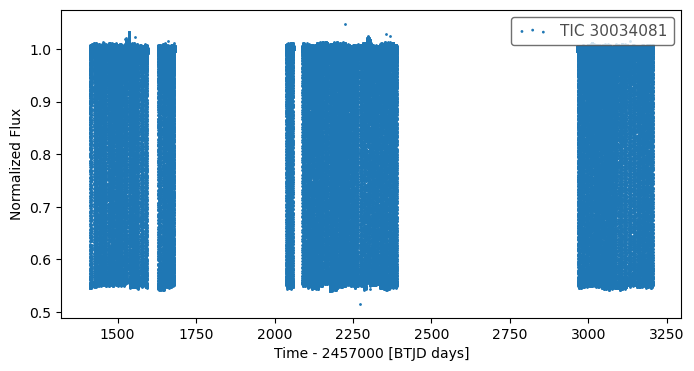

In [5]:
# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

# t0 = 2337.376
# period_triple = 0.774

mask = time < 0  # (time > 2893.16-1) & (time < 2893.16+1) 

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})


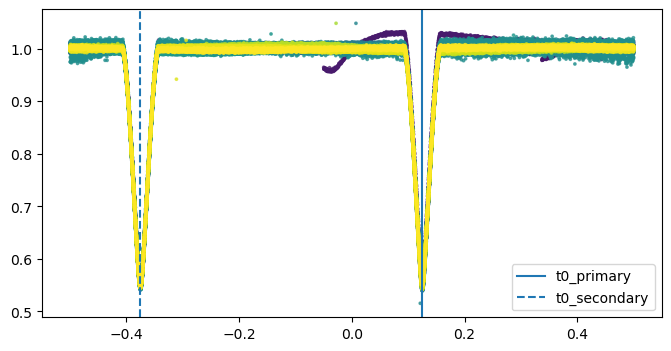

In [6]:
%matplotlib inline
# %matplotlib widget

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
# we assume the TCE caught both primary and secondary eclipses
# epoch=1411.5528, duration_hr=7.0212, period=2.344623, label="s0001-s0069:TCE1"
period = 2.344623 * 2

t0_primary = 1411.5528 + period / 2
t0_secondary = 1411.5528

duration_hr_primary = 7.0212  # used for the window to cut the lighcurve around eclipses in later cells

t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.25  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

### Now that the data is ready we can start 

In [20]:
# show data to visualize what's changed in each step below
data  

time      flux       err     phase
0       1410.902918  0.994350  0.001387  0.486410
1       1410.904307  0.996388  0.001389  0.486706
2       1410.905696  0.990963  0.001386  0.487003
3       1410.907085  0.991479  0.001387  0.487299
4       1410.908474  0.996198  0.001388  0.487595
...             ...       ...       ...       ...
479075  3206.376043  1.002296  0.001530  0.378057
479076  3206.377432  1.004778  0.001532  0.378354
479077  3206.378821  1.000041  0.001531  0.378650
479078  3206.380210  1.001699  0.001532  0.378946
479079  3206.381599  1.004454  0.001533  0.379242

[479080 rows x 4 columns]

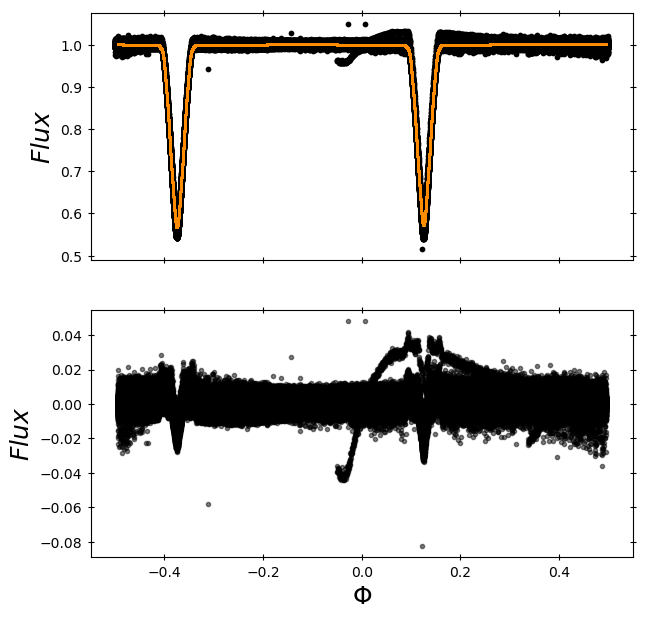

time      flux       err     phase  flux_sub_binary  \
0       1410.902918  0.994350  0.001387  0.486410        -0.006541   
1       1410.904307  0.996388  0.001389  0.486706        -0.004500   
2       1410.905696  0.990963  0.001386  0.487003        -0.009923   
3       1410.907085  0.991479  0.001387  0.487299        -0.009404   
4       1410.908474  0.996198  0.001388  0.487595        -0.004682   
...             ...       ...       ...       ...              ...   
479075  3206.376043  1.002296  0.001530  0.378057         0.000752   
479076  3206.377432  1.004778  0.001532  0.378354         0.003233   
479077  3206.378821  1.000041  0.001531  0.378650        -0.001505   
479078  3206.380210  1.001699  0.001532  0.378946         0.000152   
479079  3206.381599  1.004454  0.001533  0.379242         0.002906   

        binary_model  
0           1.000891  
1           1.000888  
2           1.000885  
3           1.000883  
4           1.000880  
...              ...  
479075      1.001544  
479076      1.001545  
479077      1.001546  
479078      1.001547  
479079      1.001548  

[479080 rows x 6 columns]

In [21]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 474284 901
reached the end
10 442875 901
reached the end
10 438029 901
reached the end
10 436535 901
reached the end
10 435902 901
reached the end


time      flux       err     phase  flux_sub_binary  \
0       1410.902918  0.994350  0.001387  0.486410        -0.006541   
1       1410.904307  0.996388  0.001389  0.486706        -0.004500   
2       1410.905696  0.990963  0.001386  0.487003        -0.009923   
3       1410.907085  0.991479  0.001387  0.487299        -0.009404   
4       1410.908474  0.996198  0.001388  0.487595        -0.004682   
...             ...       ...       ...       ...              ...   
479075  3206.376043  1.002296  0.001530  0.378057         0.000752   
479076  3206.377432  1.004778  0.001532  0.378354         0.003233   
479077  3206.378821  1.000041  0.001531  0.378650        -0.001505   
479078  3206.380210  1.001699  0.001532  0.378946         0.000152   
479079  3206.381599  1.004454  0.001533  0.379242         0.002906   

        binary_model  flux_detrended  
0           1.000891        1.000238  
1           1.000888        1.002265  
2           1.000885        0.996830  
3           1.000883        0.997337  
4           1.000880        1.002048  
...              ...             ...  
479075      1.001544        1.001899  
479076      1.001545        1.004381  
479077      1.001546        0.999645  
479078      1.001547        1.001301  
479079      1.001548        1.004055  

[479080 rows x 7 columns]

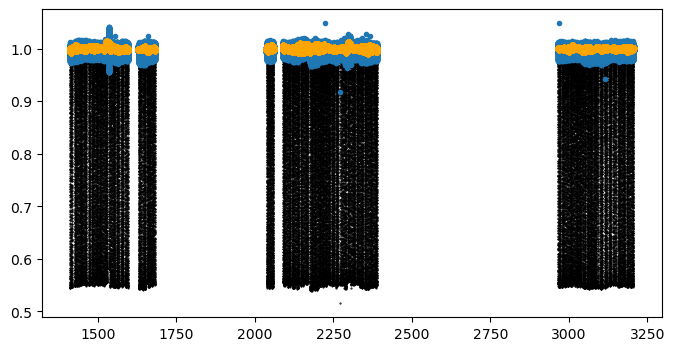

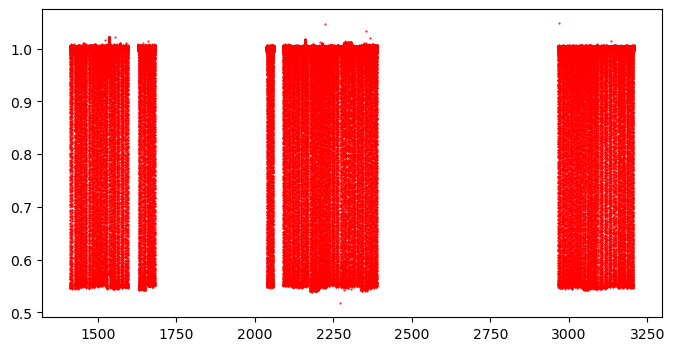

In [22]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

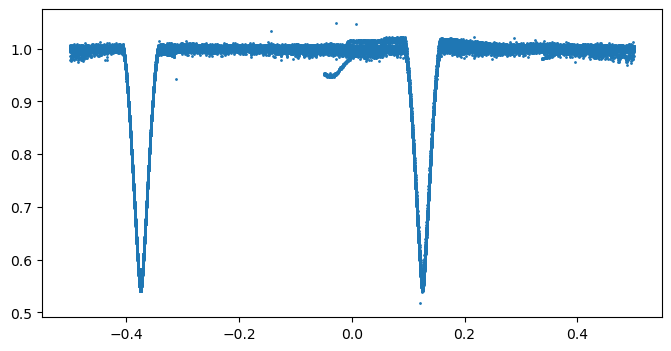

In [24]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   1413.897423 0.12499999999999767
Secondary: 1411.5528 -0.37499999999999306
window_width (phase): 0.07486491431671531


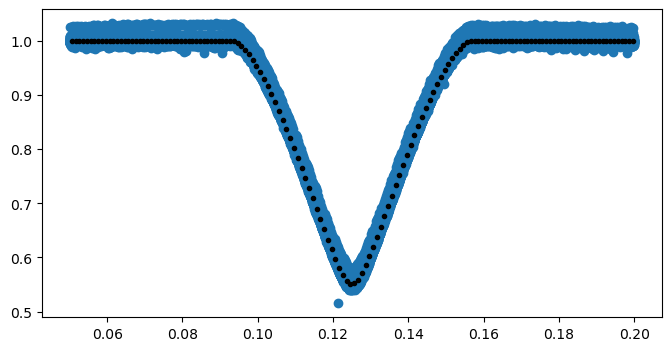

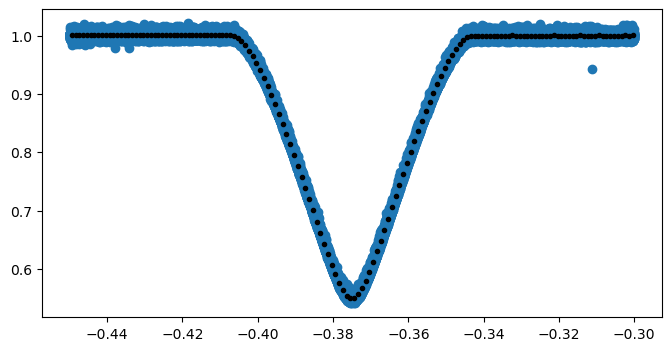

In [7]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]

print('Primary:  ', t0_primary, midpoint_p)
print('Secondary:', t0_secondary, midpoint_s)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width = 1.2 * duration_hr_primary / 24 / period
# window_width = 0.05
print("window_width (phase):", window_width)


data_primary = data[(data['phase'] > midpoint_p - window_width) & (data['phase'] < midpoint_p + window_width) ]
data_secondary = data[(data['phase'] > midpoint_s - window_width) & (data['phase'] < midpoint_s + window_width) ]

ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)
ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


# -- -- -- -- -- -- -- -- -- 

fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_primary.phase, data_primary.flux, zorder = -2)
plt.show()

# -- -- -- -- -- -- -- -- -- 
fig = plt.subplots(figsize=figsize, sharex=True)
plt.errorbar(ph_binned_s, flux_binned_s, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(data_secondary.phase, data_secondary.flux, zorder = -2)
plt.show() 

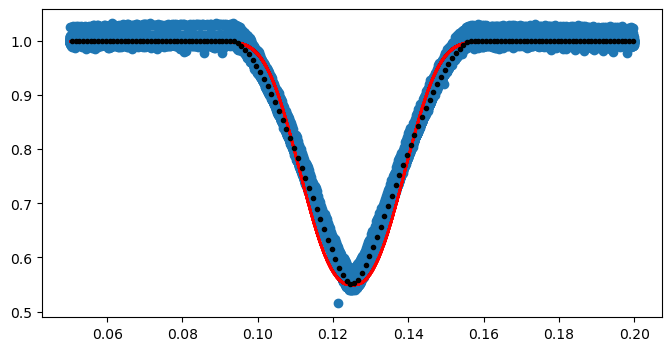

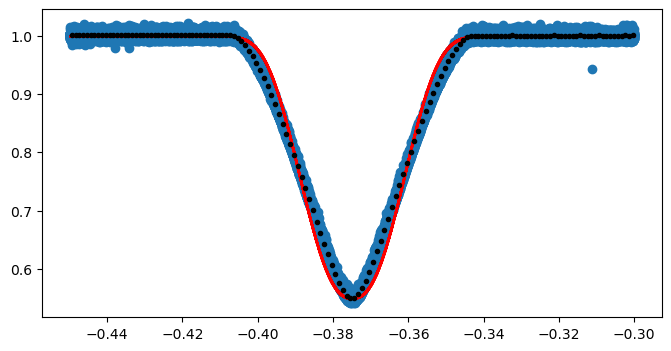

In [40]:
### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.45, midpoint_p, 0.012, 1.2]
start_vals_s = [1, -0.45, midpoint_s, 0.012, 1.2]

# - - -- - 

etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)


100%|████████████████████████████████████████████████████████| 1000/1000 [1:40:41<00:00,  6.04s/it]


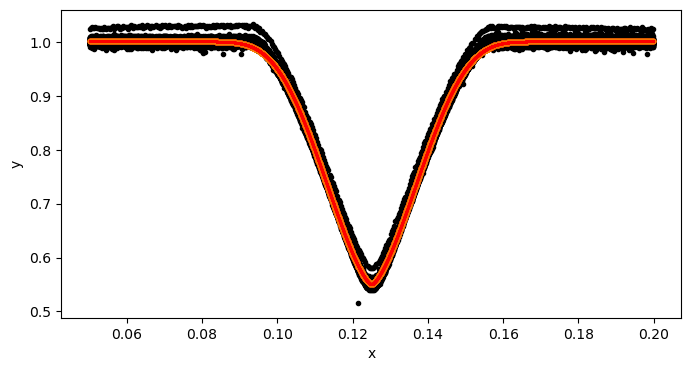

100%|██████████████████████████████████████████████████████████| 1000/1000 [10:17<00:00,  1.62it/s]


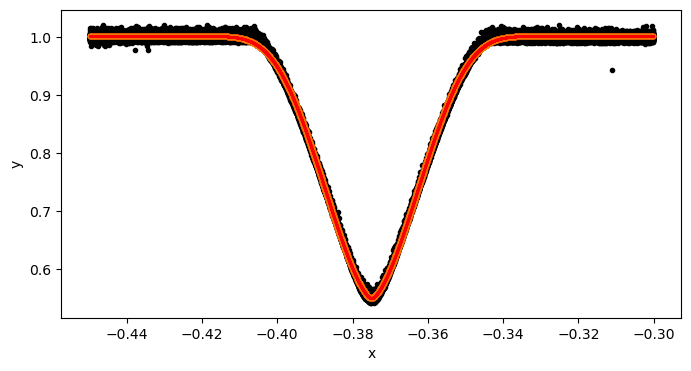

In [41]:
# run the initial model fit using MCMC for the primary and secondary eclipses 

mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
!$NOTIFY_CMD "Initial fit done"

382

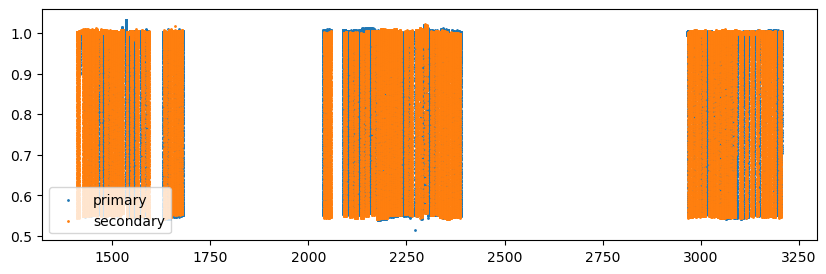

In [42]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1413.897423 4.689246 1413.897423


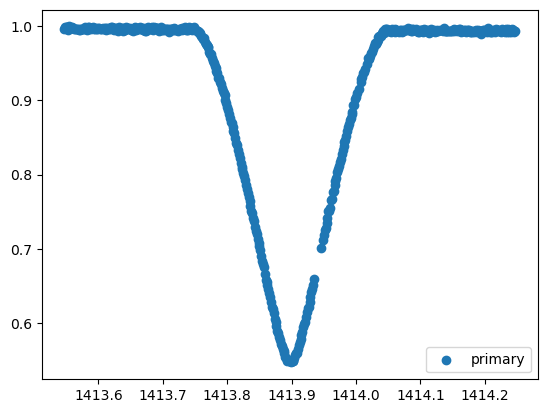

1413.897423 4.689246 1418.5866689999998


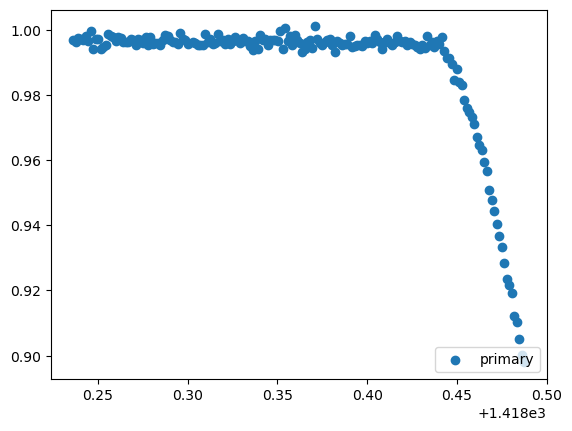

1413.897423 4.689246 1423.275915


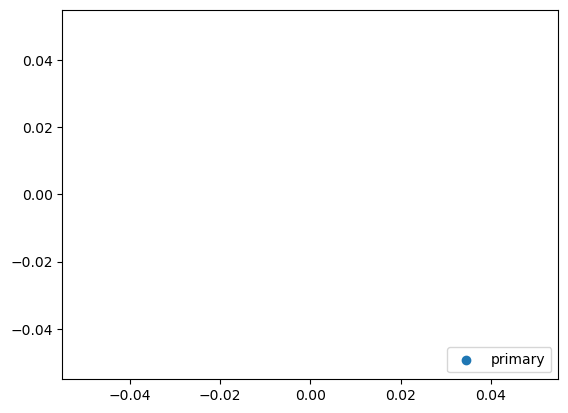

1411.5528 4.689246 1411.5528


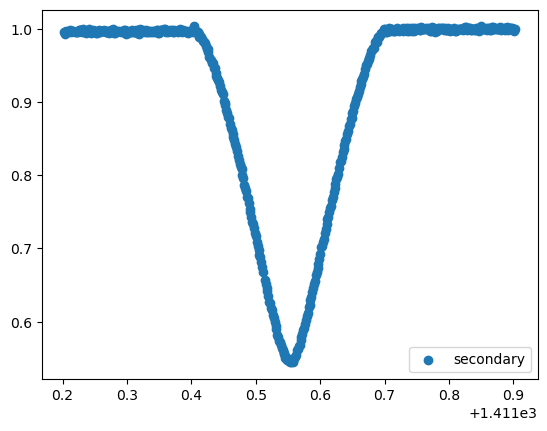

1411.5528 4.689246 1416.2420459999998


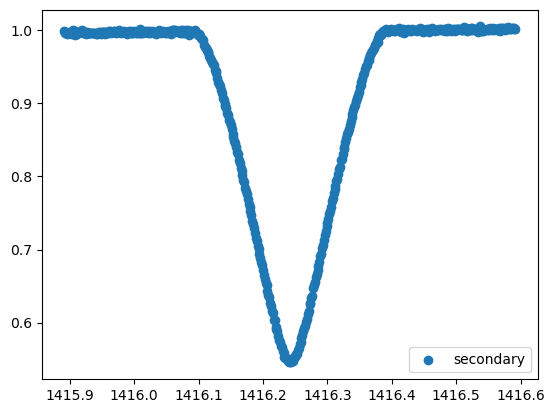

1411.5528 4.689246 1420.931292


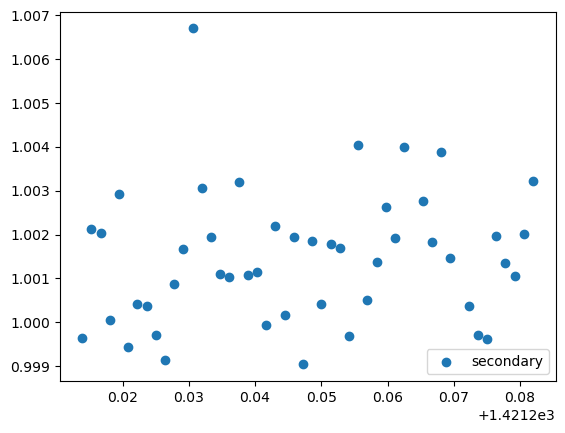

In [45]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

for i in tr_index[0:3]:        
    transit_time = t0_secondary+(period*i)
    x = np.array(data_secondary.time)
    y = np.array(data_secondary.flux) 
    yerr = np.array(data_secondary.err)
    
    print (t0_secondary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="secondary")
    plt.legend(loc="lower right")
    plt.show()

In [46]:
print("Primary   - Start params")
print(*start_vals)
print("Primary   - Initial params")
print(mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau)

print("Secondary - Start params")
print(*start_vals_s)
print("Secondary - Initial params")
print(mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s)

Primary   - Start params
1 -0.45 0.12499999999999767 0.012 1.2
Primary   - Initial params
1.0011142495421985 -0.4510105175356701 0.12499719178254205 0.014577189327488124 0.7247681117651352
Secondary - Start params
1 -0.45 -0.37499999999999306 0.012 1.2
Secondary - Initial params
1.0013589390322668 -0.452358403656157 -0.37500037502926503 0.014534760518686683 0.7649265918969392


Fitting individual primary eclipses...
Creating new manifest file
1413.897423 1.0011142495421985 -0.4510105175356701 0.12499719178254205


  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.67it/s]


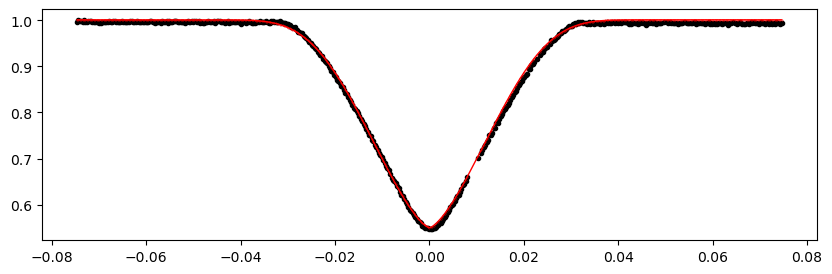

1418.5866689999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1309.23it/s]


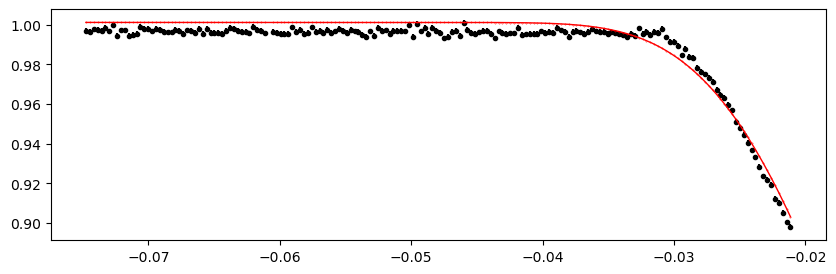

1427.9651609999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1329.96it/s]


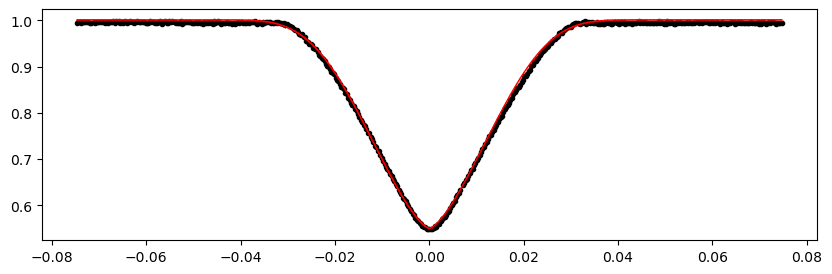

1432.654407 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1254.99it/s]


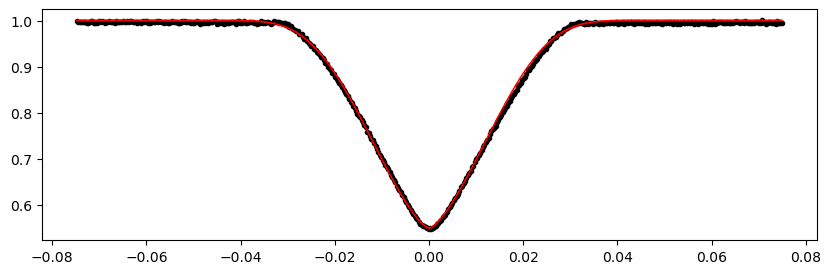

1442.0328989999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.08it/s]


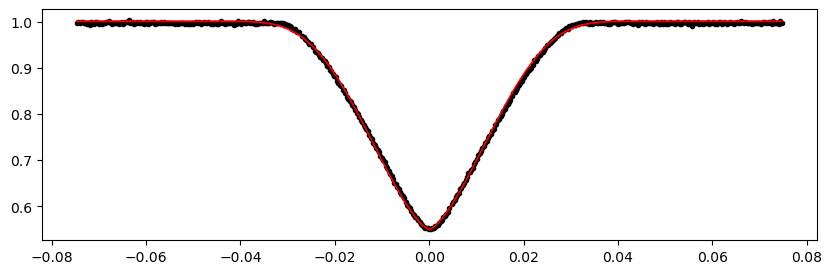

1446.722145 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.82it/s]


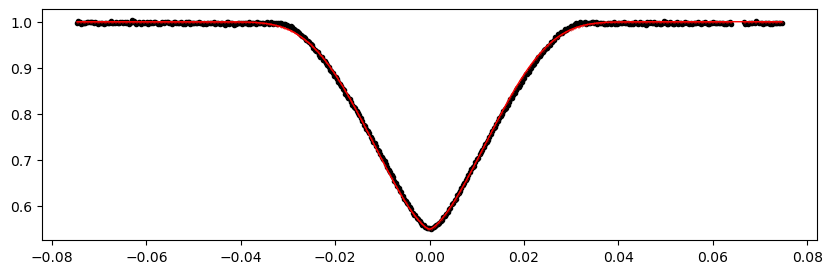

1451.4113909999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.59it/s]


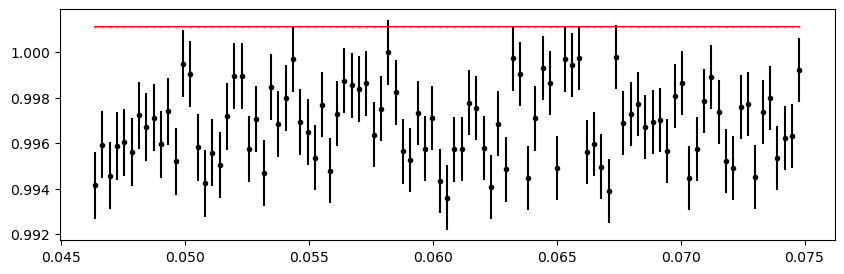

1456.1006369999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.13it/s]


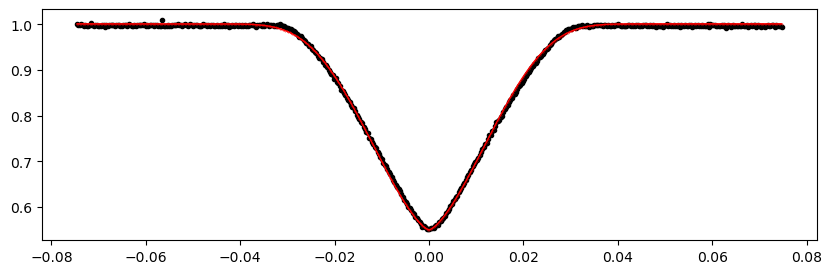

1460.789883 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.74it/s]


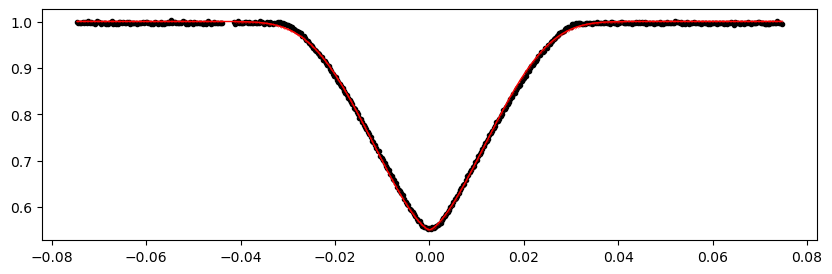

1470.168375 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.41it/s]


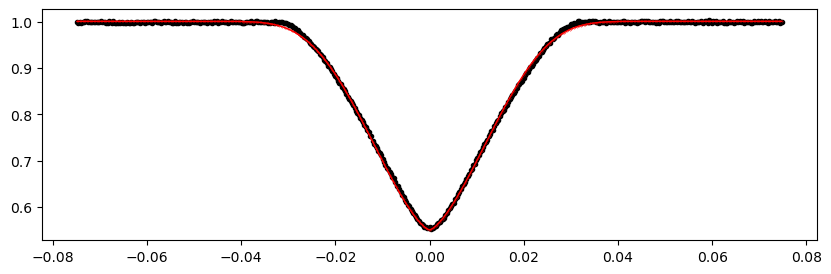

1474.8576209999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.36it/s]


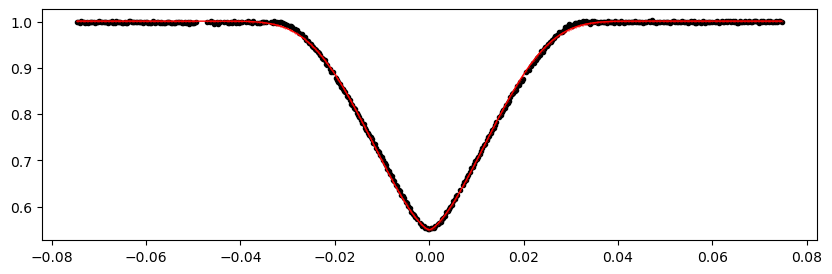

1479.5468669999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.19it/s]


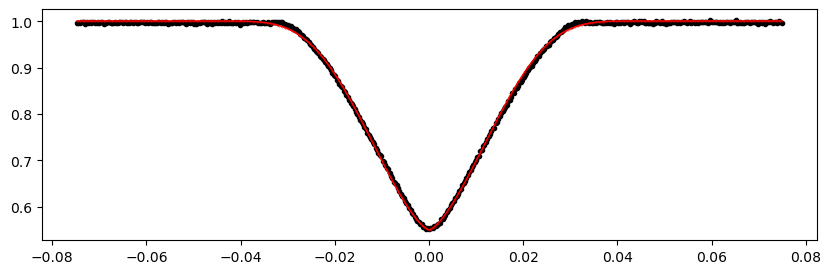

1484.236113 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.05it/s]


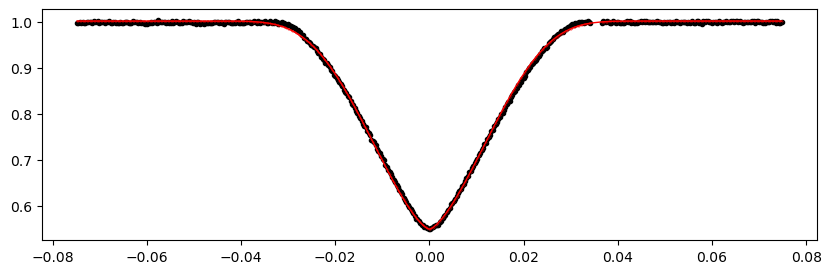

1488.9253589999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.97it/s]


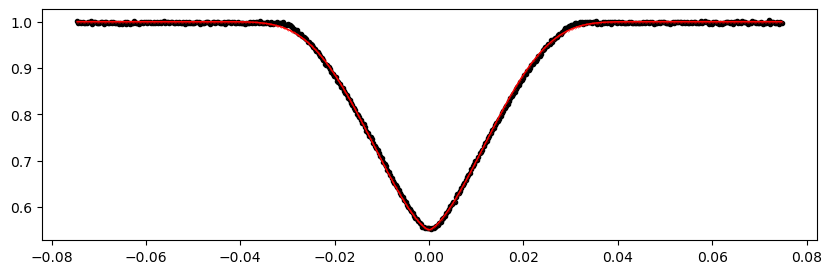

1493.614605 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.27it/s]


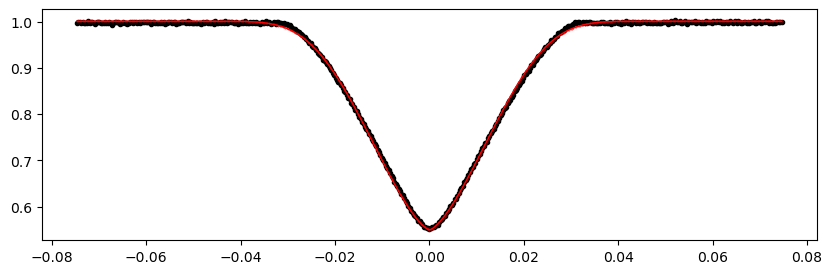

1498.303851 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.62it/s]


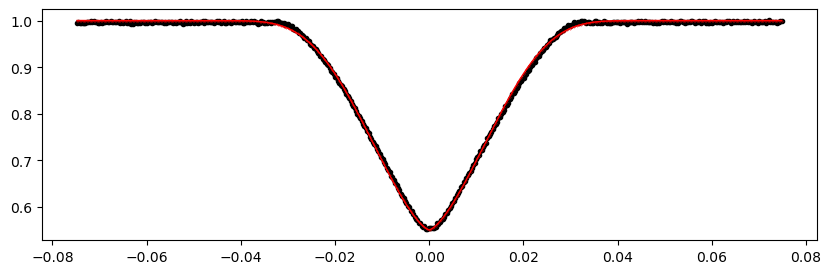

1502.9930969999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.50it/s]


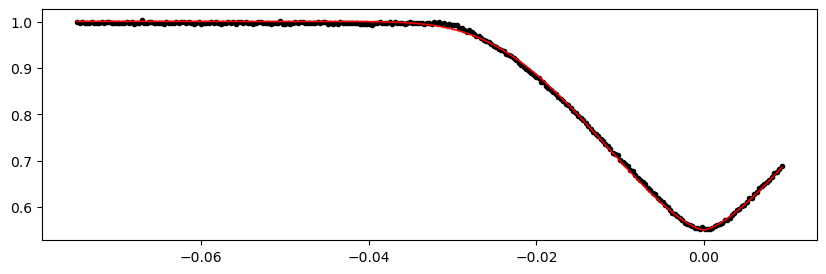

1507.682343 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.92it/s]


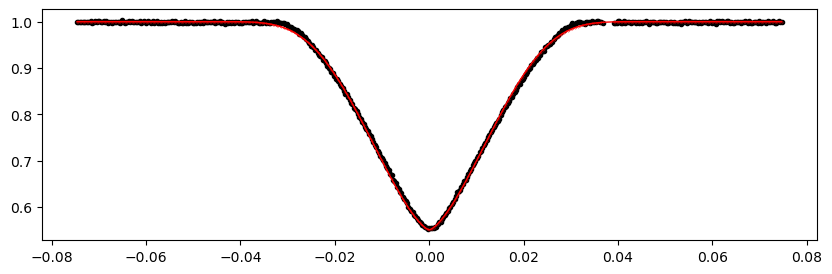

1512.3715889999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.29it/s]


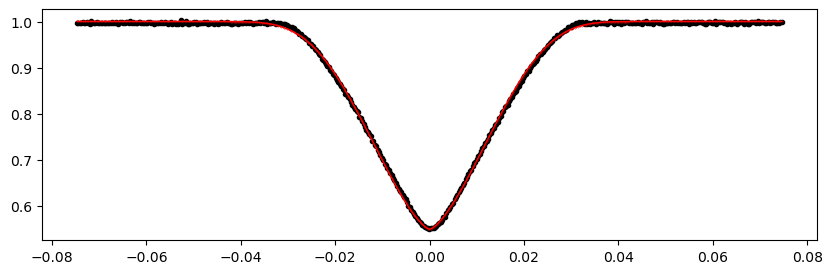

1521.750081 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.87it/s]


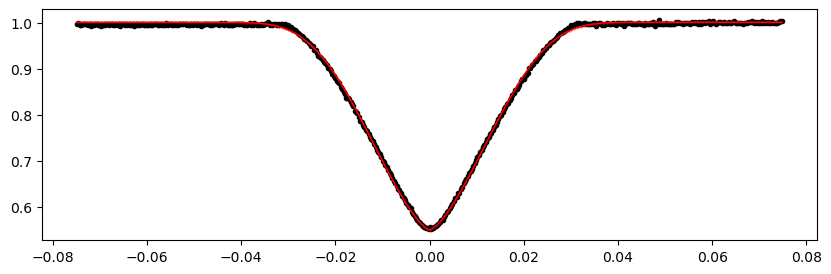

1526.4393269999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.57it/s]


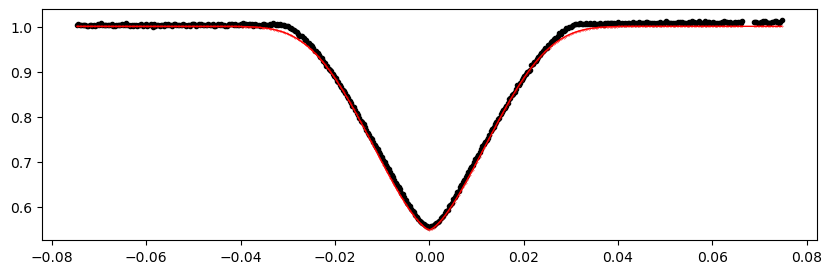

1535.8178189999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.55it/s]


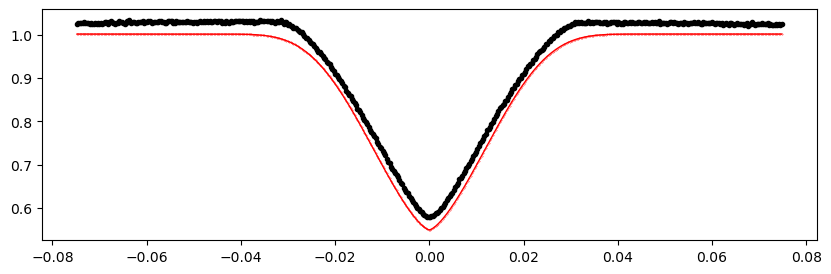

1540.5070649999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.83it/s]


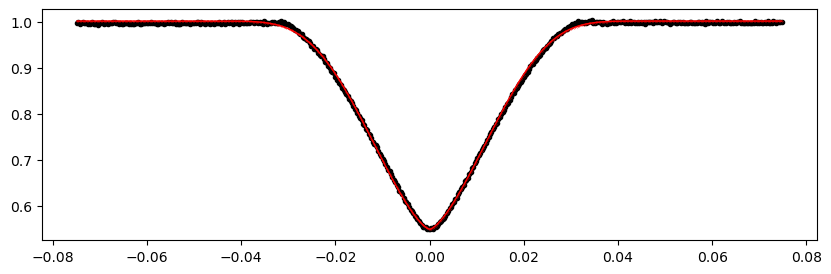

1545.196311 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.26it/s]


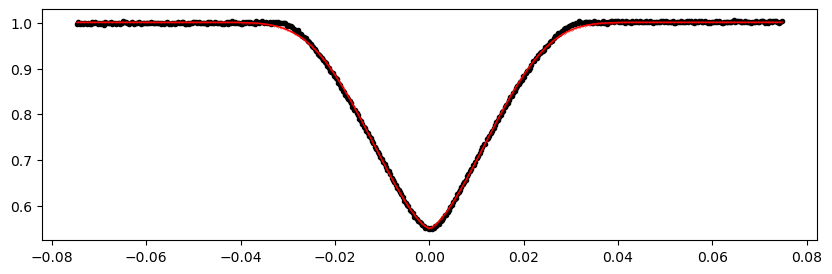

1549.8855569999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.23it/s]


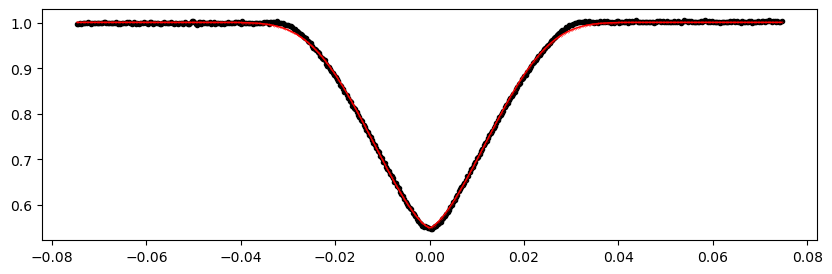

1554.574803 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.01it/s]


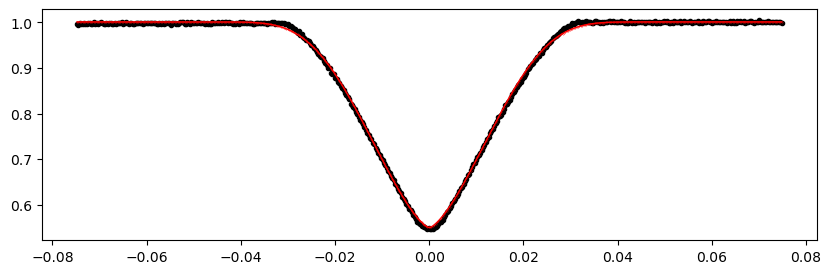

1559.2640489999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.77it/s]


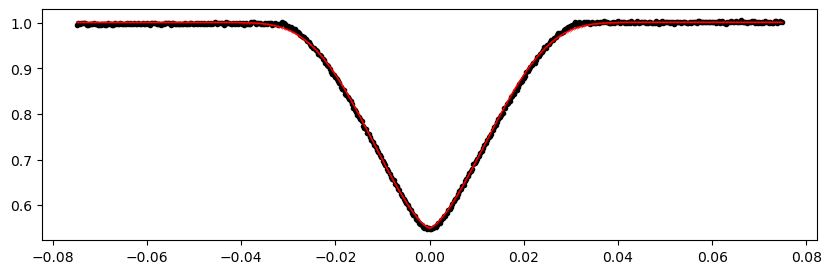

1563.9532949999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.05it/s]


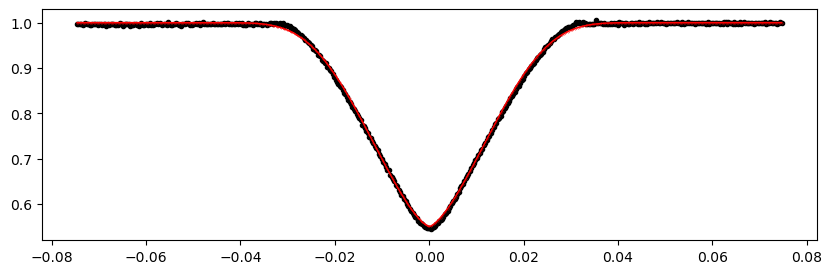

1568.642541 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.72it/s]


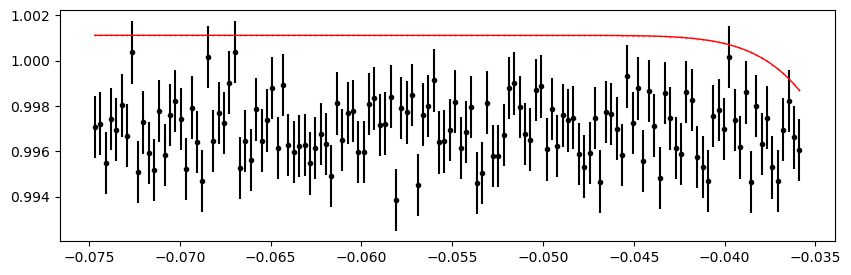

1573.3317869999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.93it/s]


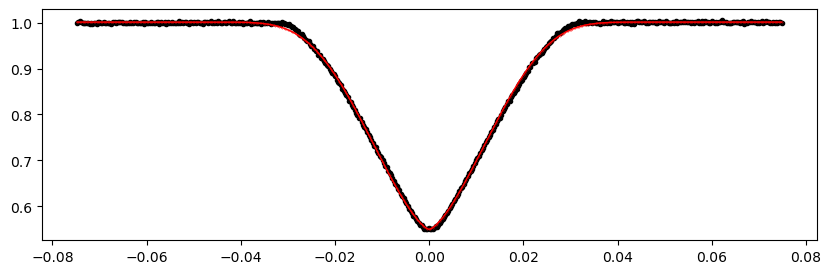

1578.021033 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.11it/s]


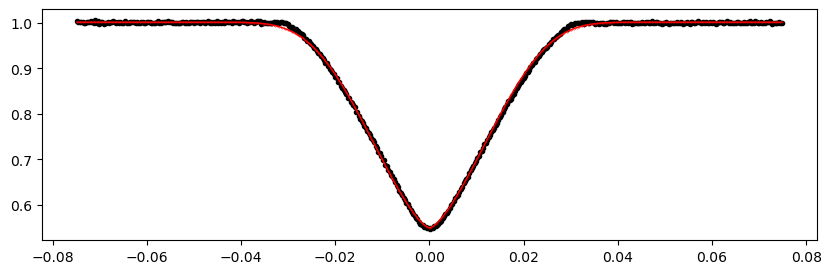

1587.3995249999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1325.46it/s]


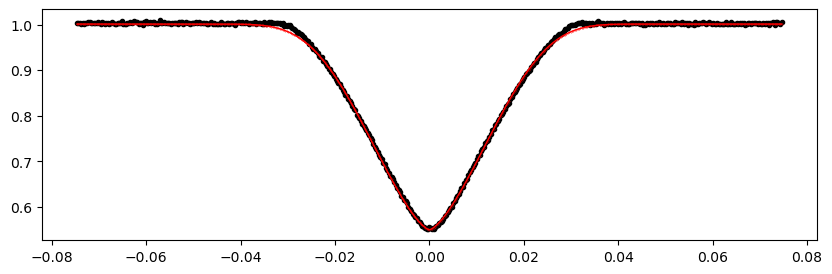

1592.088771 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.67it/s]


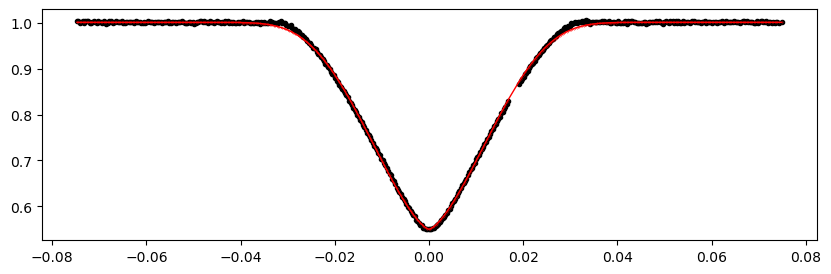

1629.602739 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.34it/s]


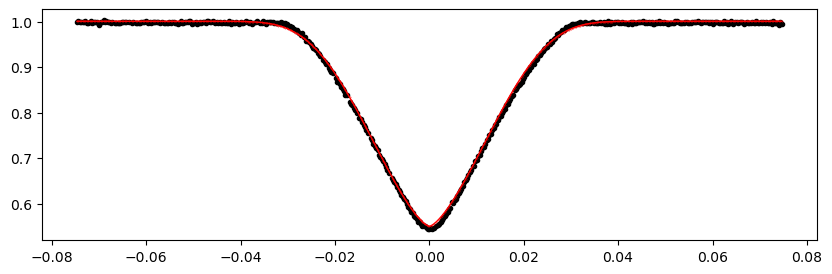

1634.2919849999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.47it/s]


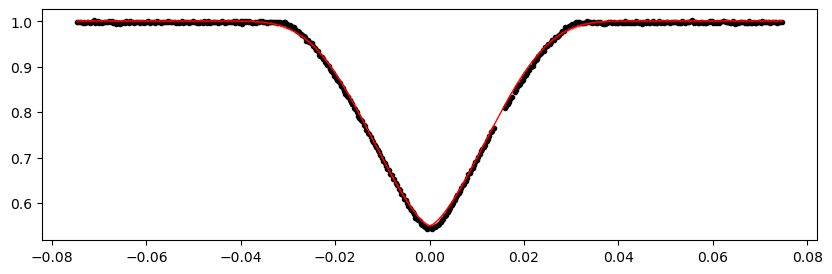

1638.9812309999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.82it/s]


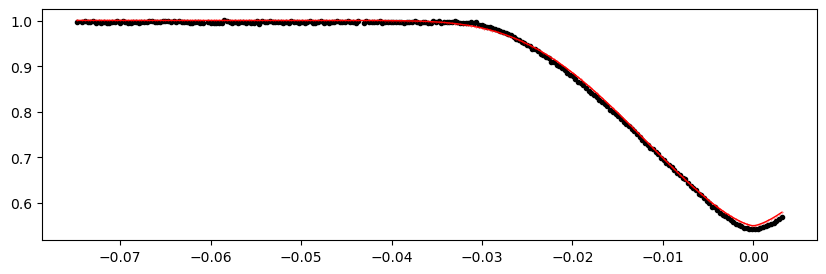

1643.670477 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.40it/s]


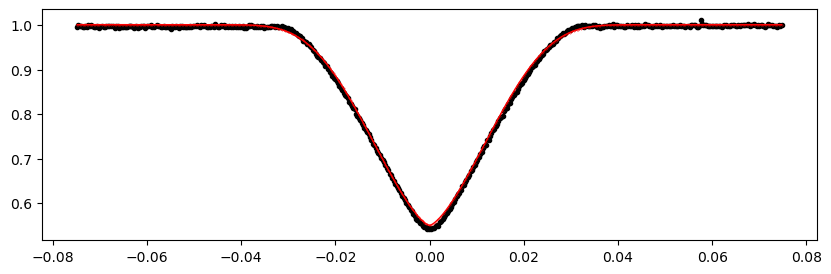

1648.3597229999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.45it/s]


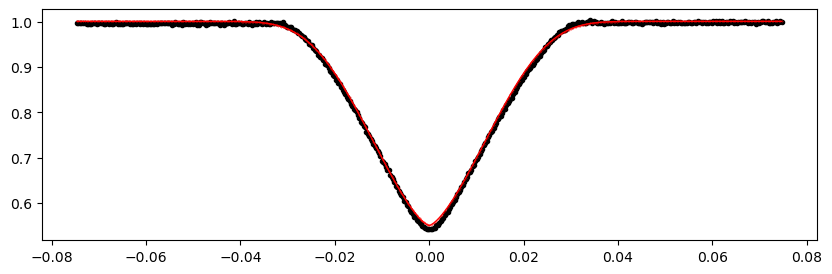

1653.048969 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.36it/s]


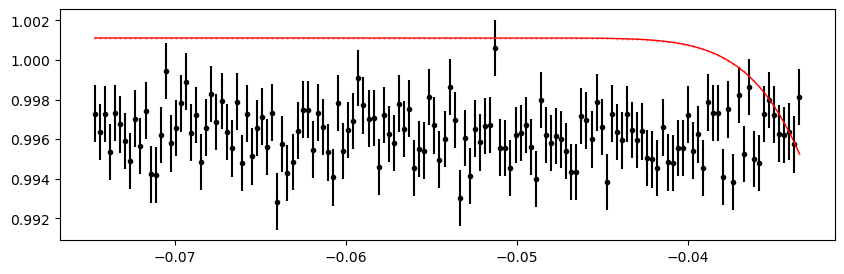

1657.7382149999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.66it/s]


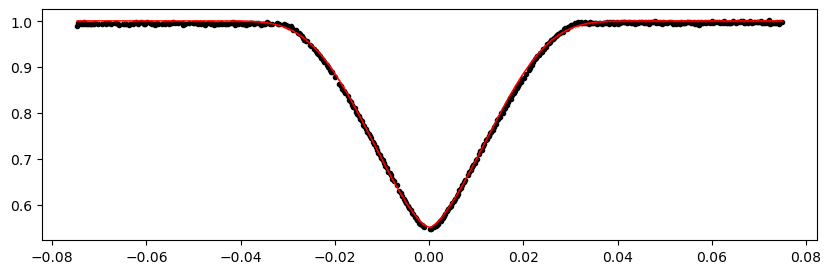

1662.4274609999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1313.85it/s]


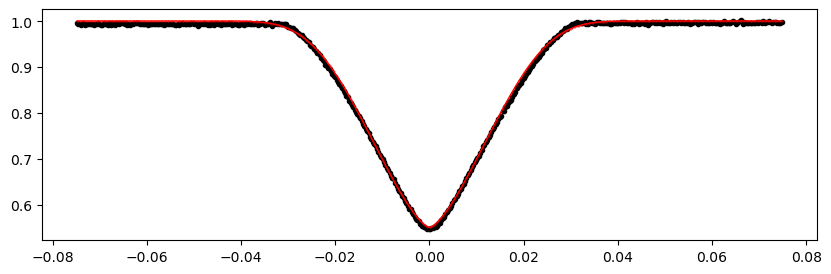

1667.116707 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.94it/s]


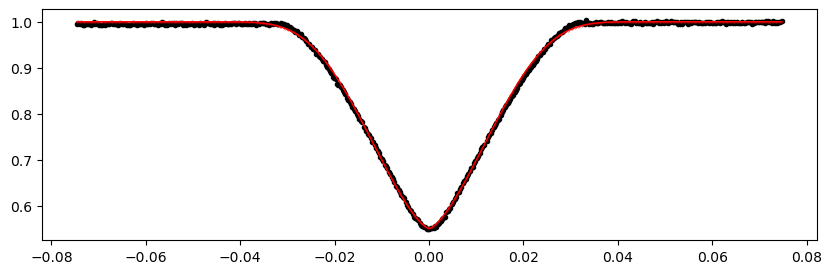

1671.8059529999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.87it/s]


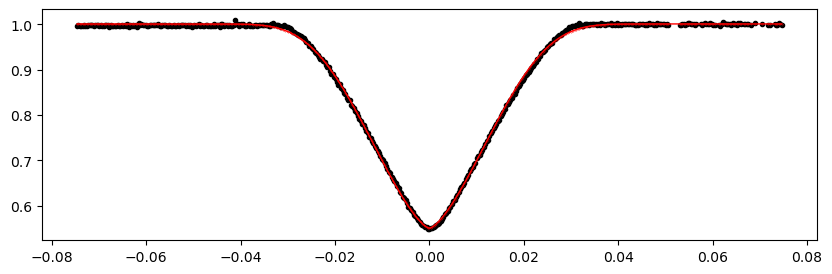

1676.495199 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.16it/s]


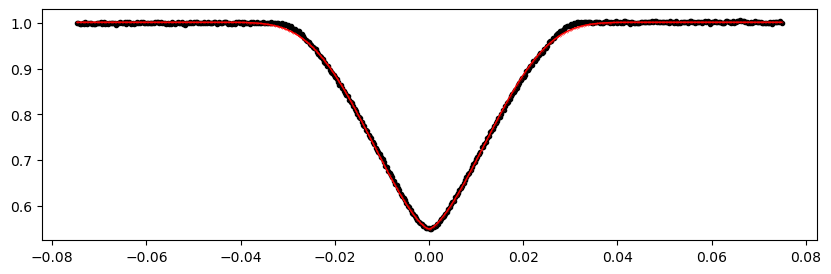

1681.1844449999999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.65it/s]


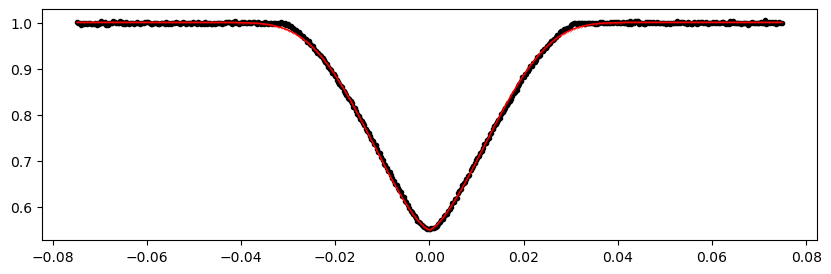

2037.567141 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.50it/s]


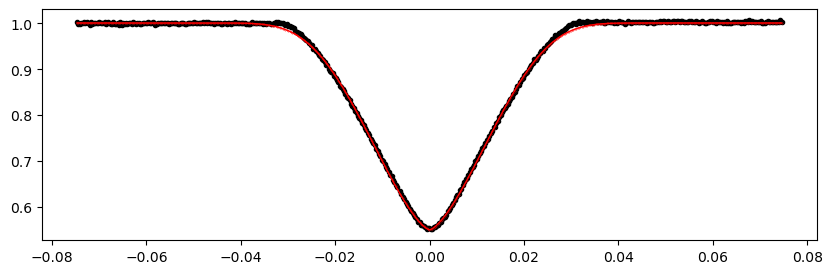

2042.256387 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.90it/s]


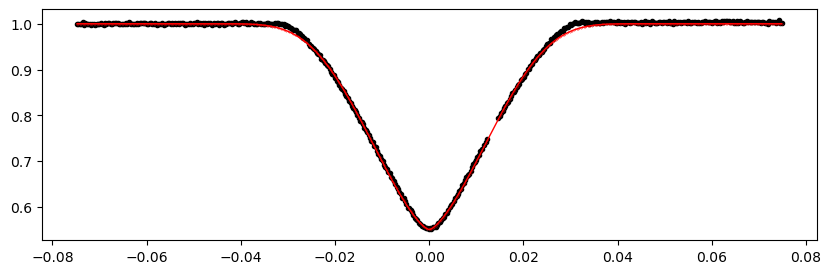

2046.9456329999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.02it/s]


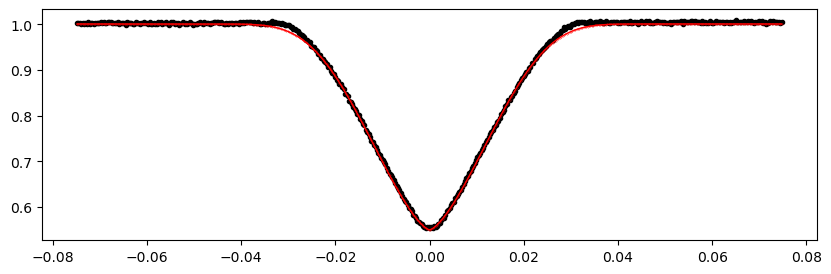

2051.6348789999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.77it/s]


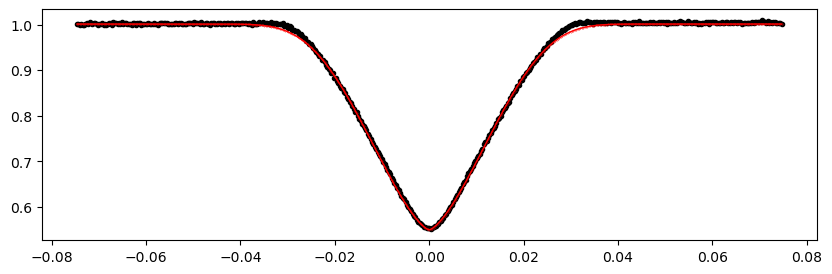

2056.324125 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.82it/s]


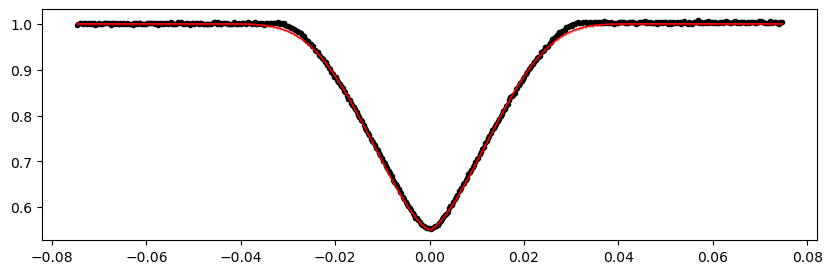

2089.148847 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.34it/s]


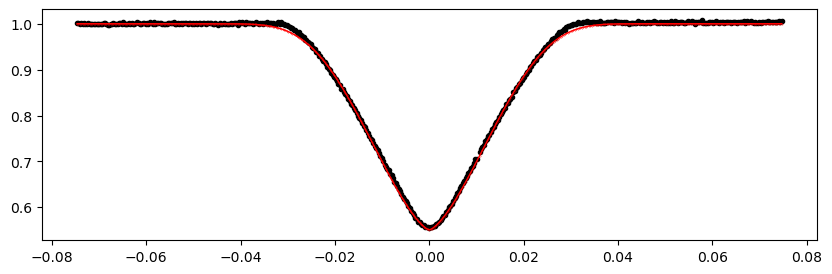

2093.838093 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.65it/s]


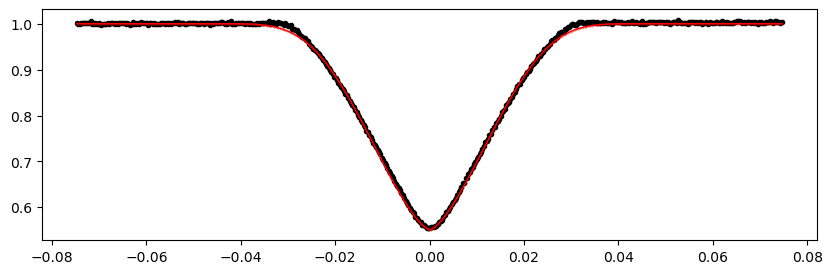

2098.5273389999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.13it/s]


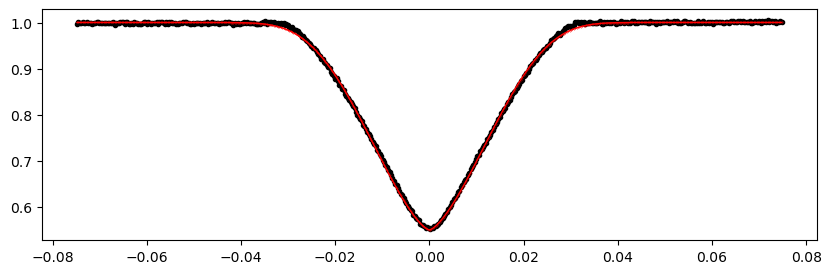

2103.216585 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.14it/s]


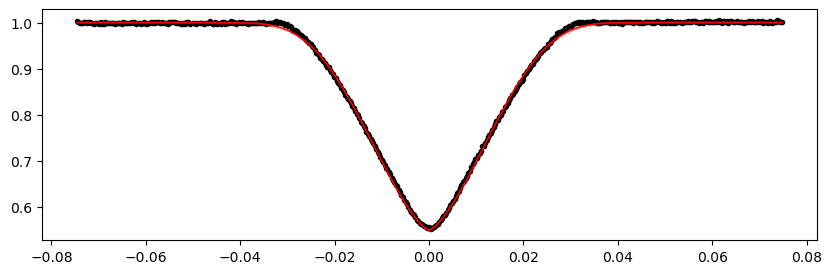

2107.905831 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.50it/s]


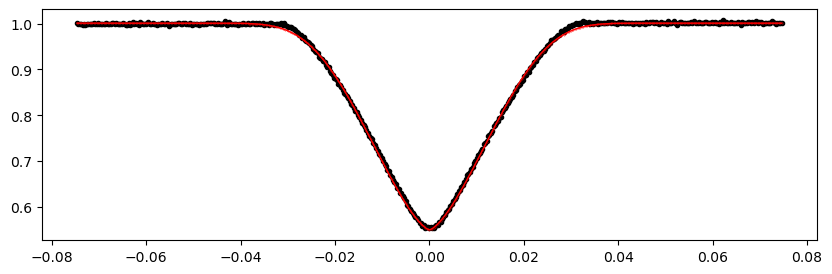

2112.595077 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.50it/s]


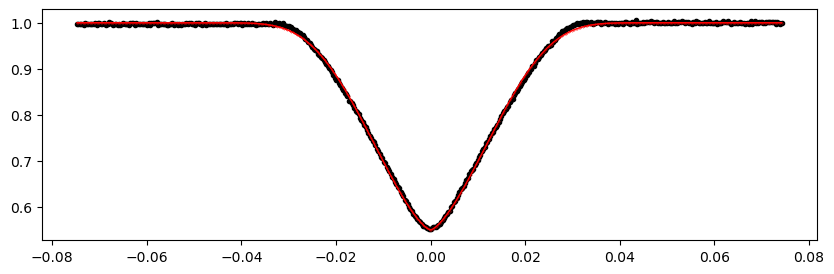

2117.284323 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.93it/s]


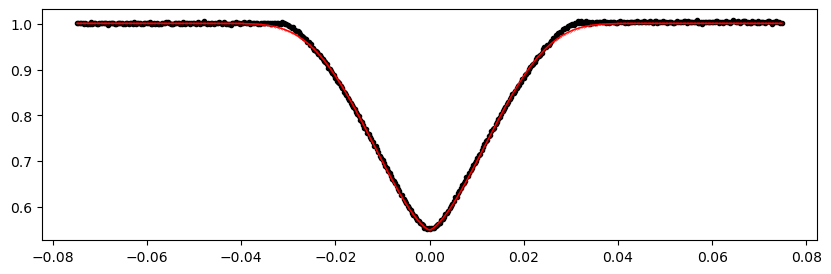

2121.9735689999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.13it/s]


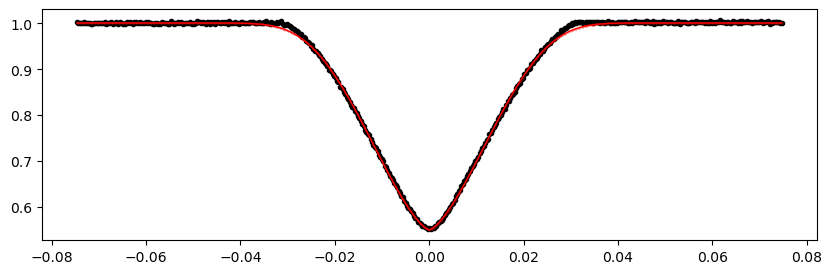

2126.6628149999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1326.27it/s]


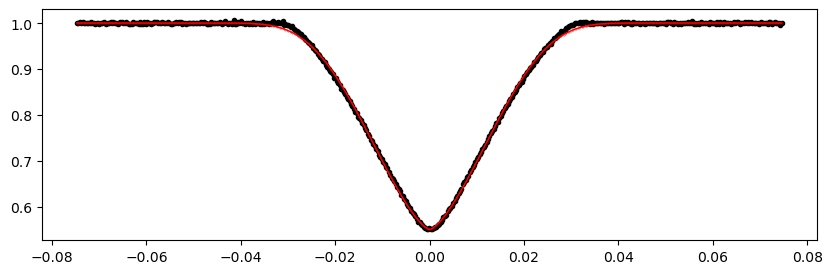

2131.3520609999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.05it/s]


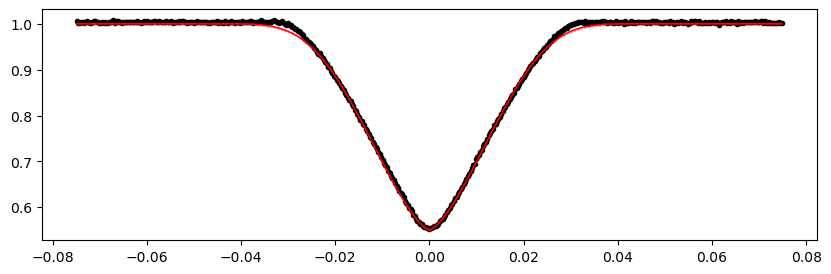

2136.041307 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.46it/s]


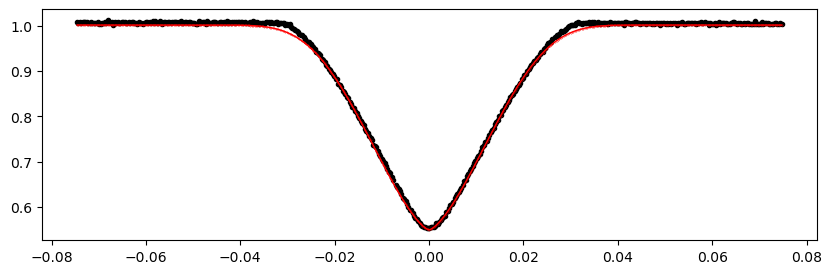

2140.730553 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.88it/s]


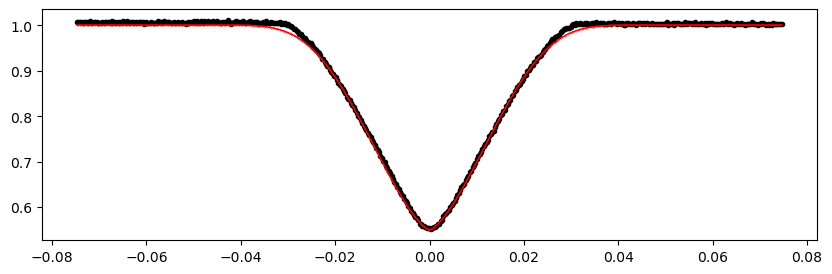

2145.419799 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.39it/s]


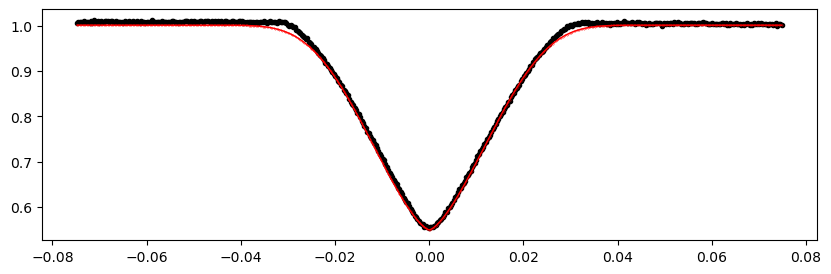

2150.1090449999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.65it/s]


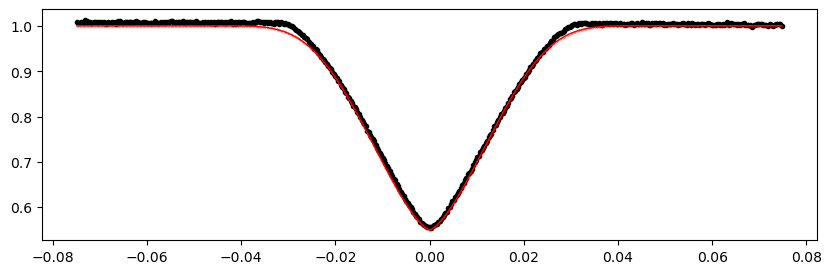

2154.798291 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.14it/s]


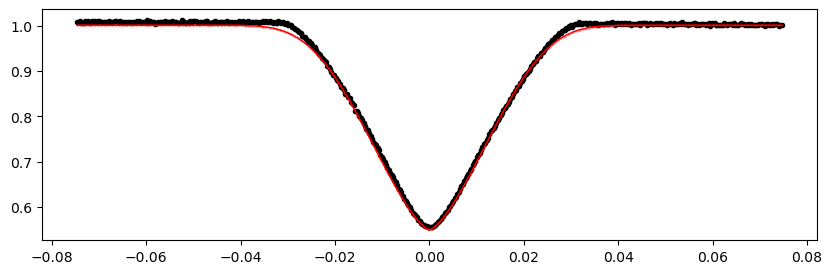

2159.487537 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.71it/s]


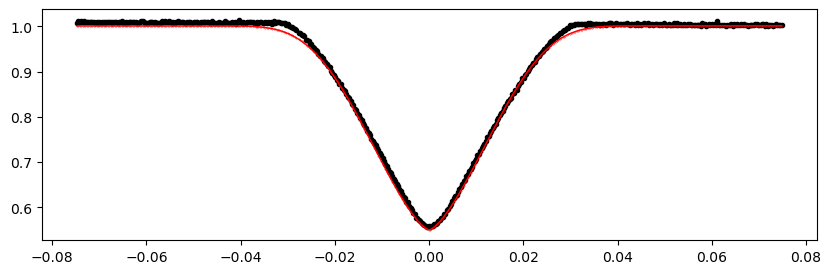

2164.176783 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.85it/s]


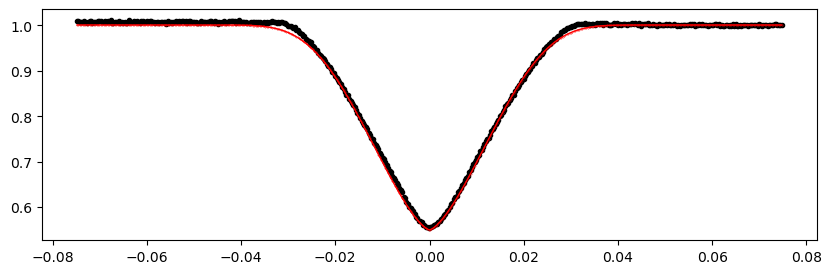

2168.866029 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.71it/s]


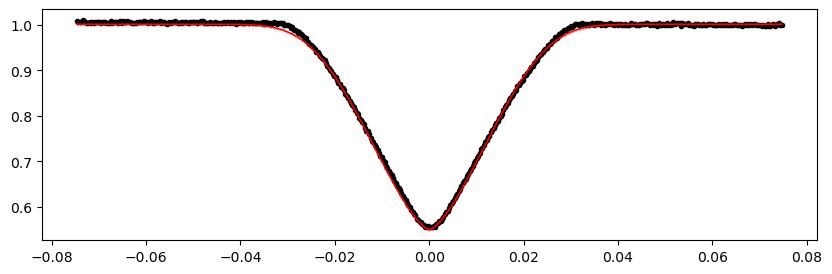

2178.2445209999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.58it/s]


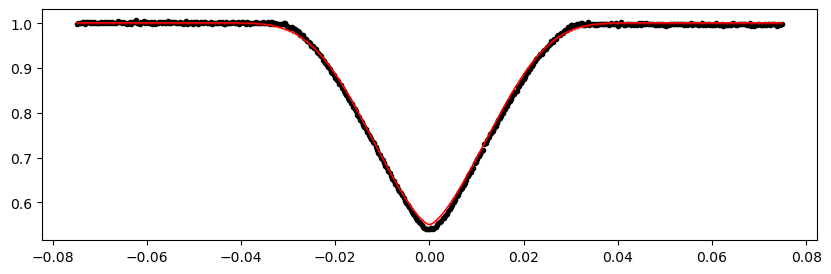

2182.933767 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.20it/s]


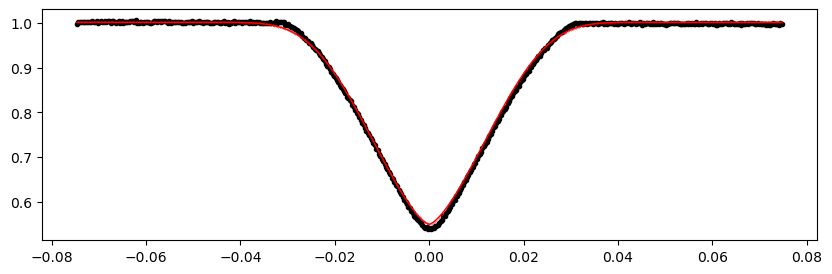

2187.623013 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.11it/s]


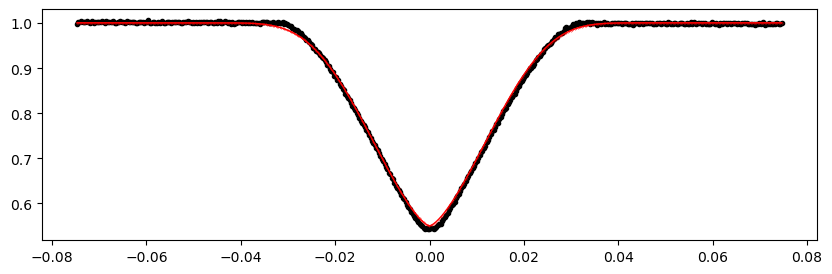

2192.312259 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1326.29it/s]


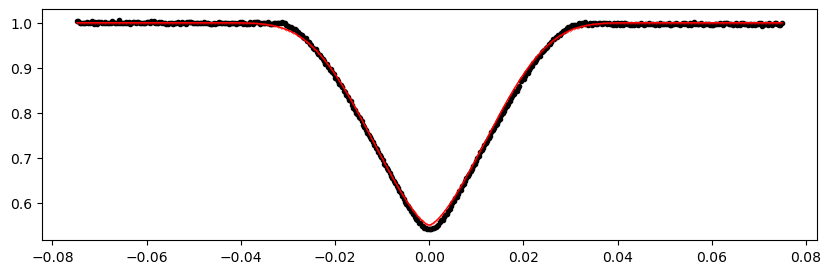

2197.0015049999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.00it/s]


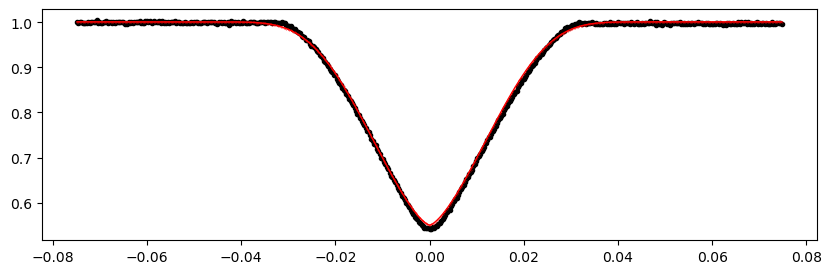

2201.690751 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.05it/s]


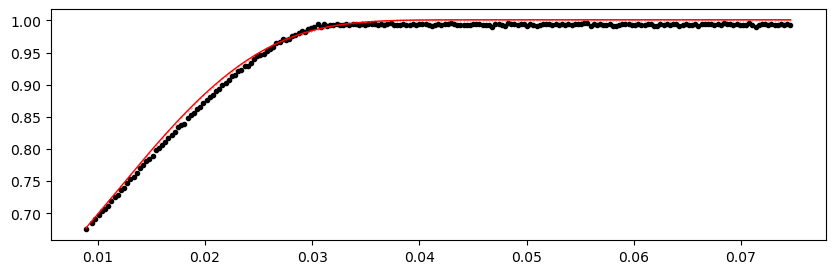

2206.379997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1329.73it/s]


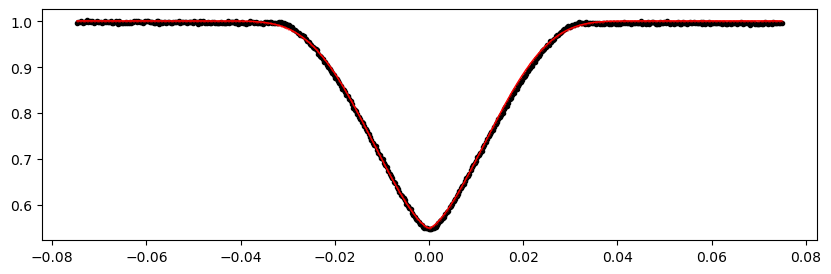

2211.069243 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.79it/s]


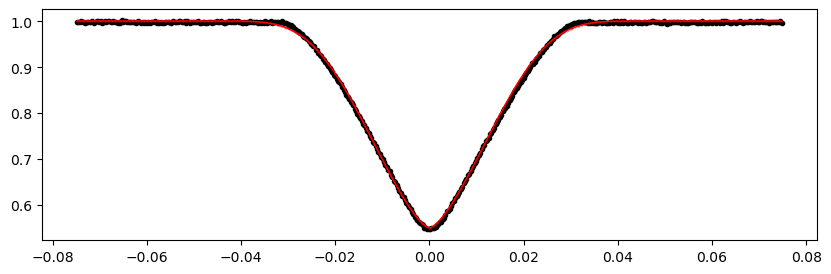

2215.758489 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.91it/s]


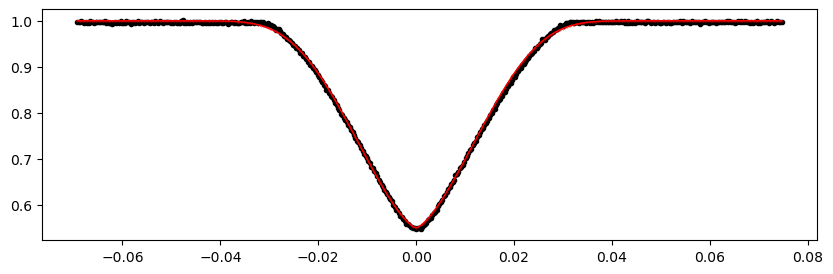

2220.4477349999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.03it/s]


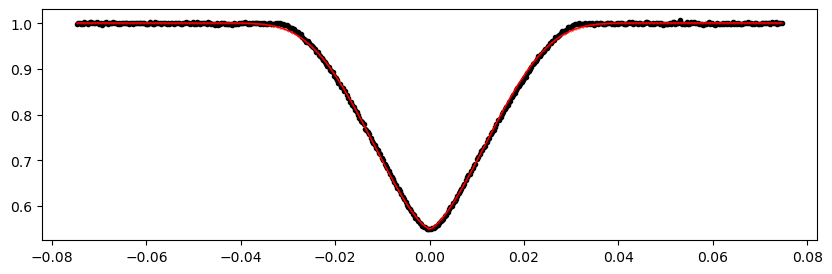

2225.1369809999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1329.86it/s]


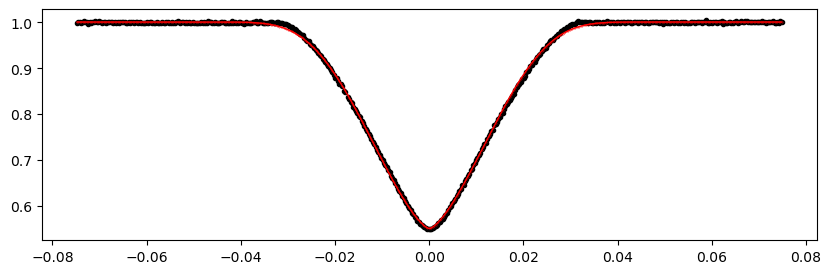

2229.826227 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1323.57it/s]


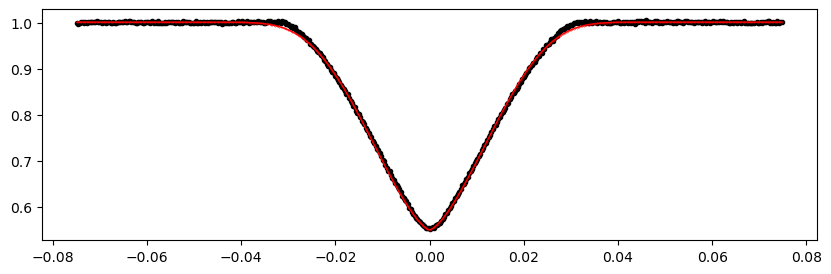

2234.515473 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.76it/s]


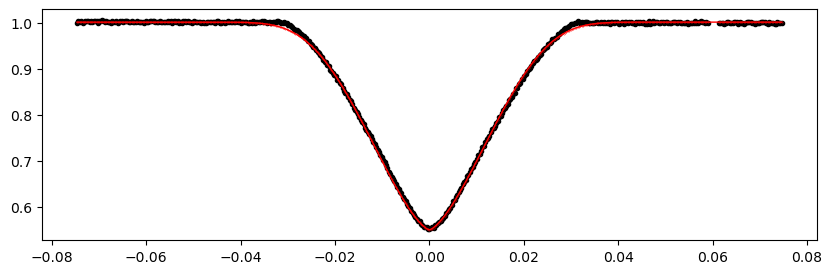

2239.204719 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.96it/s]


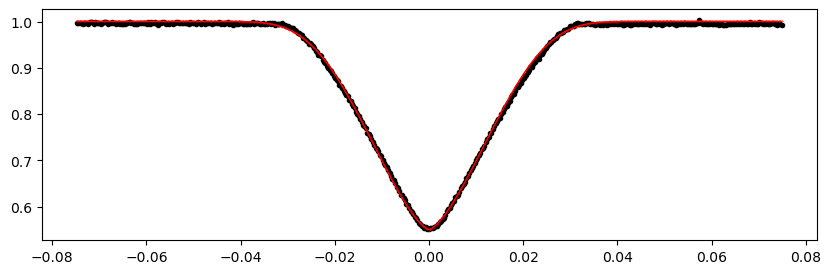

2243.8939649999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.94it/s]


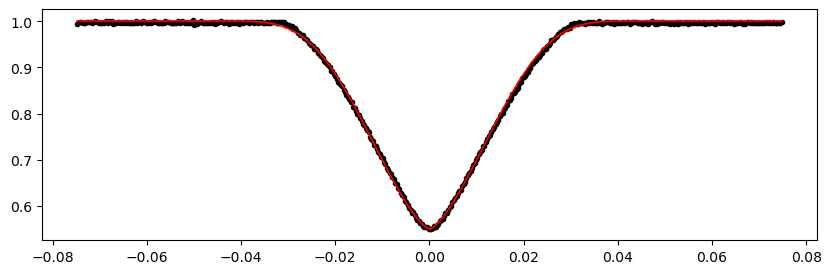

2248.583211 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.05it/s]


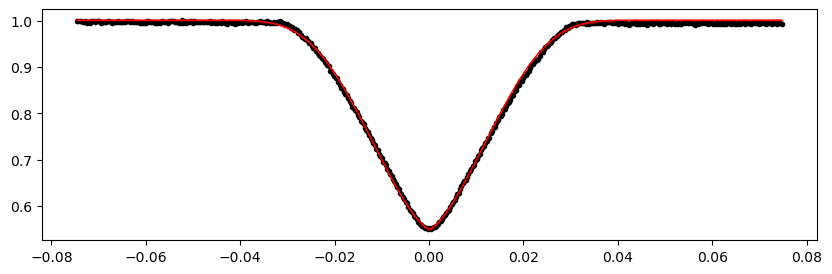

2253.272457 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.22it/s]


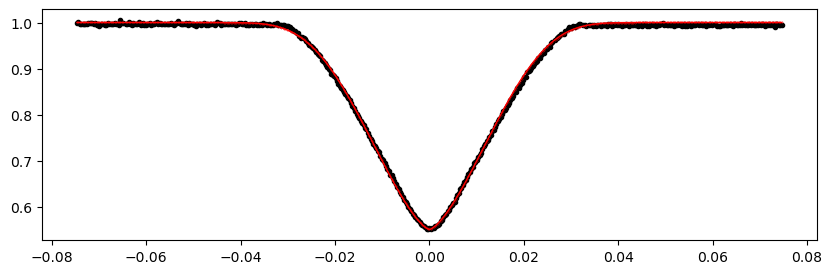

2257.961703 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.72it/s]


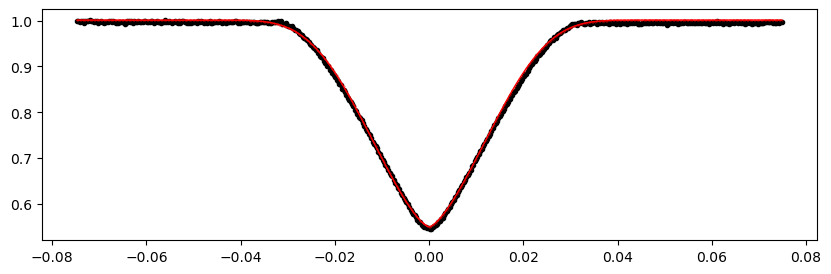

2262.650949 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.31it/s]


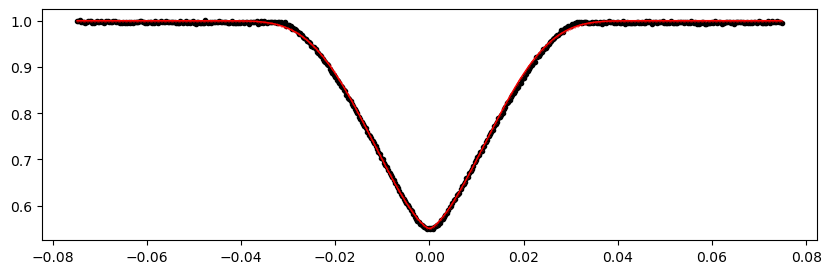

2267.3401949999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.15it/s]


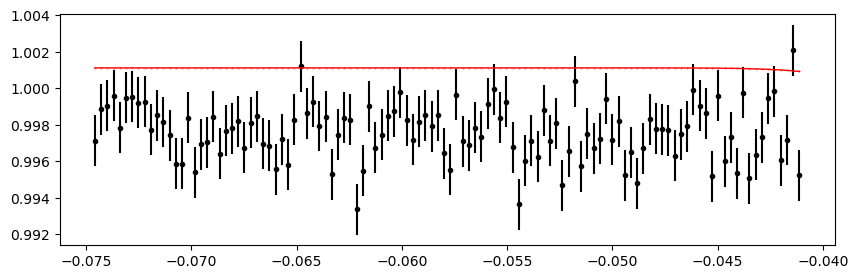

2272.0294409999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.48it/s]


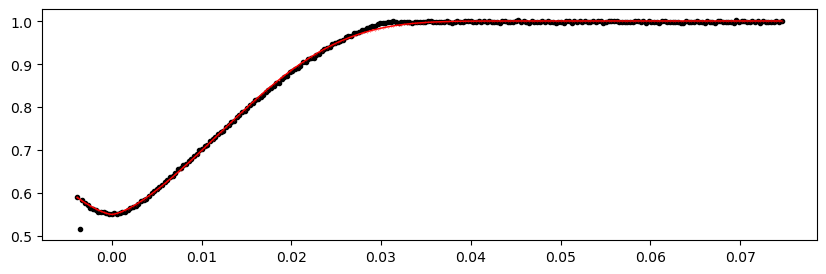

2276.7186869999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.23it/s]


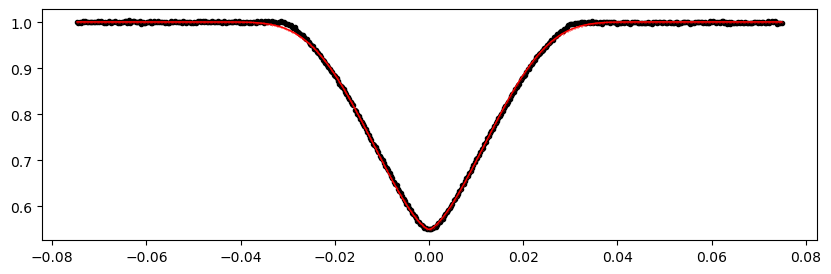

2286.097179 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.08it/s]


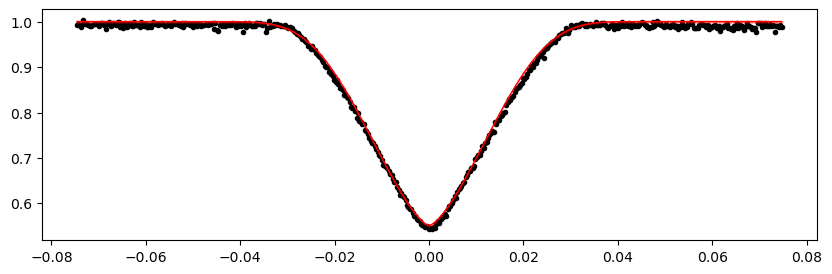

2290.786425 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.69it/s]


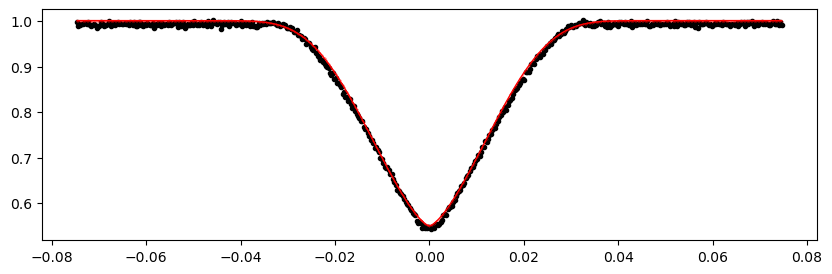

2295.4756709999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.57it/s]


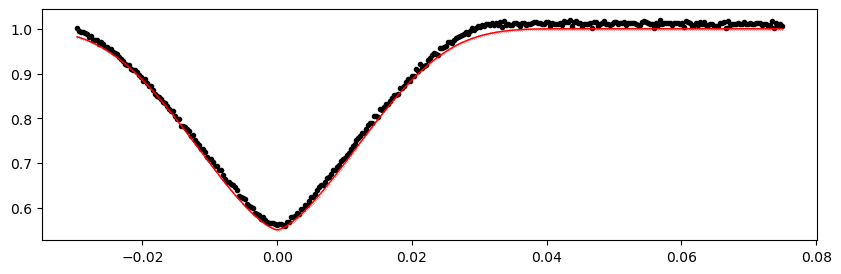

2300.164917 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.60it/s]


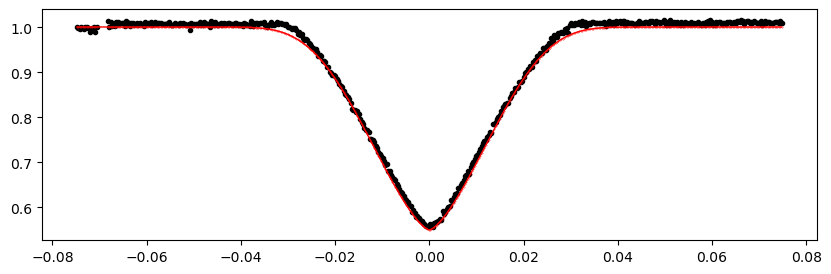

2304.854163 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1329.09it/s]


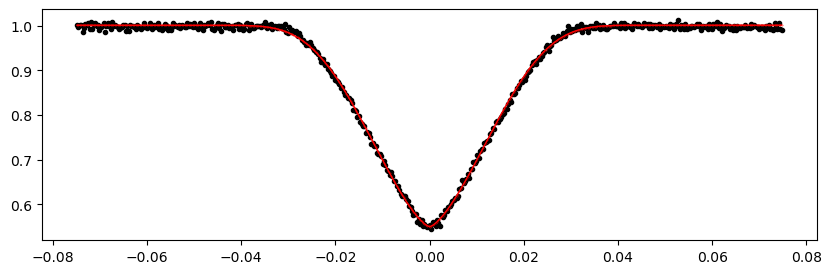

2309.543409 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.31it/s]


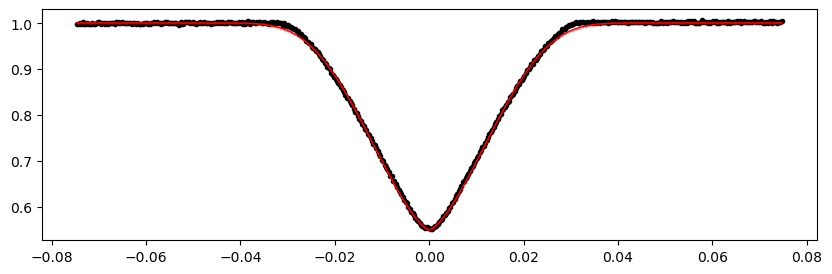

2314.232655 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.88it/s]


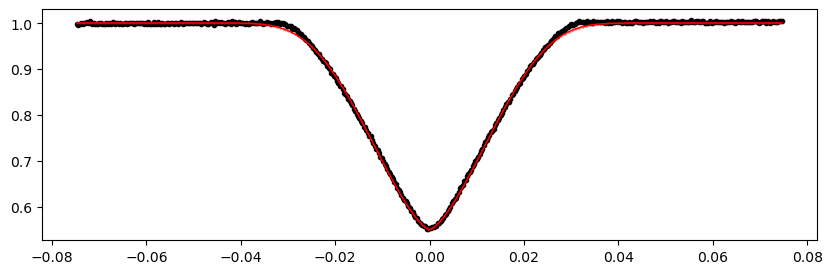

2318.9219009999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1316.69it/s]


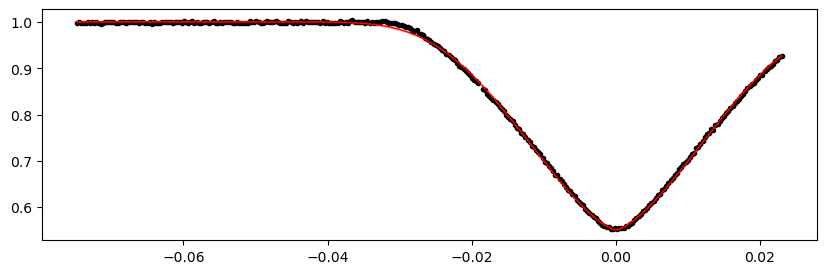

2323.6111469999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1321.04it/s]


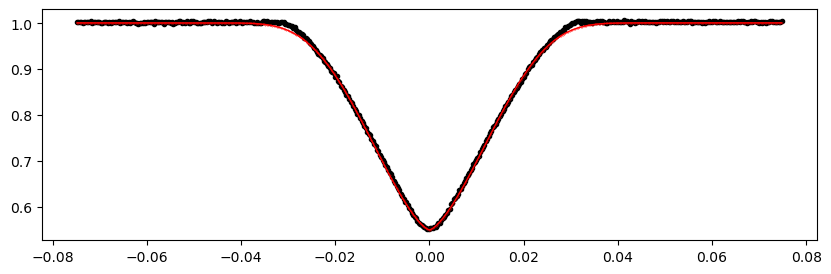

2328.300393 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.30it/s]


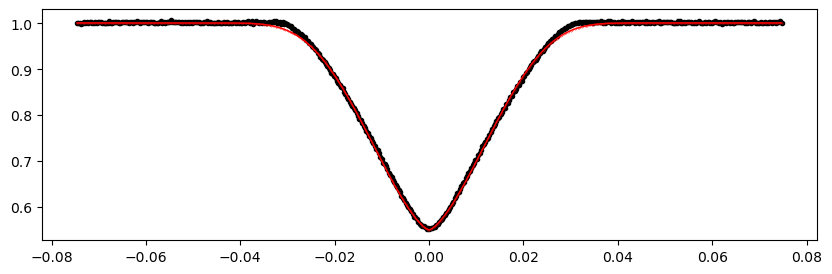

2337.678885 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.60it/s]


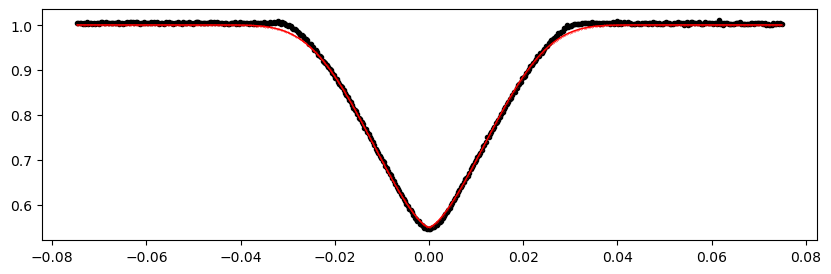

2342.3681309999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.57it/s]


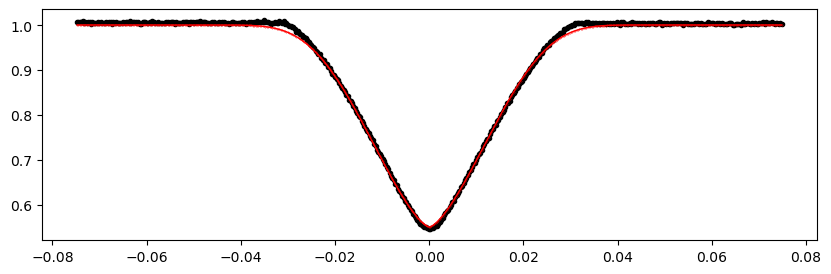

2351.746623 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.34it/s]


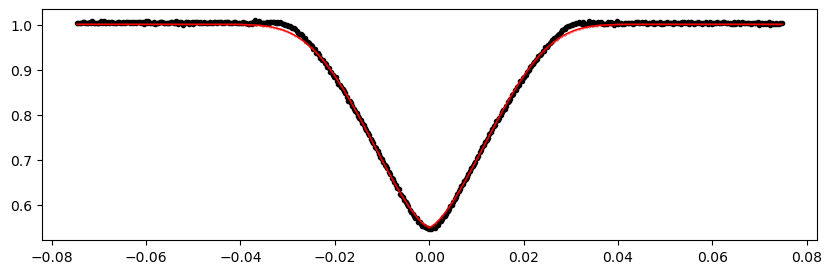

2356.435869 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.61it/s]


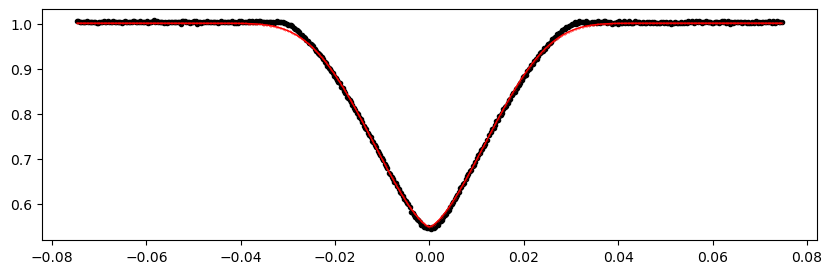

2365.8143609999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.59it/s]


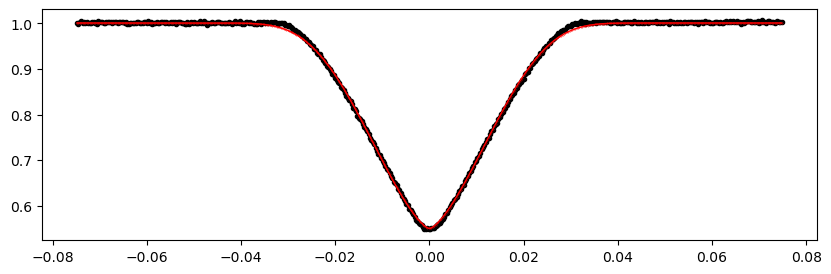

2370.5036069999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.30it/s]


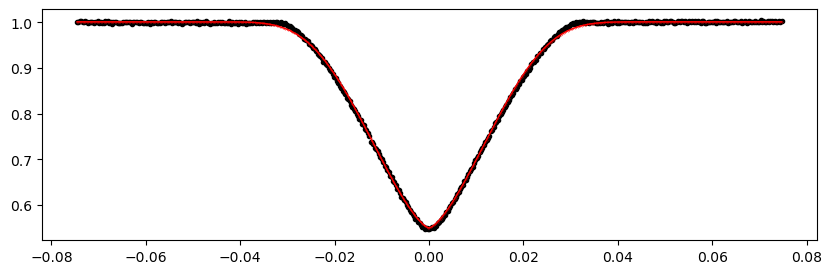

2379.882099 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1353.26it/s]


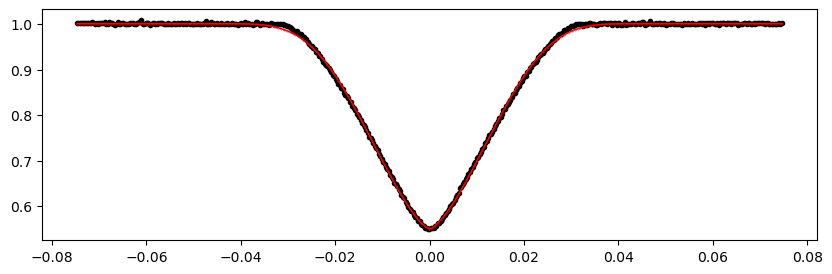

2384.571345 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.26it/s]


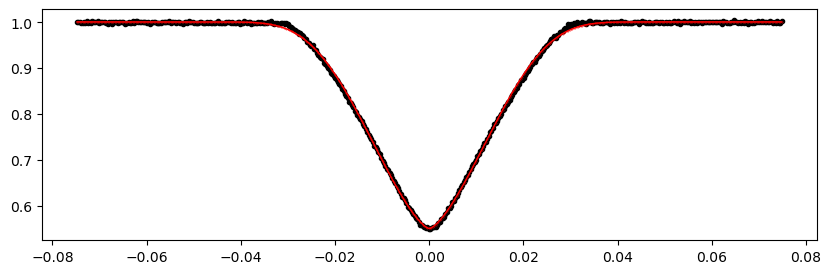

2389.2605909999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.91it/s]


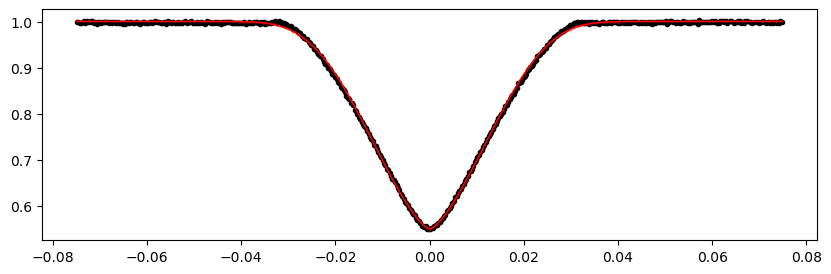

2966.037849 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.14it/s]


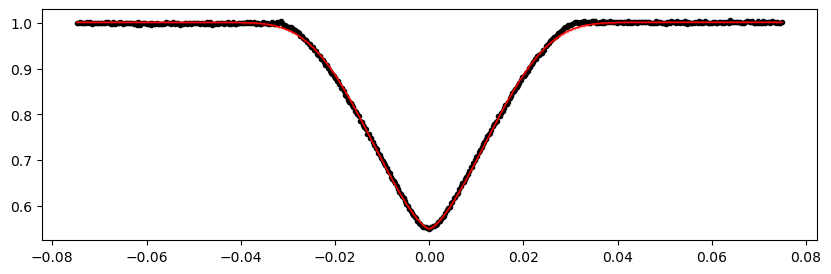

2970.7270949999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.51it/s]


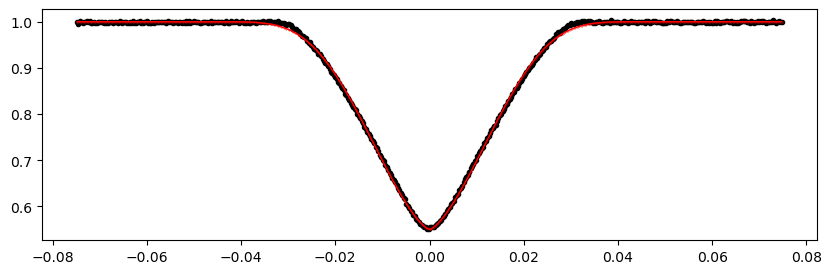

2980.105587 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.13it/s]


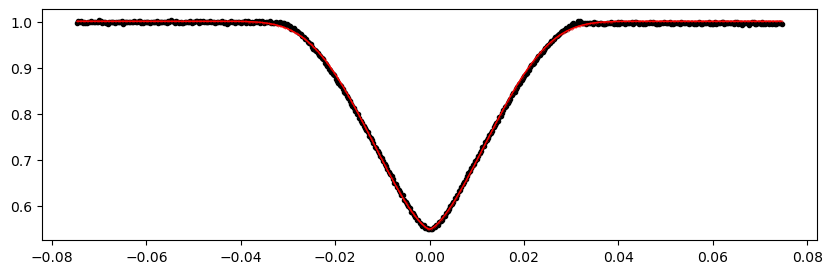

2984.794833 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.12it/s]


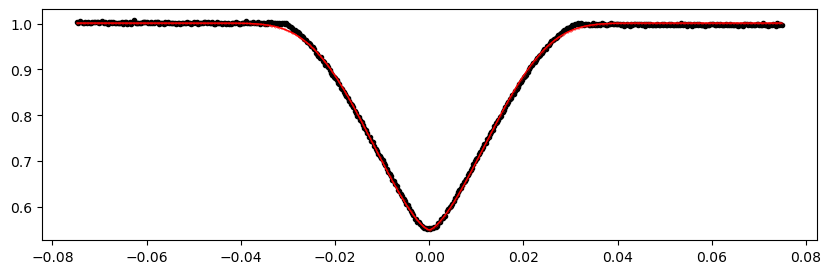

2994.1733249999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.12it/s]


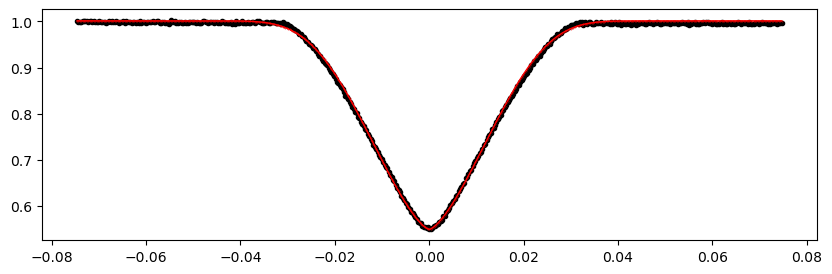

2998.8625709999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.21it/s]


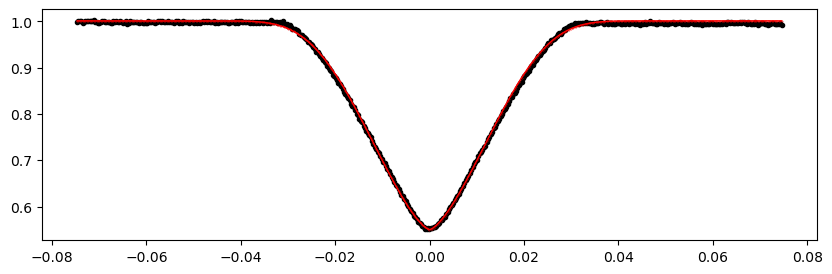

3003.5518169999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.24it/s]


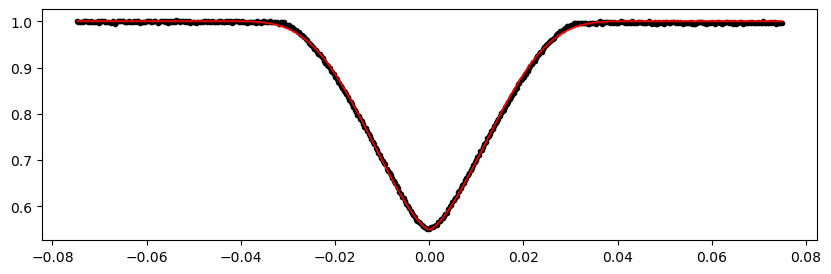

3008.2410629999995 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.58it/s]


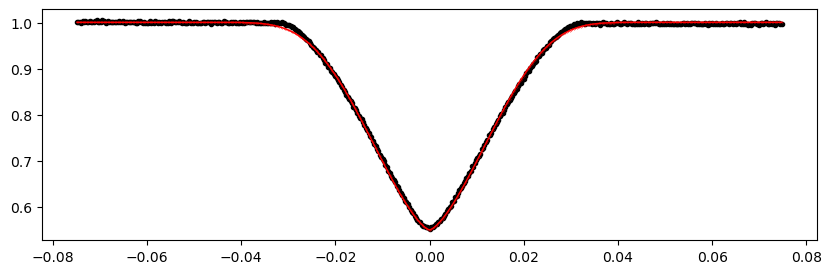

3012.930309 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.80it/s]


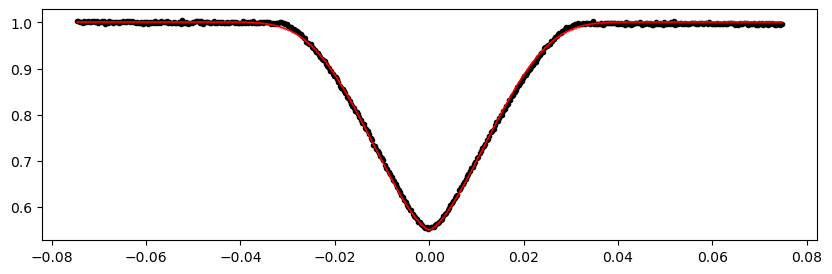

3017.6195549999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1325.32it/s]


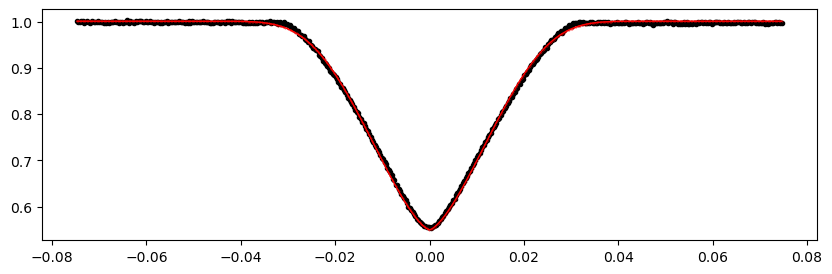

3022.308801 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1323.65it/s]


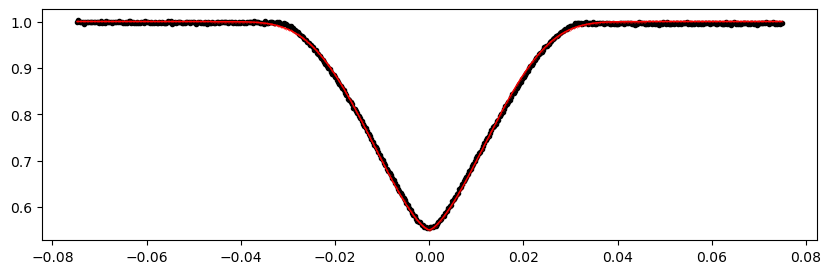

3026.998047 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1354.11it/s]


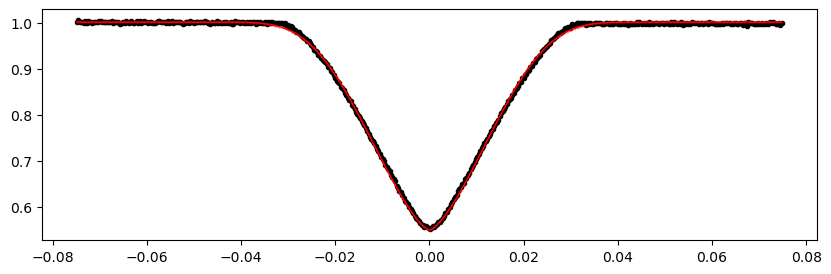

3031.687293 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.89it/s]


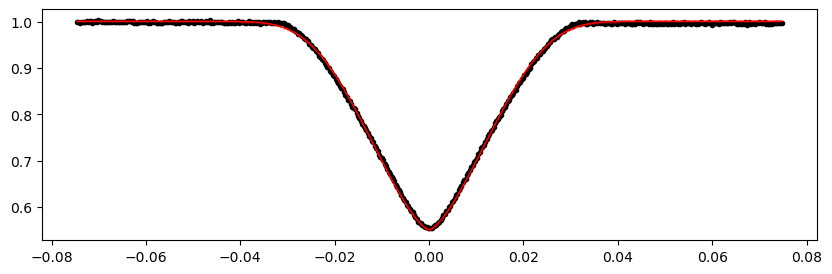

3036.376539 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.91it/s]


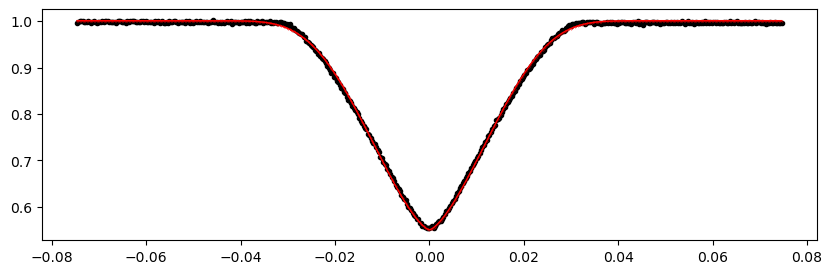

3041.065785 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.24it/s]


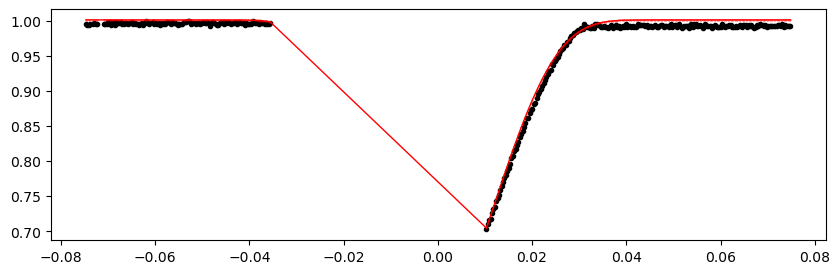

3045.7550309999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.17it/s]


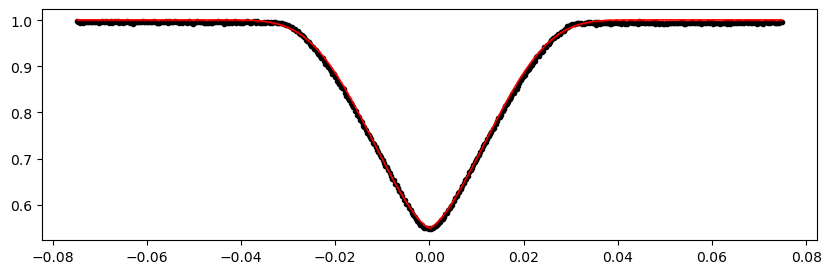

3050.4442769999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.87it/s]


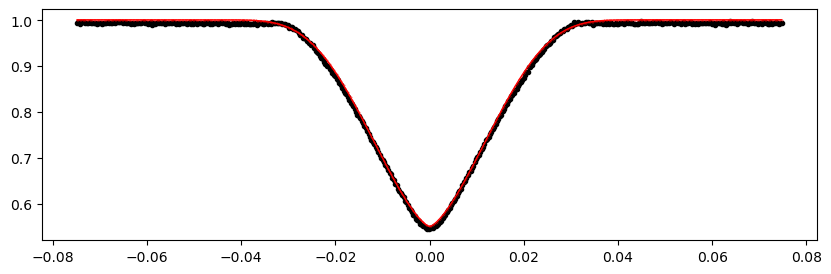

3055.1335229999995 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.88it/s]


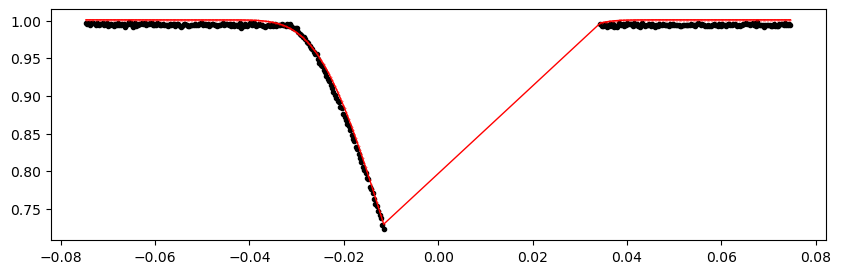

3059.822769 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.79it/s]


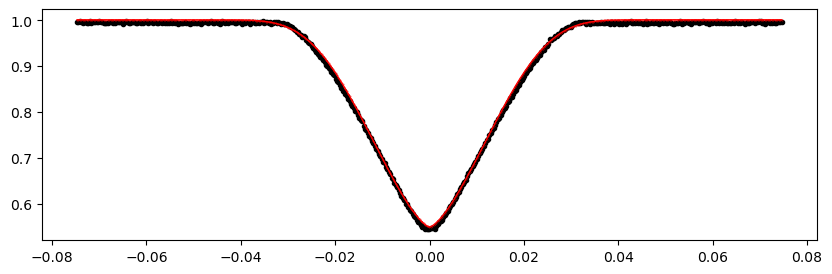

3064.512015 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.91it/s]


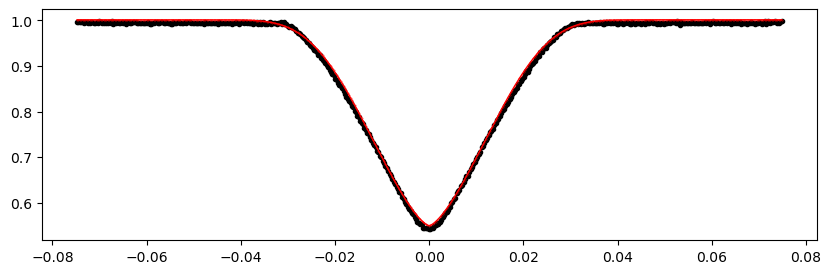

3069.201261 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.83it/s]


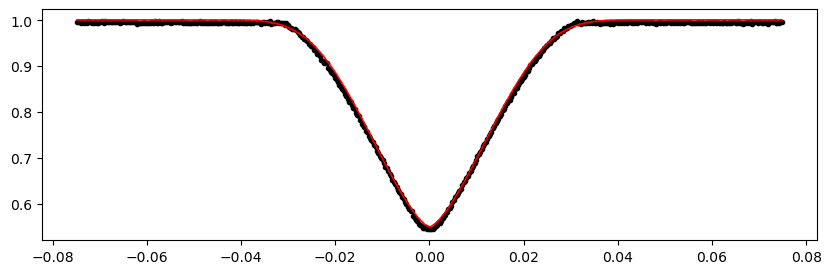

3073.890507 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.37it/s]


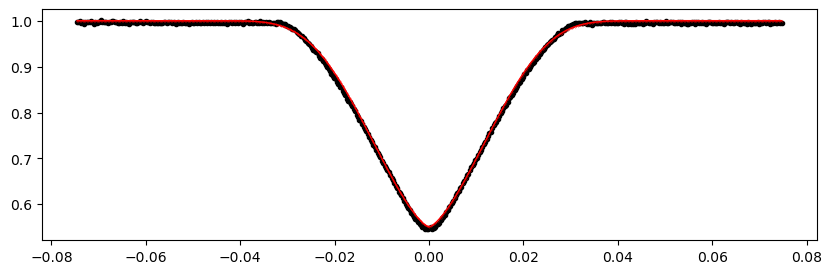

3078.579753 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.36it/s]


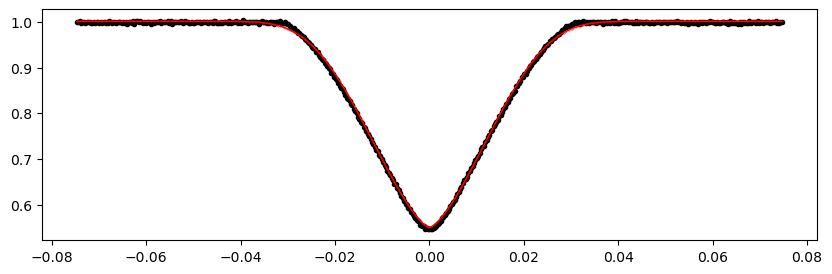

3083.268999 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.17it/s]


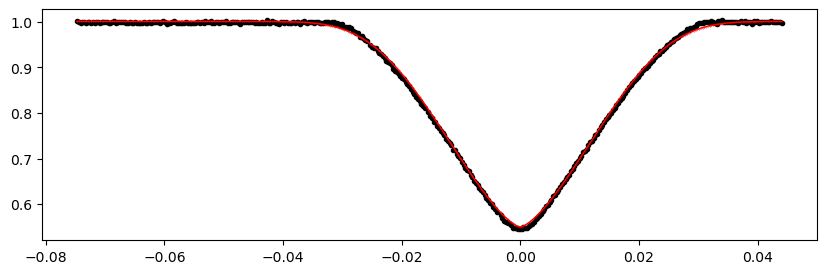

3087.958245 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.68it/s]


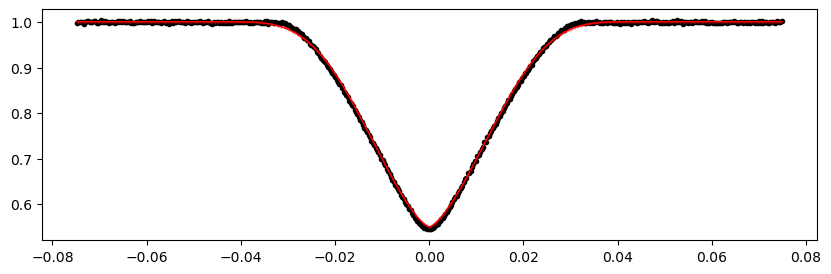

3092.6474909999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.43it/s]


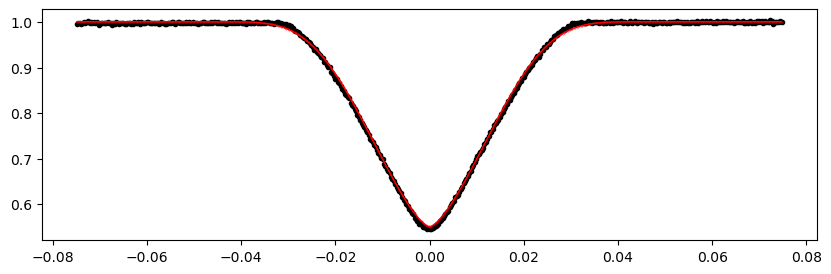

3102.0259829999995 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.65it/s]


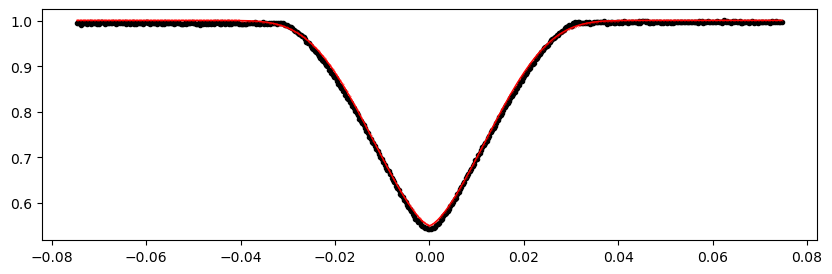

3106.715229 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.78it/s]


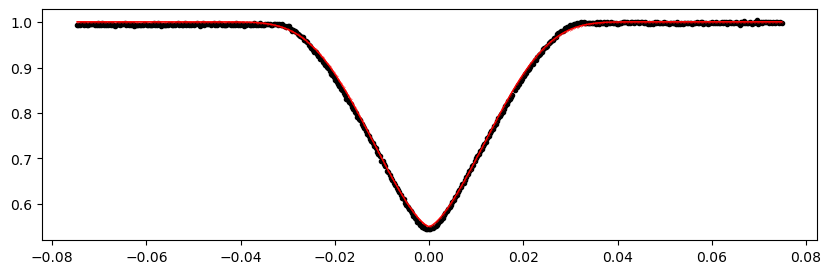

3111.404475 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.81it/s]


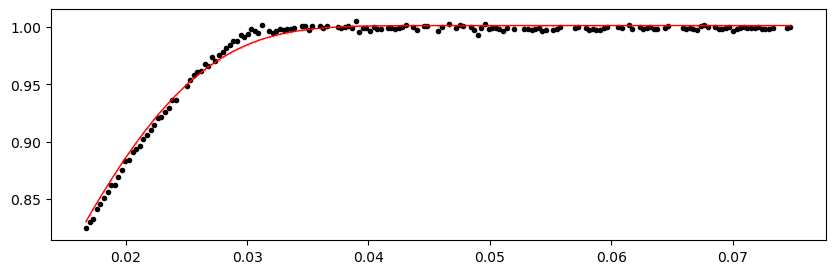

3116.0937209999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.90it/s]


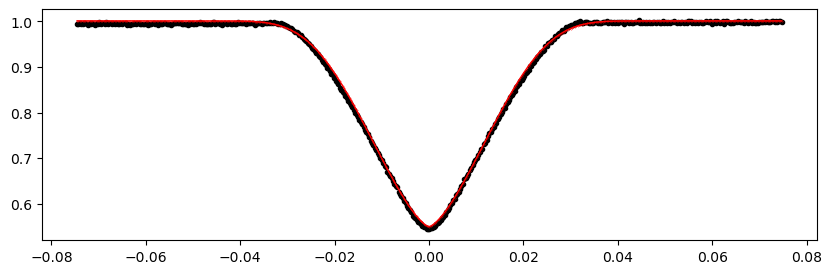

3120.782967 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1333.78it/s]


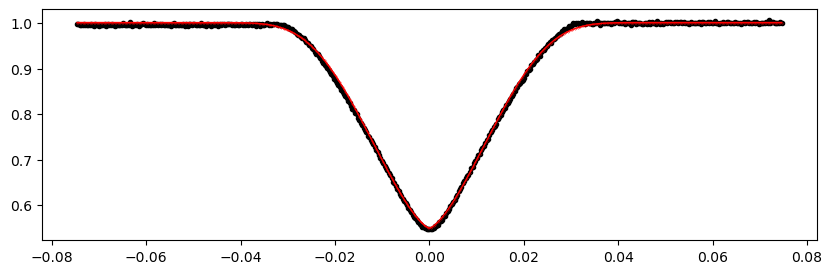

3130.161459 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.09it/s]


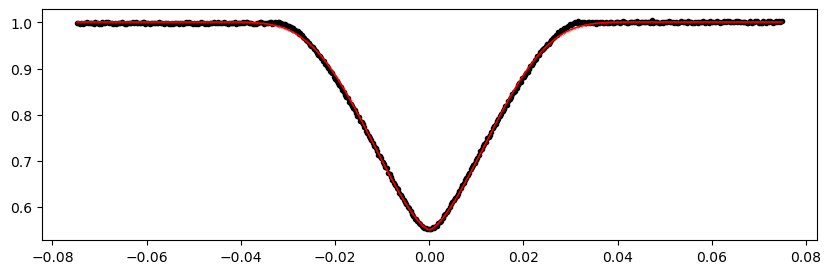

3134.850705 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1327.93it/s]


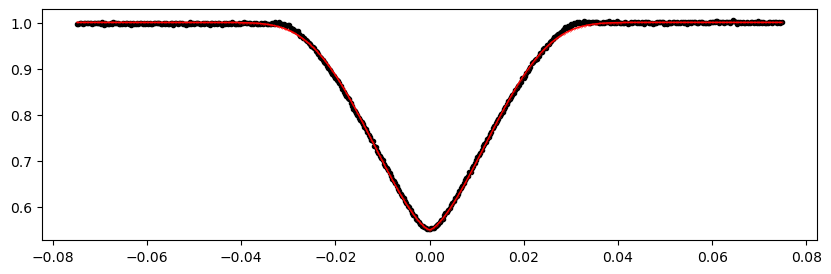

3144.2291969999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.68it/s]


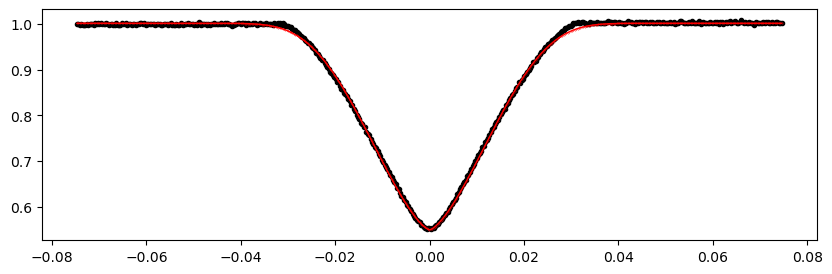

3148.9184429999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.77it/s]


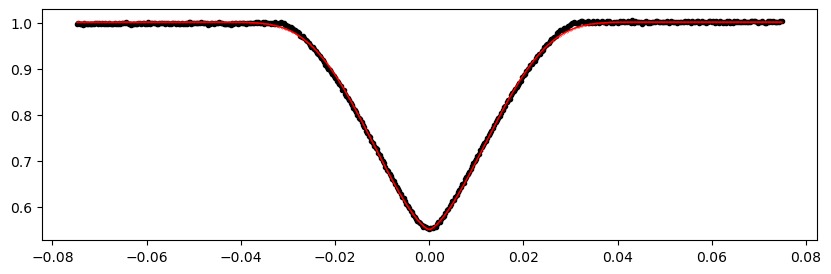

3158.296935 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.87it/s]


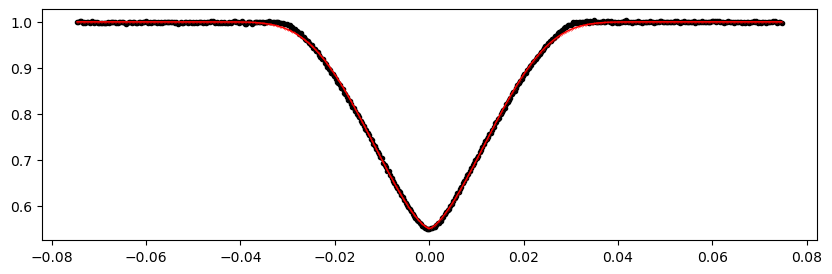

3162.9861809999998 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.32it/s]


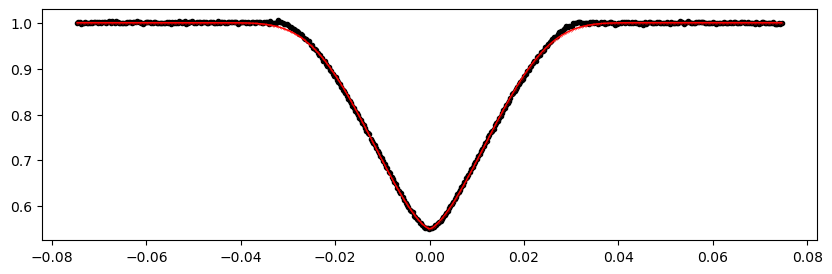

3172.364673 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.33it/s]


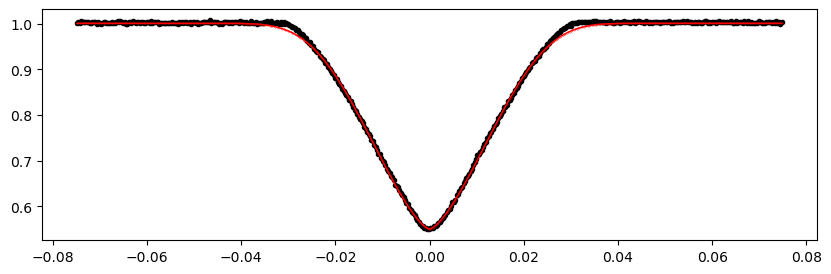

3177.053919 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.82it/s]


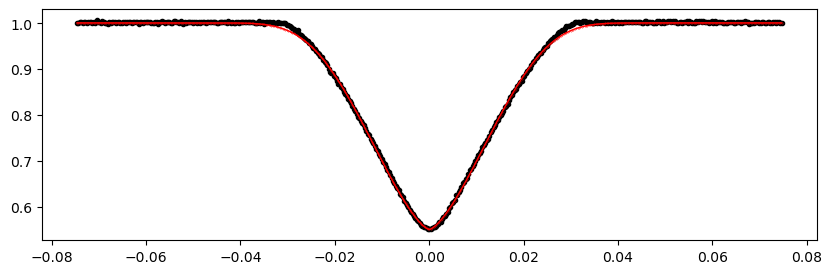

3186.432411 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.81it/s]


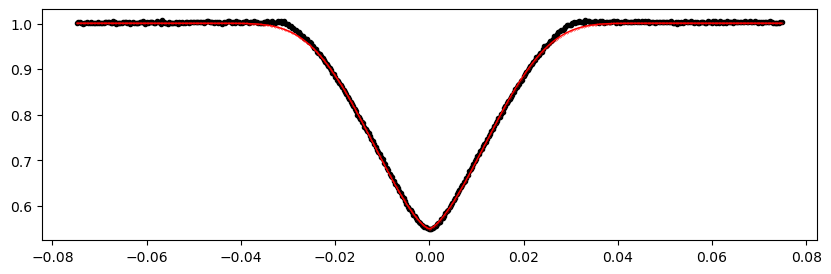

3191.1216569999997 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1351.62it/s]


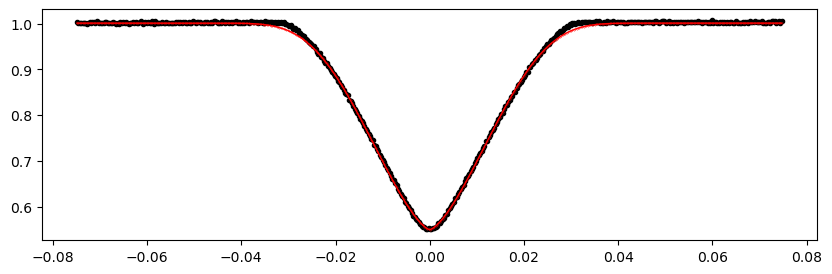

3195.8109029999996 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.96it/s]


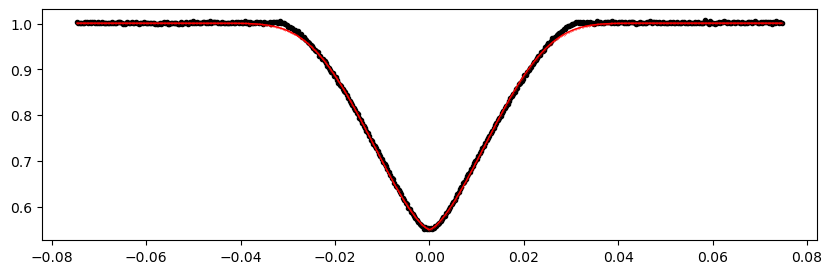

3200.5001489999995 1.0011142495421985 -0.4510105175356701 0.12499719178254205


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.49it/s]


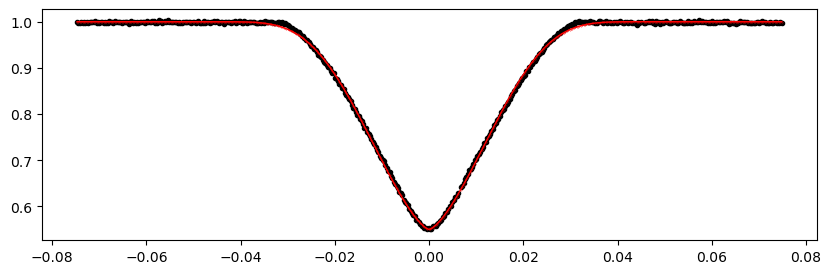

In [47]:
%matplotlib inline

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path)
!$NOTIFY_CMD "Individual primary eclipses fit done"

Fitting individual secondary eclipses...
Creating new manifest file
1411.5528 1.0013589390322668 -0.452358403656157 -0.37500037502926503


  0%|                                                                    | 0/10000 [00:00<?, ?it/s]C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1322.81it/s]


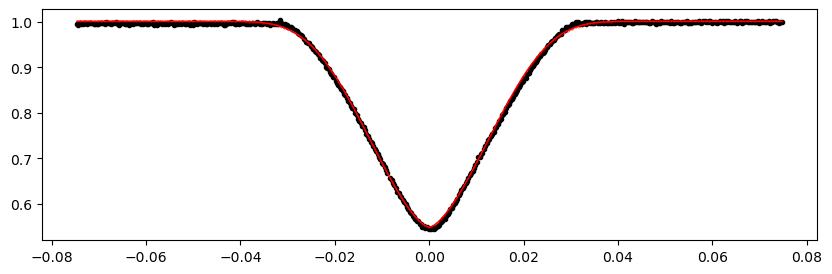

1416.2420459999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.70it/s]


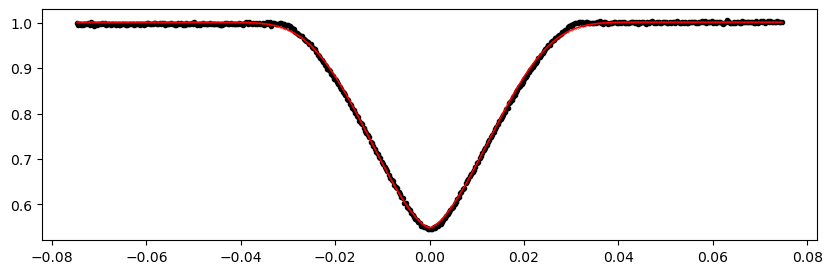

1420.931292 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.51it/s]


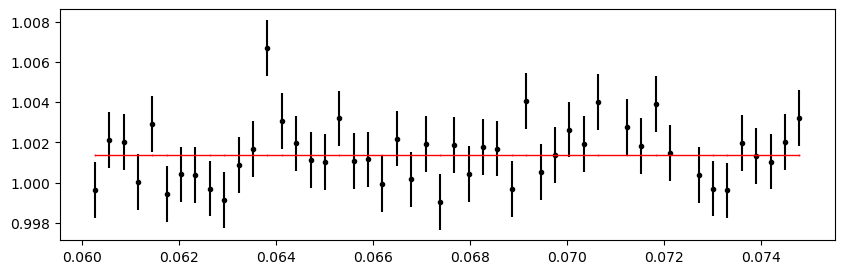

1425.620538 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.33it/s]


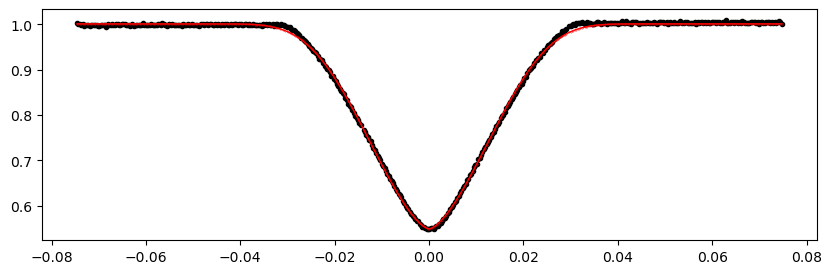

1430.309784 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.88it/s]


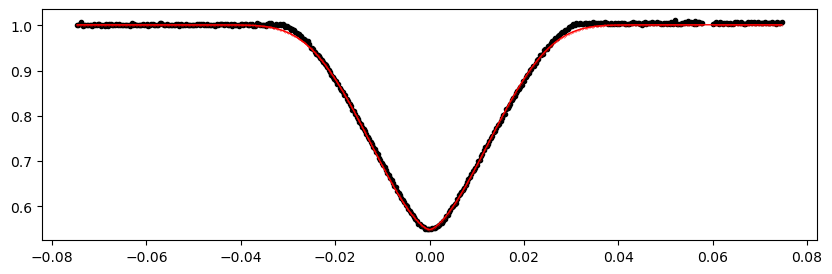

1434.99903 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.87it/s]


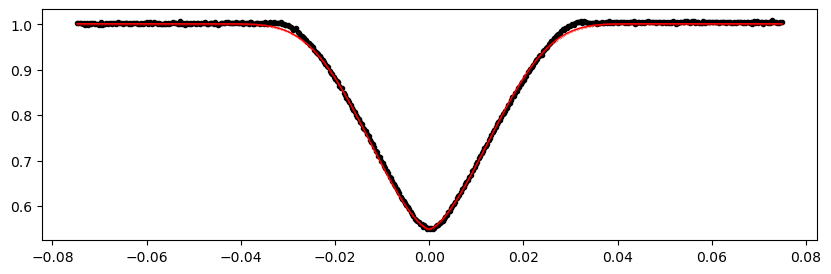

1439.6882759999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.38it/s]


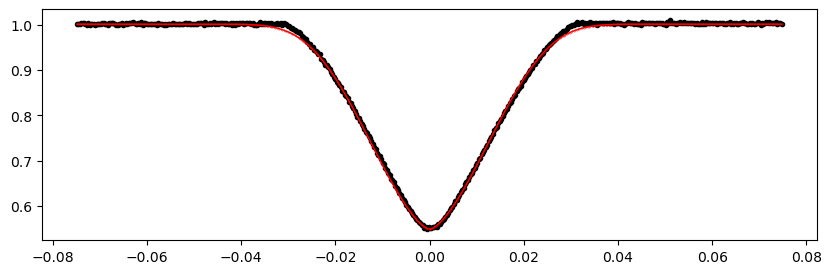

1444.377522 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.17it/s]


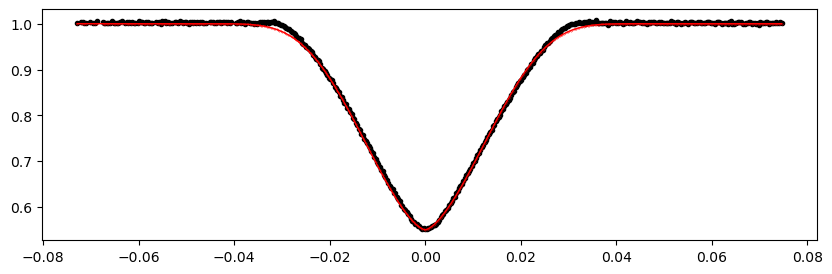

1449.066768 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.76it/s]


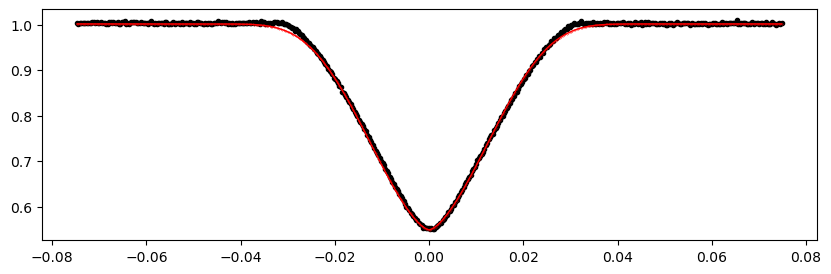

1453.7560139999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.48it/s]


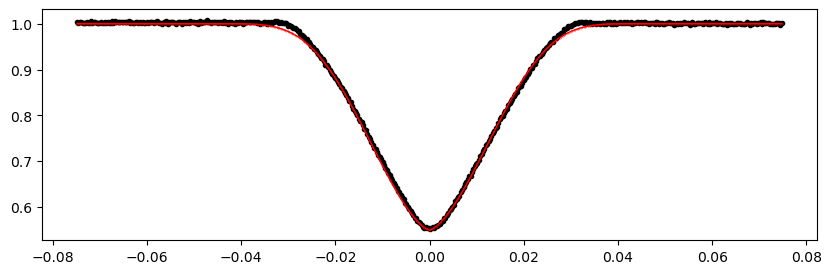

1458.44526 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.40it/s]


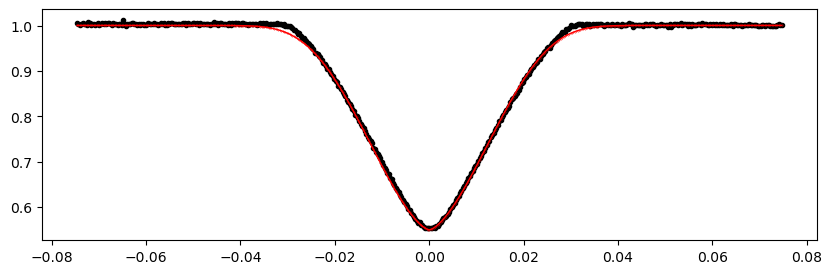

1463.1345059999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.32it/s]


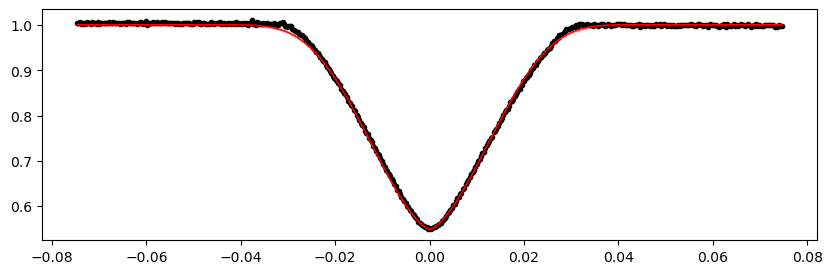

1472.512998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.86it/s]


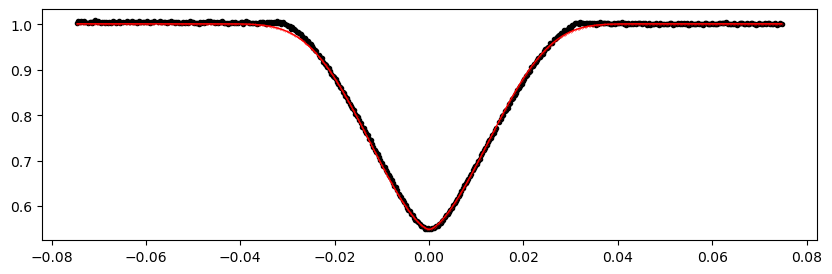

1477.2022439999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.74it/s]


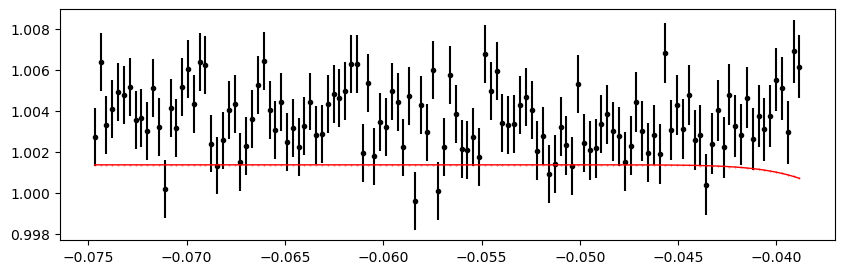

1481.89149 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.35it/s]


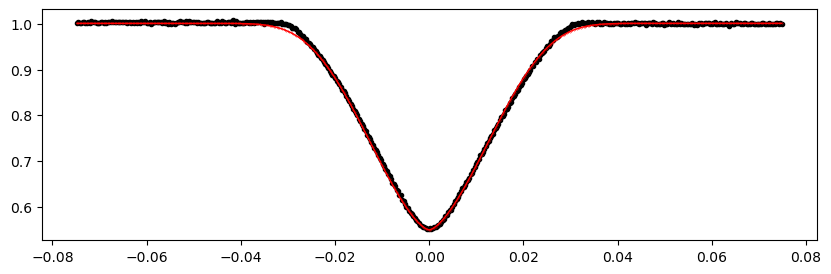

1486.580736 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.65it/s]


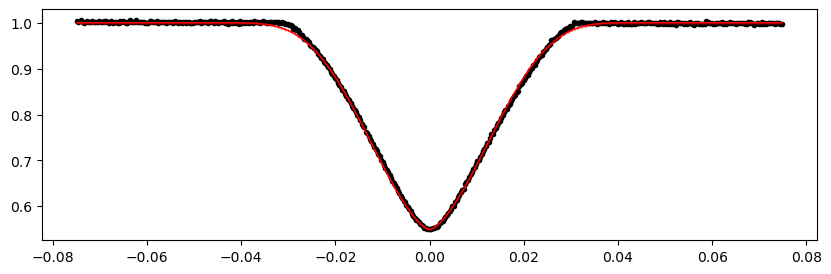

1495.959228 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.47it/s]


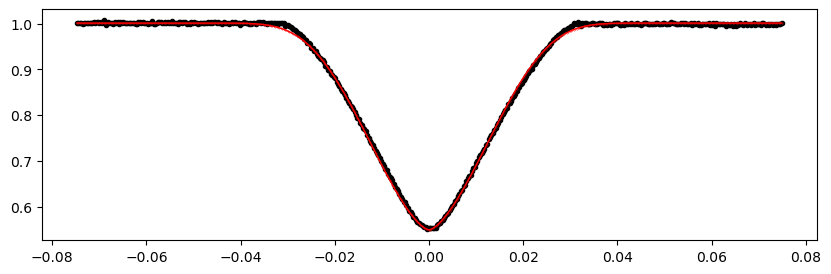

1500.6484739999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.94it/s]


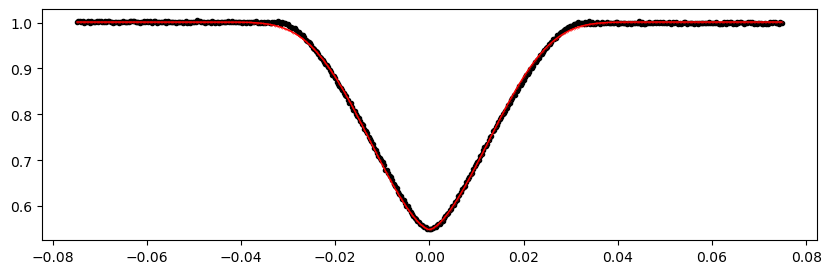

1505.33772 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.60it/s]


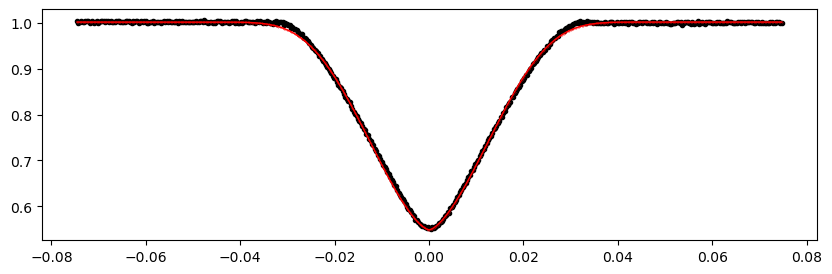

1510.026966 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.14it/s]


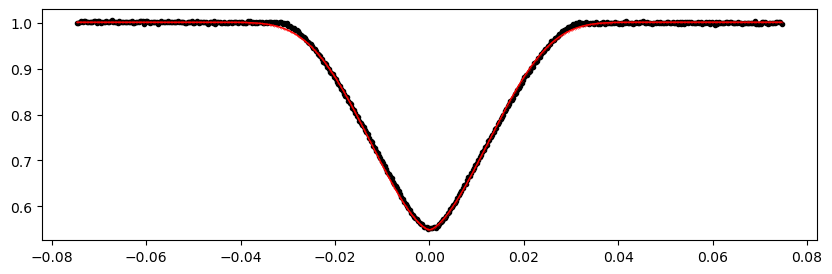

1514.7162119999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1320.99it/s]


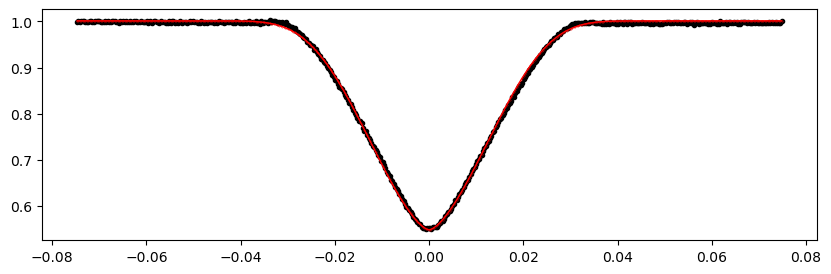

1519.405458 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1307.06it/s]


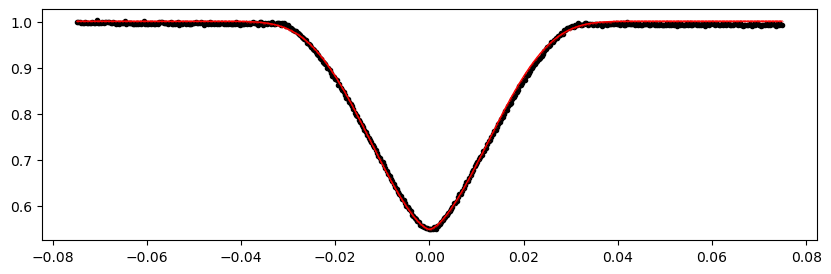

1524.0947039999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.43it/s]


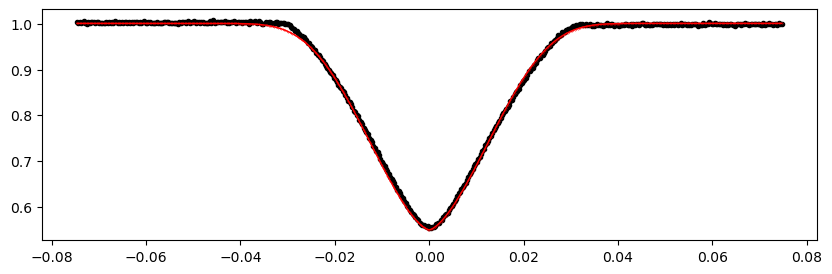

1528.78395 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.33it/s]


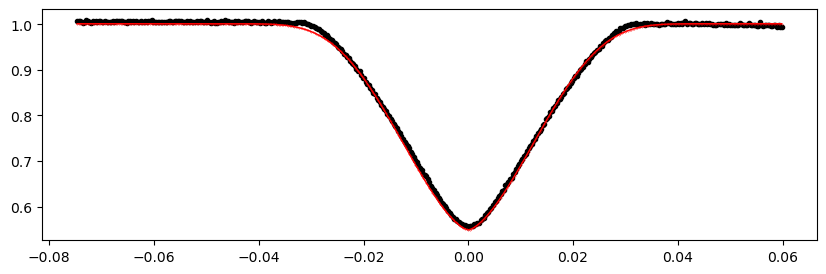

1538.1624419999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.22it/s]


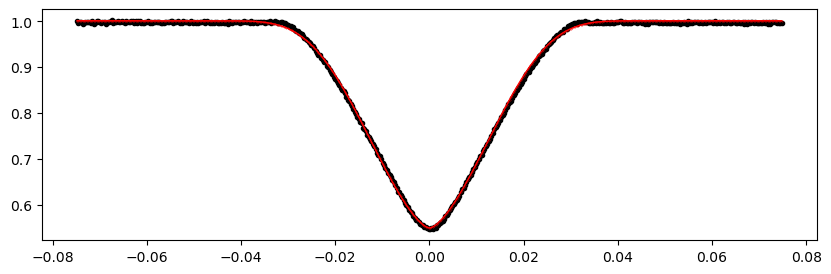

1547.5409339999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.86it/s]


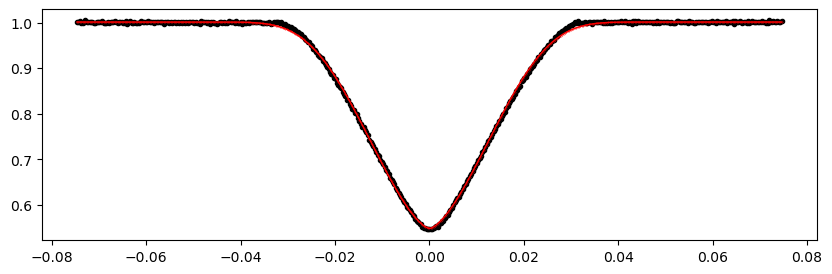

1552.23018 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1316.96it/s]


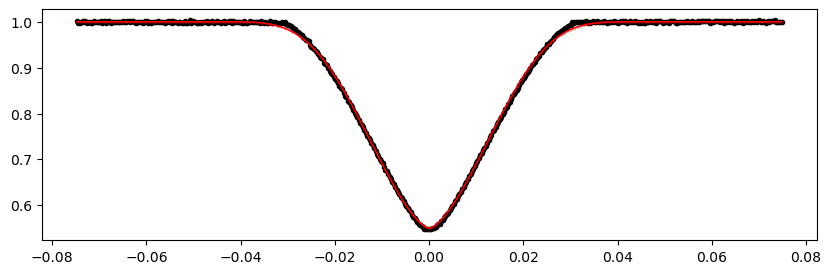

1561.6086719999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.01it/s]


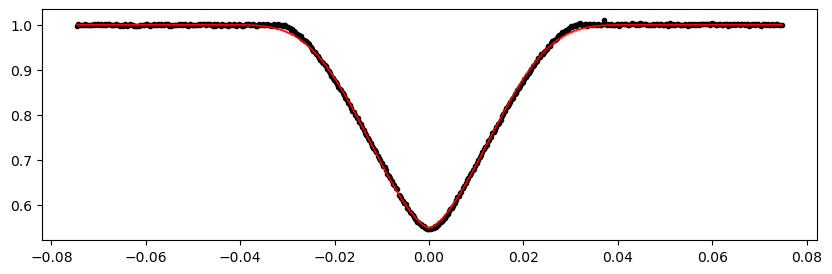

1566.297918 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.66it/s]


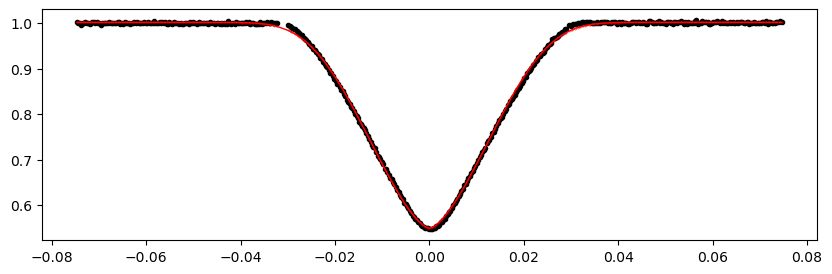

1575.67641 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1275.86it/s]


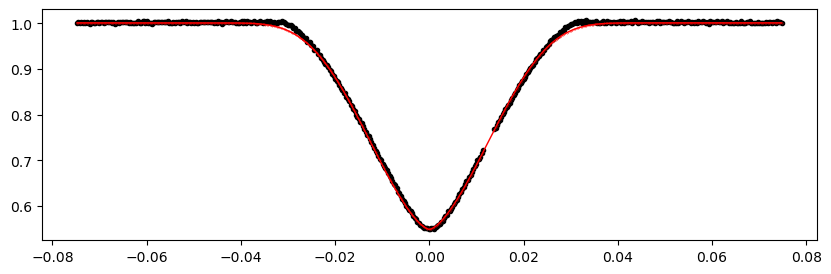

1580.365656 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.96it/s]


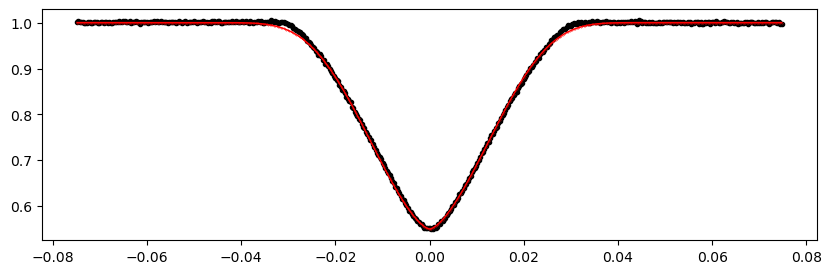

1589.744148 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.30it/s]


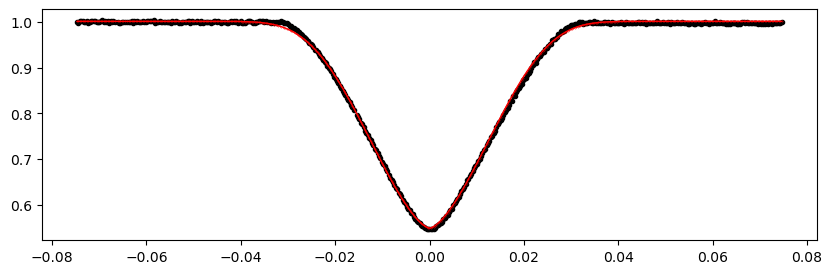

1594.433394 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.80it/s]


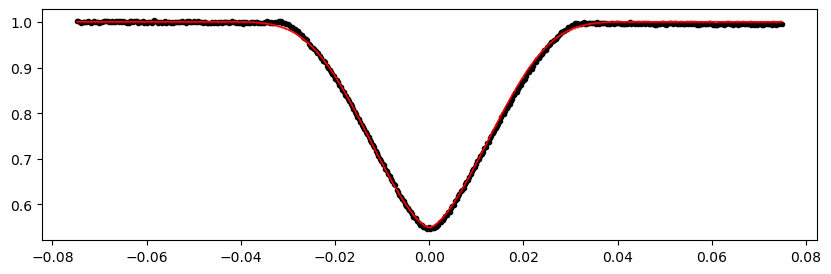

1631.9473619999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.76it/s]


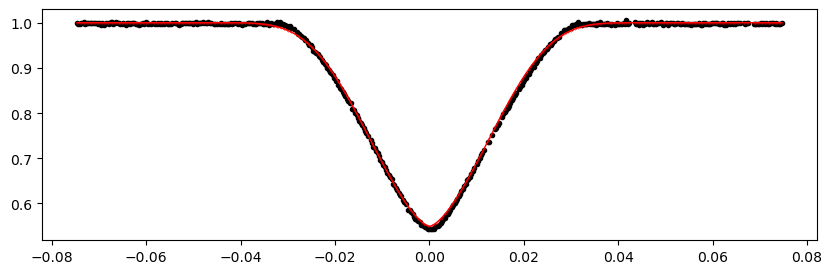

1636.6366079999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1331.22it/s]


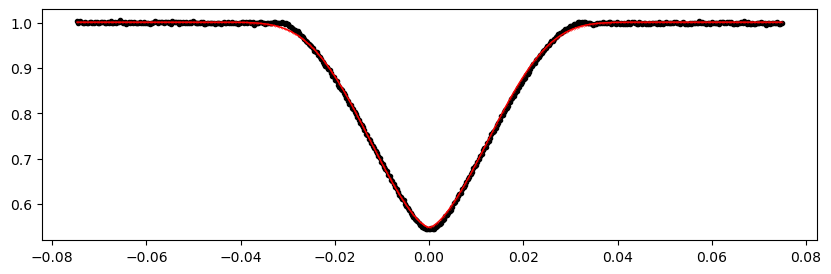

1646.0150999999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.30it/s]


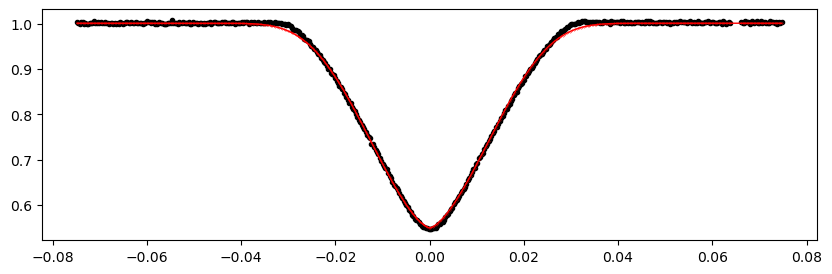

1650.704346 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.64it/s]


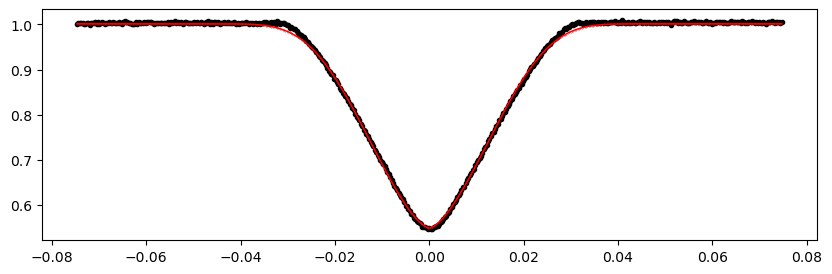

1655.393592 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.47it/s]


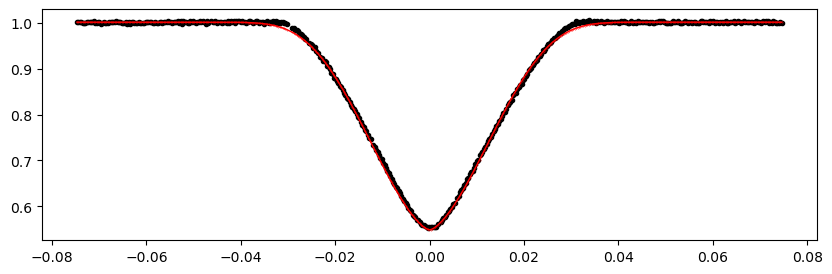

1660.0828379999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.53it/s]


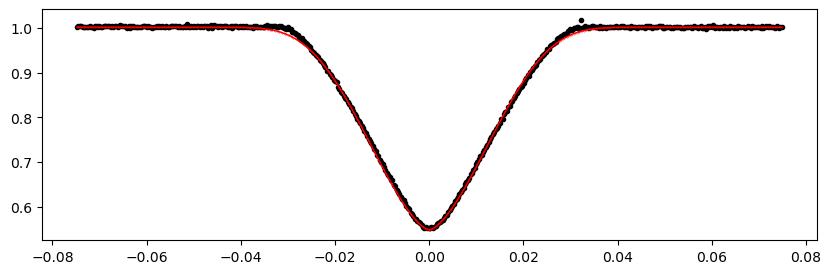

1664.772084 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.22it/s]


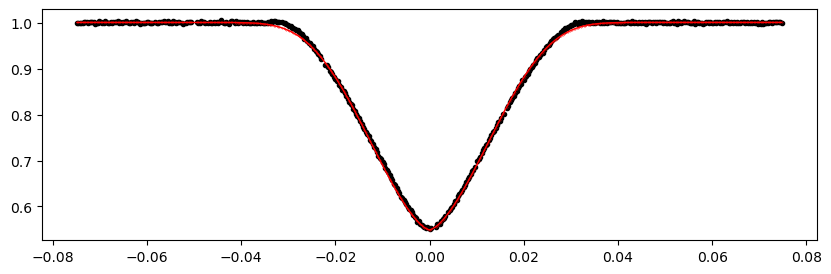

1669.4613299999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.44it/s]


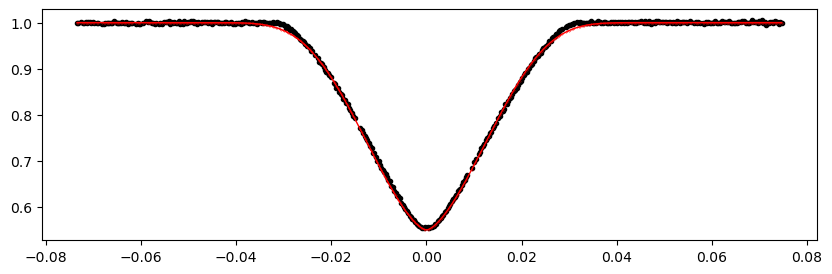

1674.150576 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.91it/s]


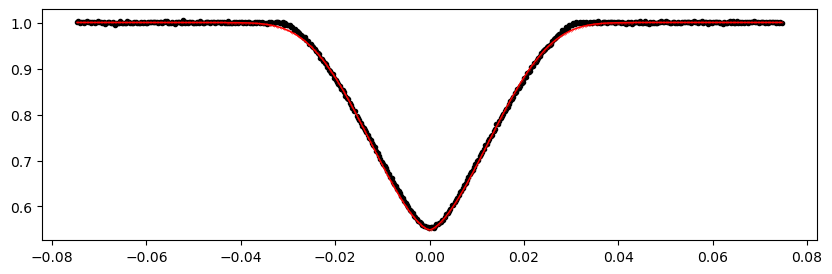

1678.839822 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.39it/s]


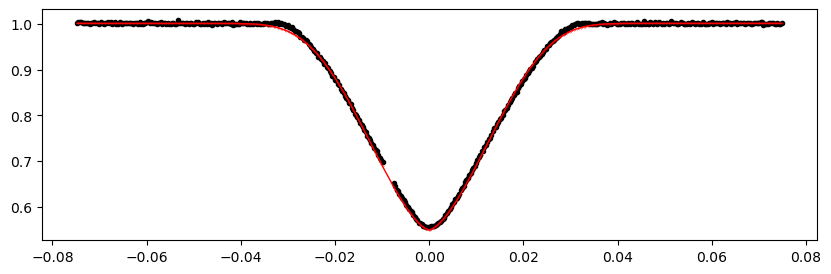

2039.911764 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.55it/s]


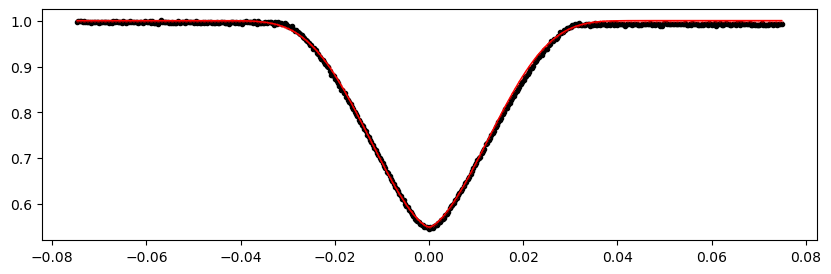

2044.6010099999999 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.21it/s]


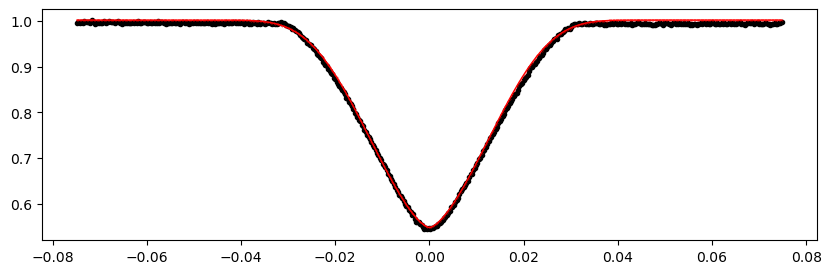

2049.2902559999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.81it/s]


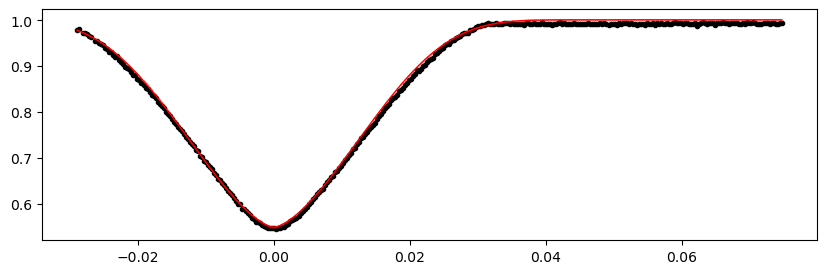

2053.979502 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.01it/s]


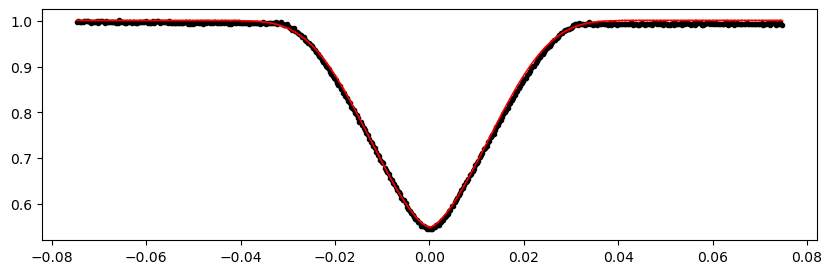

2058.668748 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.16it/s]


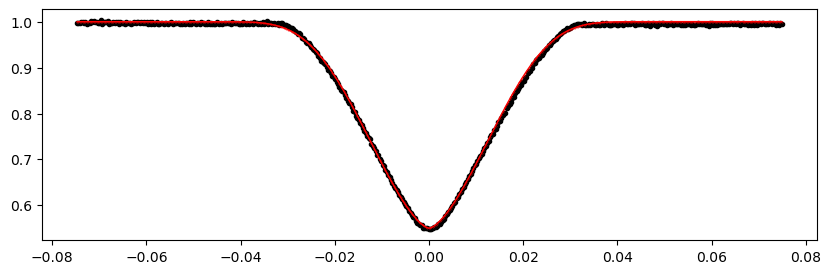

2091.49347 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.66it/s]


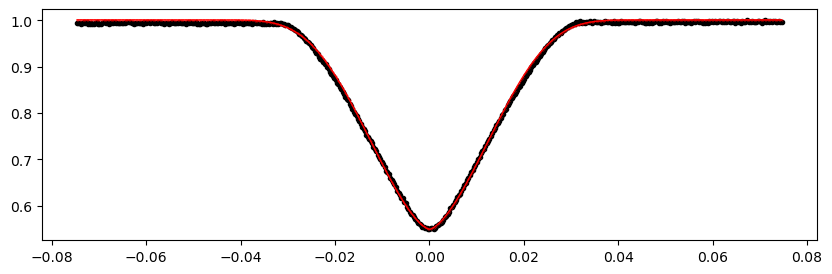

2096.182716 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.89it/s]


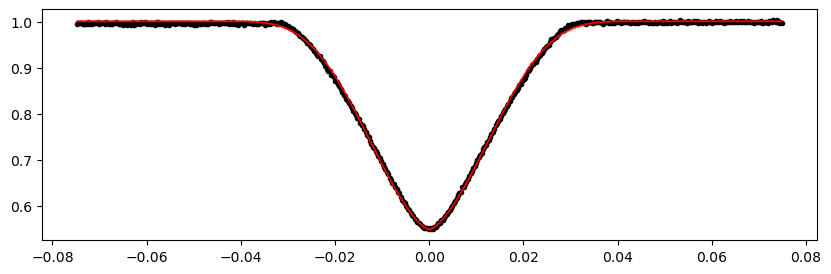

2105.561208 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.16it/s]


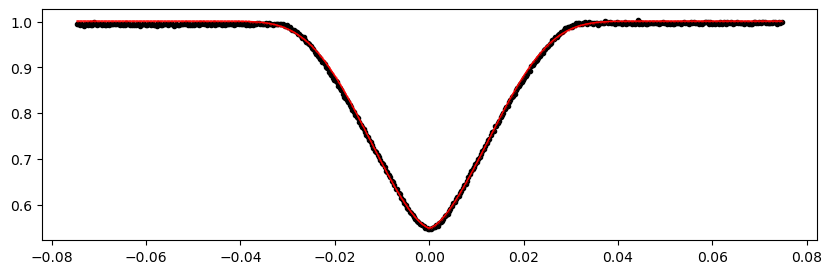

2110.250454 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1328.06it/s]


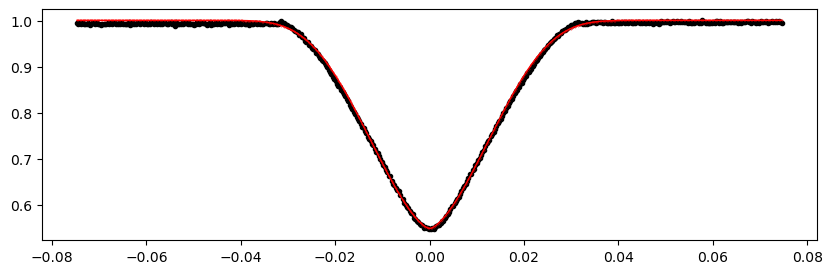

2119.628946 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.90it/s]


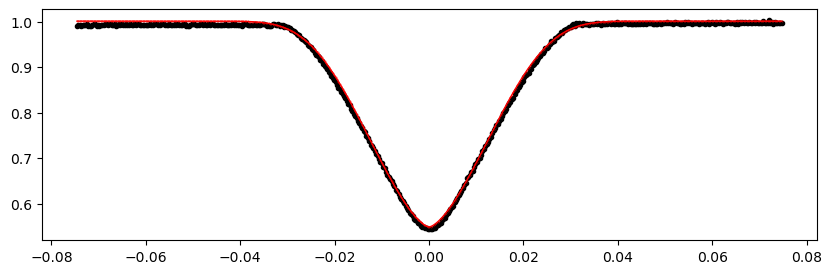

2124.3181919999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1330.80it/s]


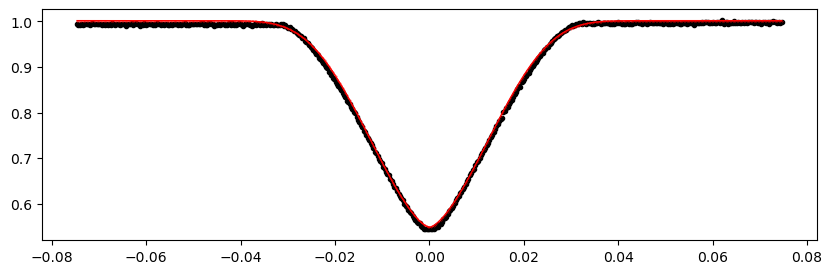

2133.696684 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1332.48it/s]


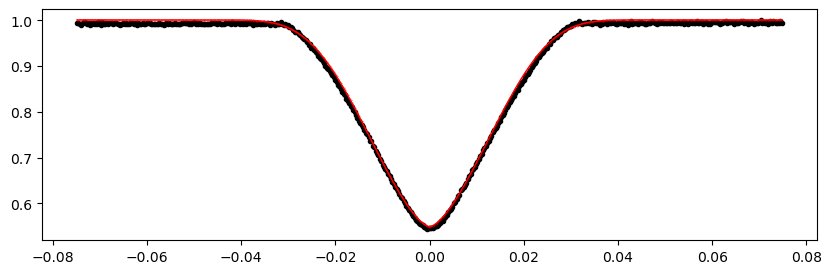

2138.38593 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.97it/s]


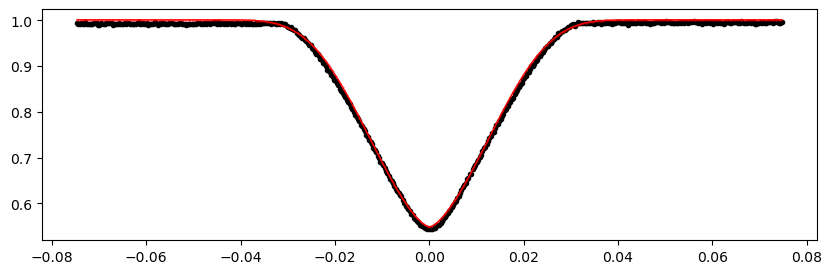

2147.7644219999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.34it/s]


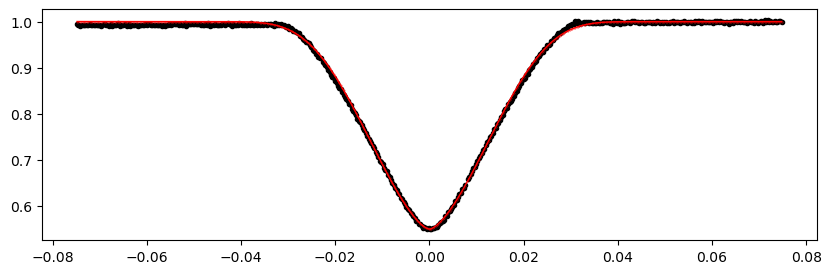

2152.453668 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.91it/s]


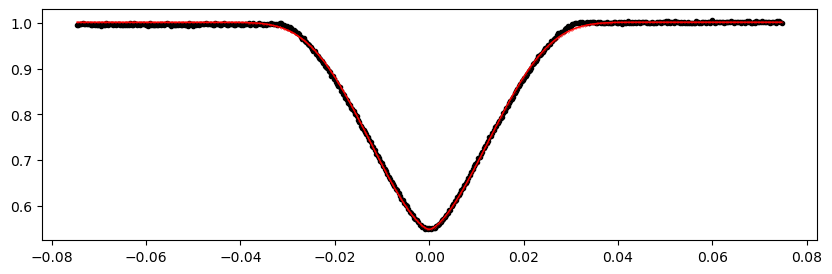

2161.83216 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.58it/s]


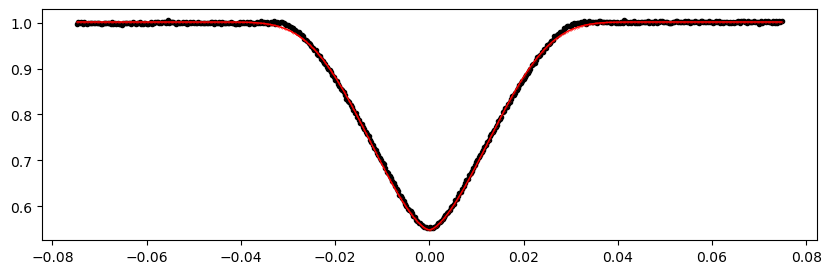

2166.521406 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.66it/s]


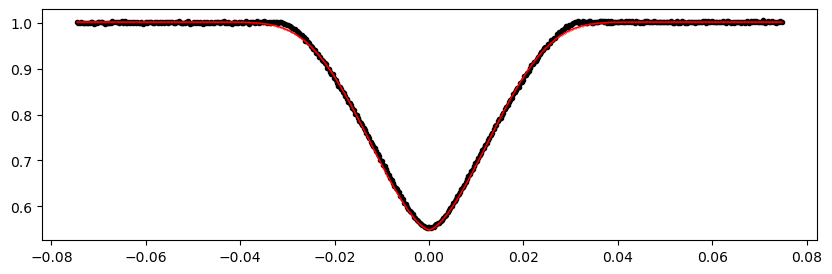

2175.8998979999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.73it/s]


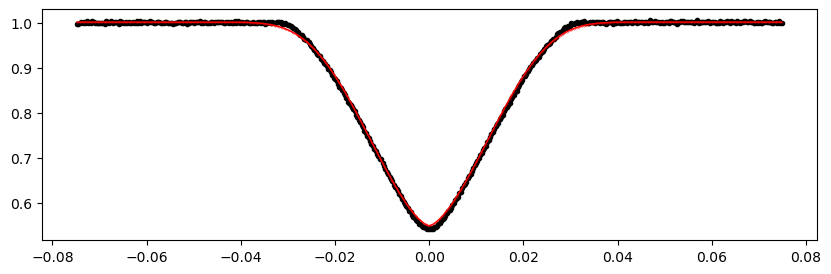

2180.589144 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.15it/s]


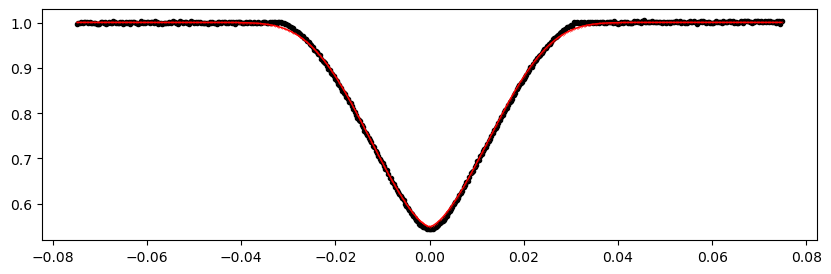

2185.27839 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.90it/s]


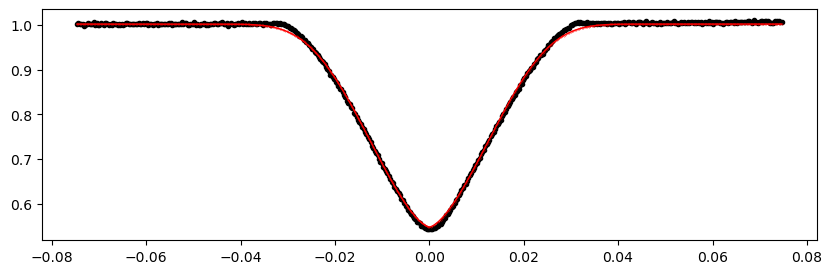

2189.967636 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.58it/s]


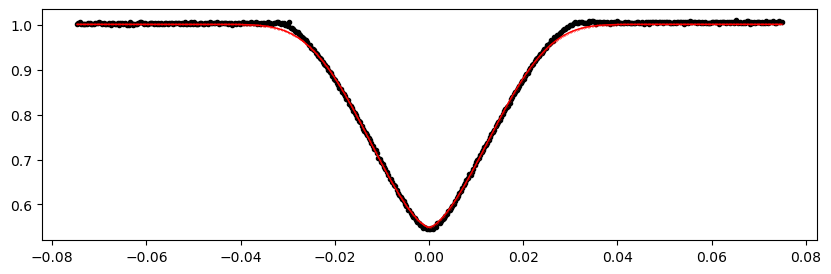

2194.6568819999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.83it/s]


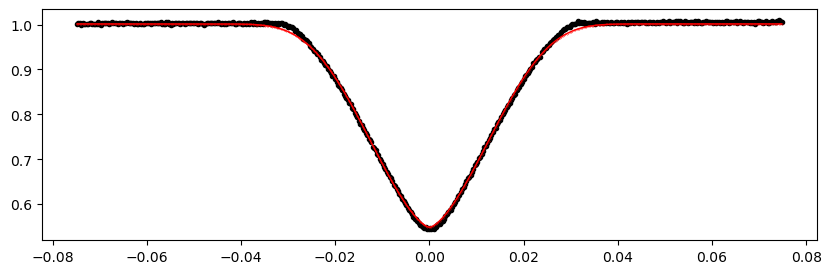

2199.346128 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.67it/s]


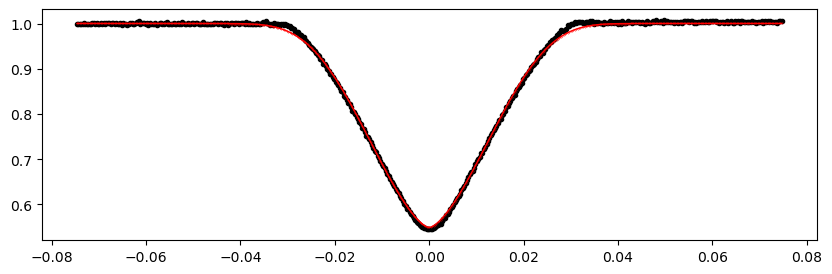

2204.035374 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.77it/s]


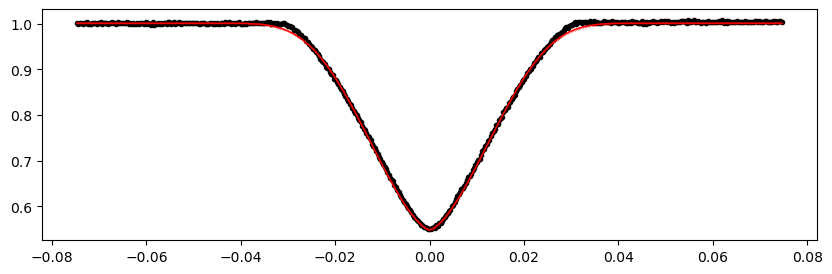

2208.72462 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.71it/s]


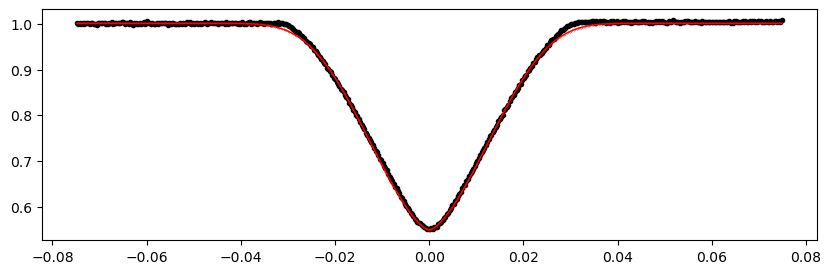

2213.413866 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.44it/s]


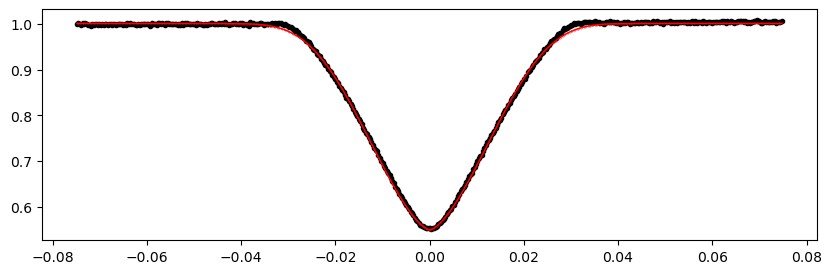

2218.103112 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.58it/s]


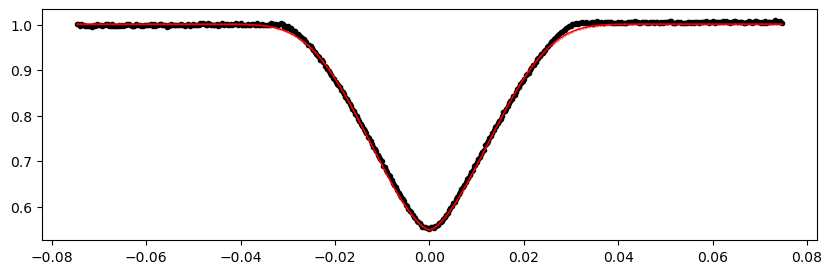

2222.7923579999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.02it/s]


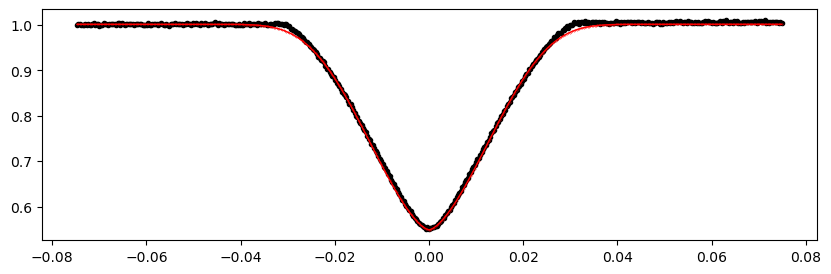

2227.481604 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.53it/s]


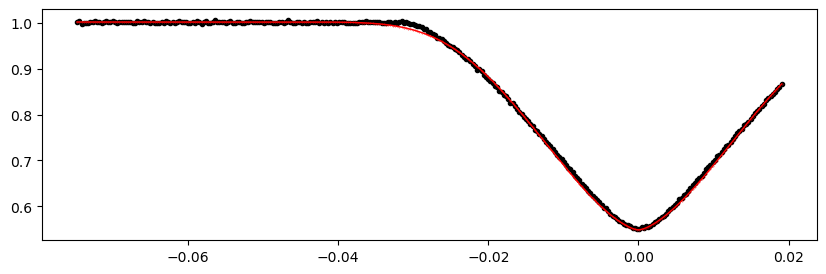

2232.17085 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.68it/s]


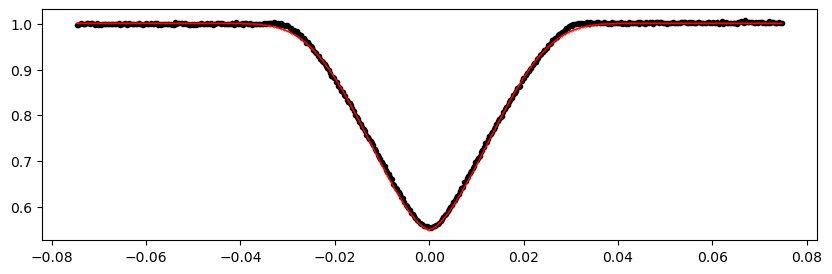

2236.860096 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1343.20it/s]


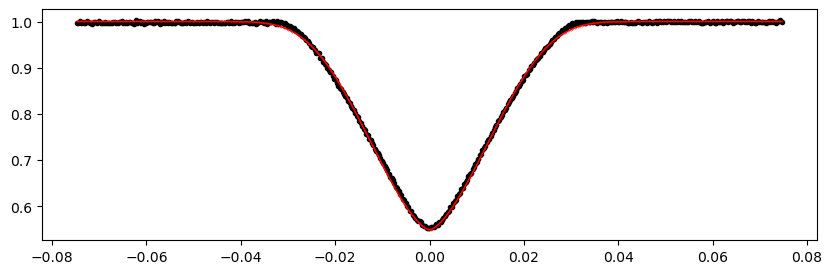

2246.238588 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.64it/s]


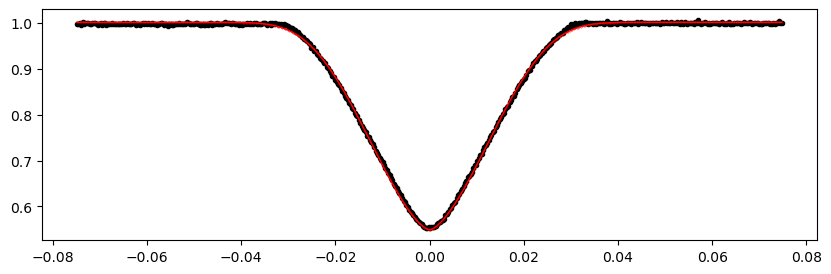

2250.927834 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.77it/s]


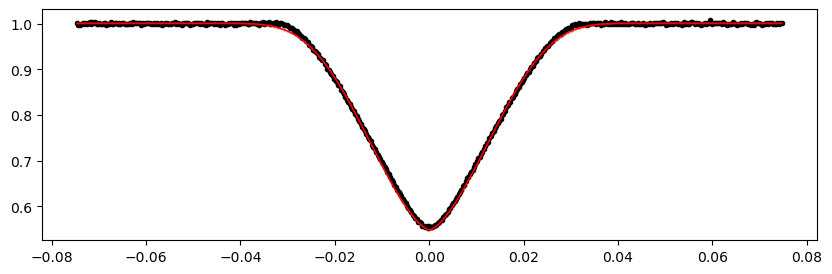

2255.61708 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.58it/s]


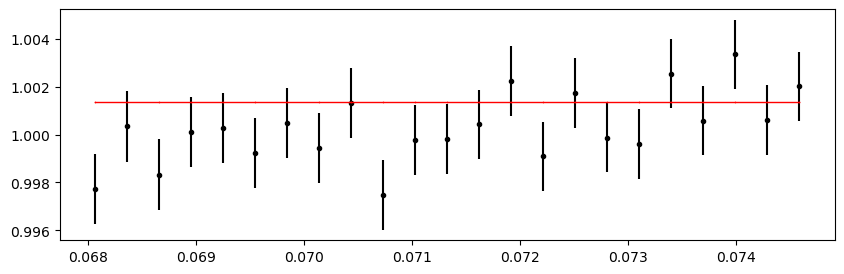

2260.306326 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.22it/s]


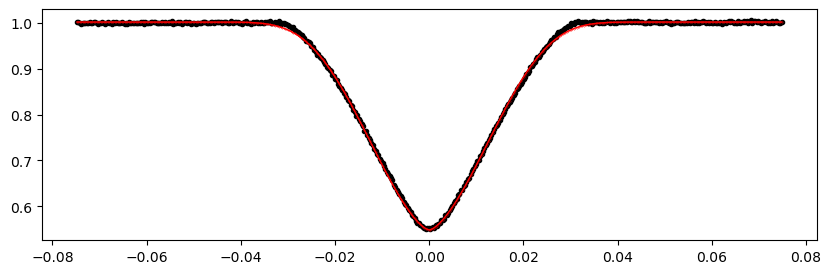

2264.995572 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.85it/s]


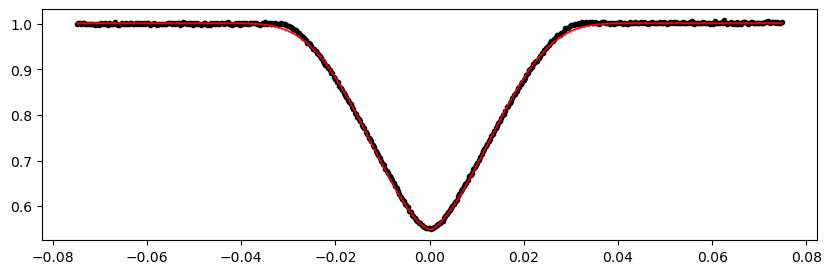

2274.3740639999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.75it/s]


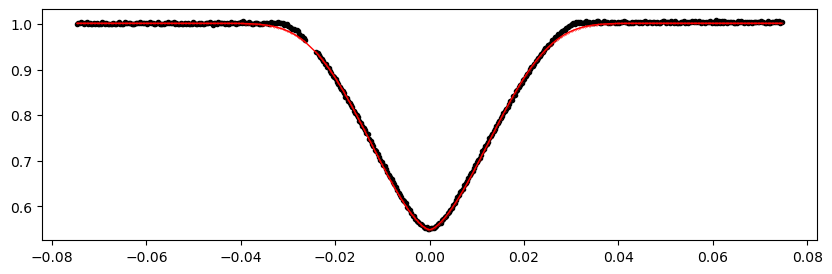

2279.06331 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.77it/s]


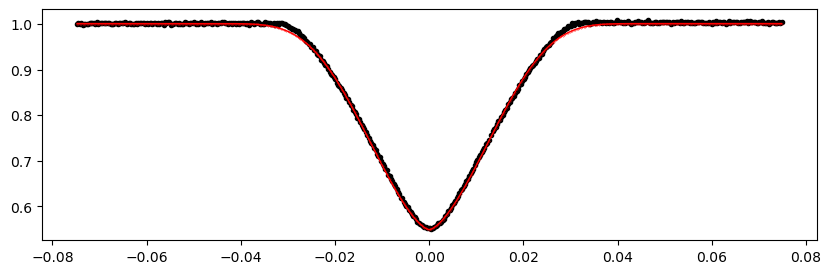

2283.752556 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.42it/s]


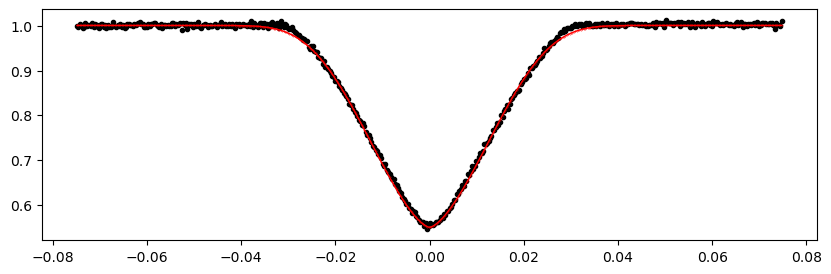

2288.441802 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.59it/s]


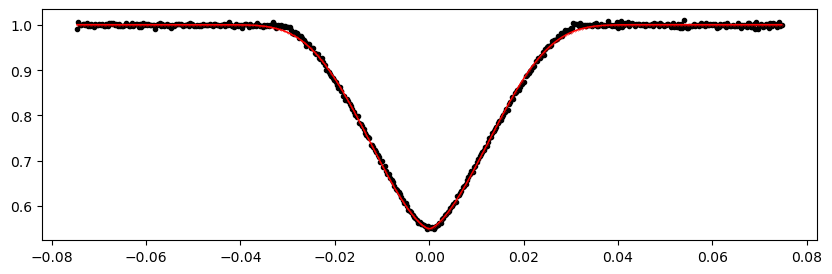

2293.1310479999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1363.73it/s]


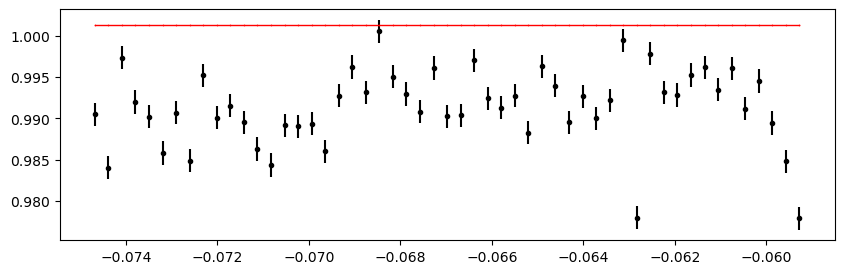

2297.820294 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.03it/s]


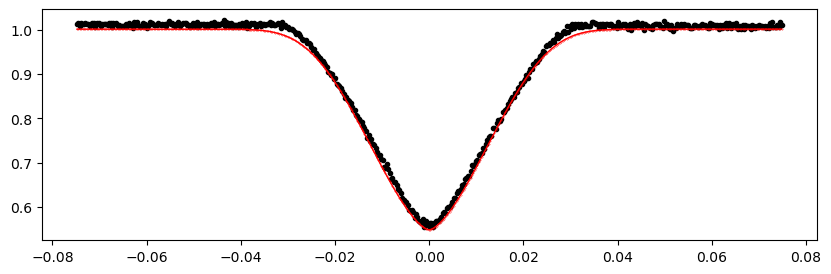

2302.50954 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.29it/s]


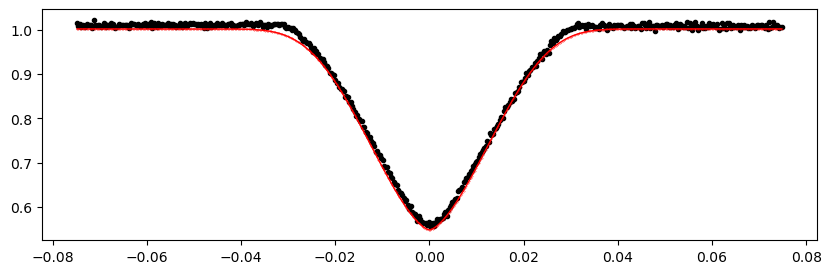

2311.888032 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.19it/s]


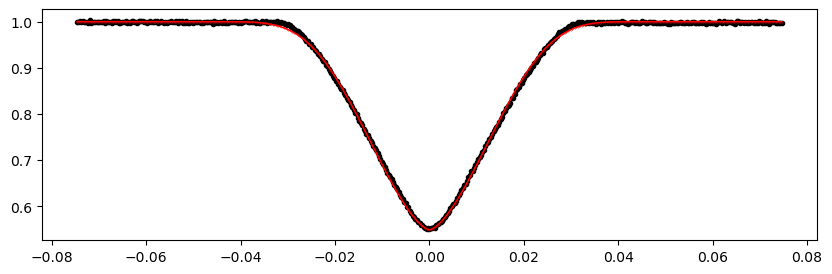

2316.5772779999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.65it/s]


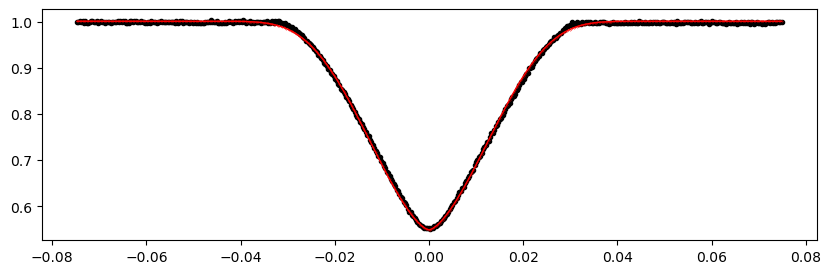

2325.95577 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.76it/s]


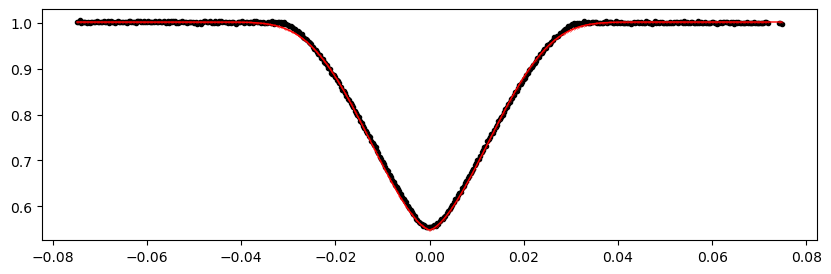

2330.645016 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.42it/s]


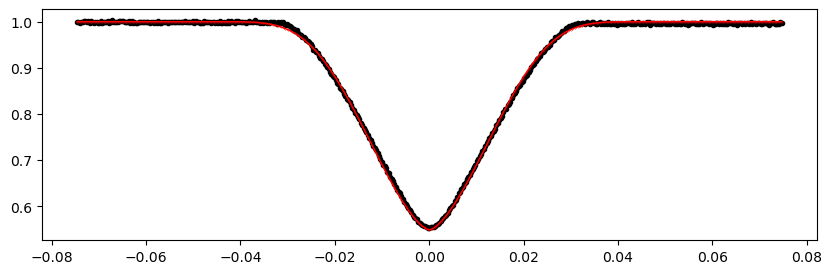

2335.334262 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.23it/s]


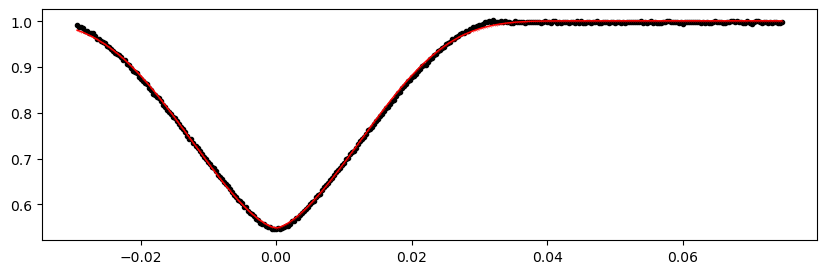

2340.0235079999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.94it/s]


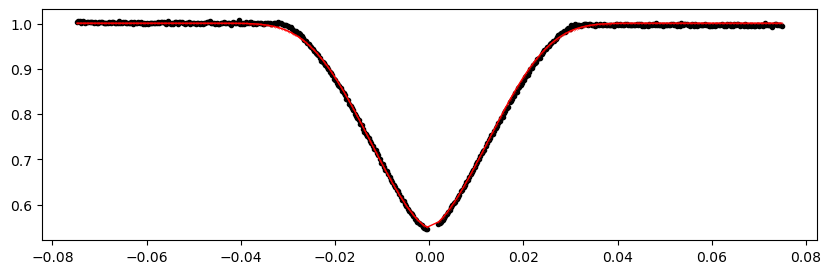

2344.712754 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1350.99it/s]


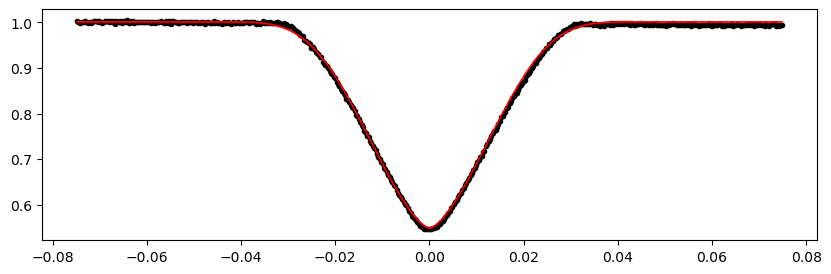

2349.402 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.29it/s]


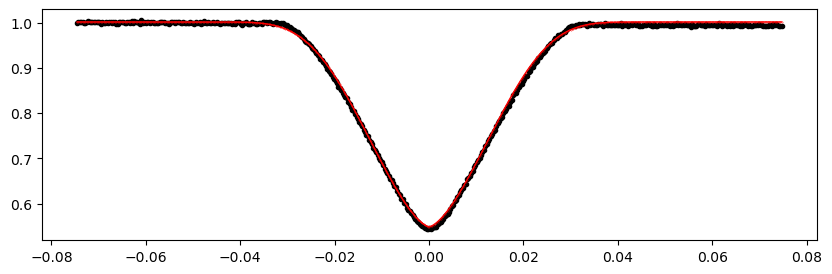

2354.091246 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1347.53it/s]


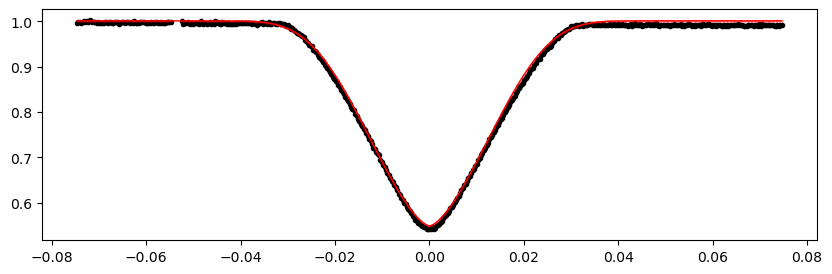

2358.780492 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.99it/s]


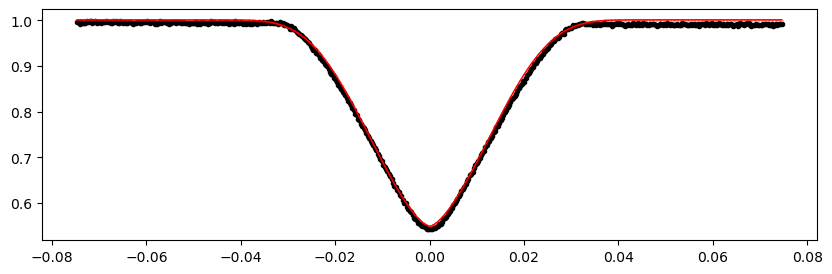

2363.469738 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.87it/s]


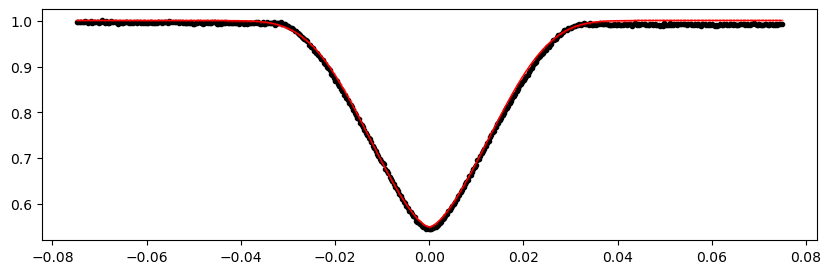

2368.1589839999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.68it/s]


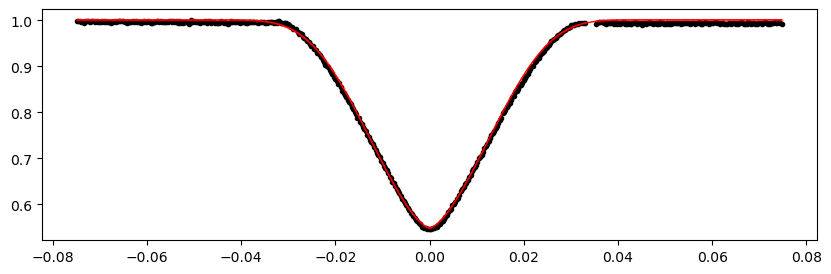

2372.84823 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1364.88it/s]


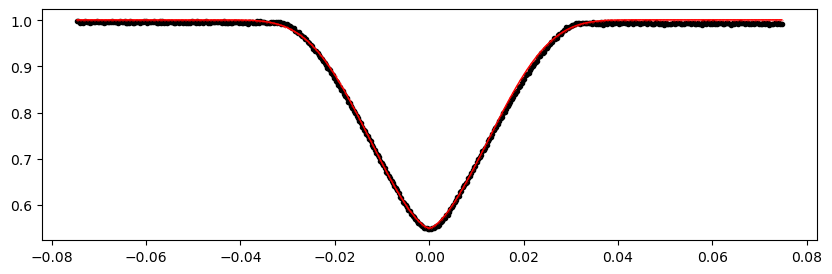

2377.537476 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1339.27it/s]


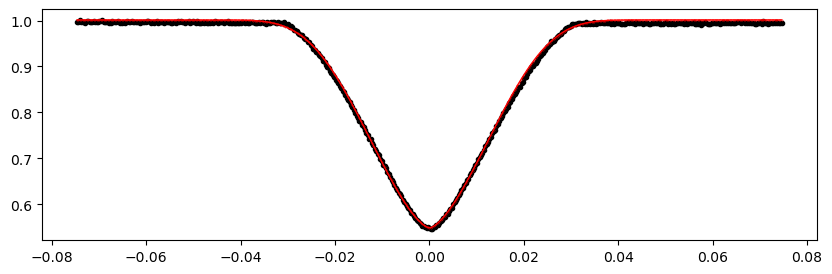

2382.226722 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.55it/s]


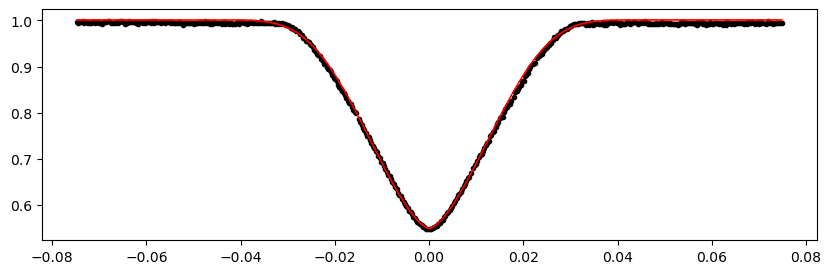

2386.915968 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.92it/s]


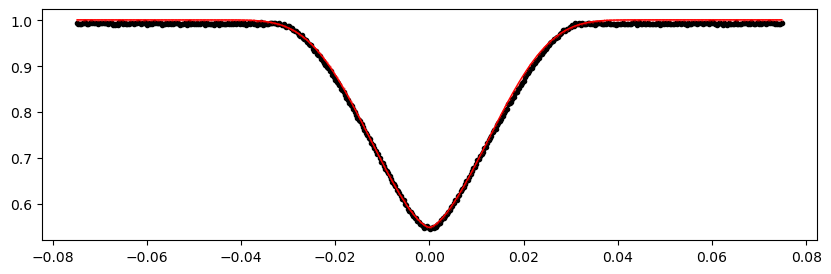

2968.382472 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.17it/s]


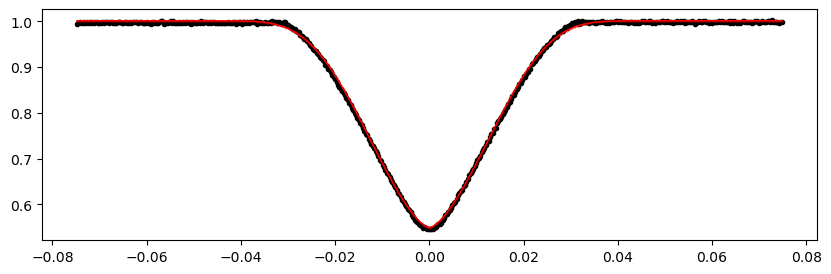

2973.071718 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.27it/s]


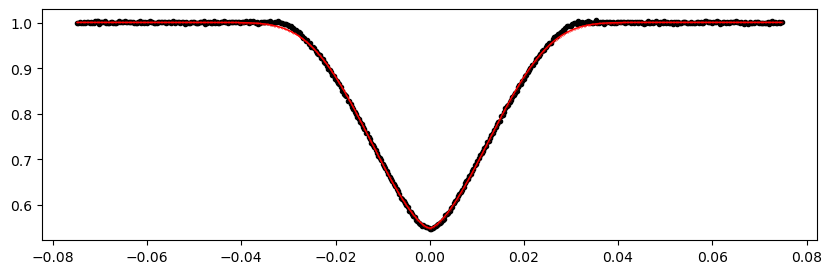

2977.760964 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1365.10it/s]


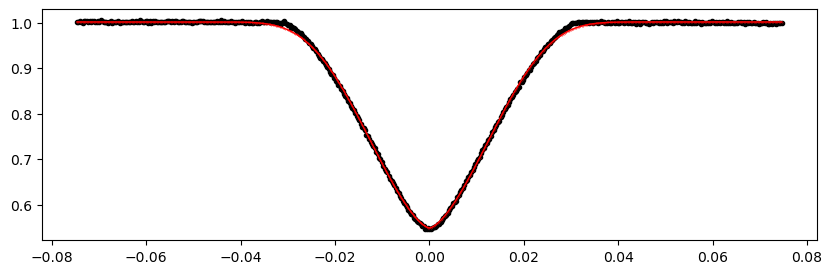

2982.45021 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1367.66it/s]


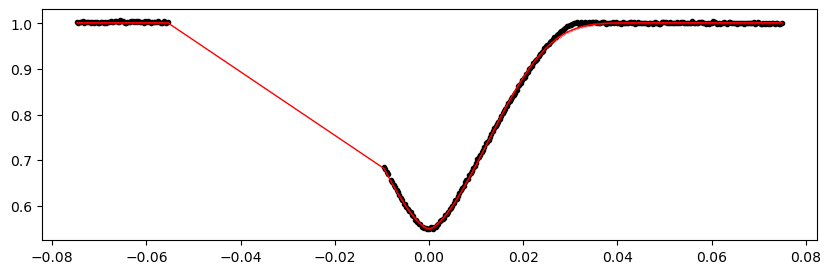

2987.139456 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1364.52it/s]


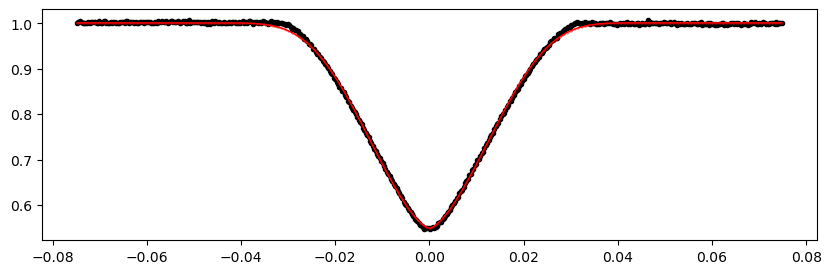

2991.828702 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.32it/s]


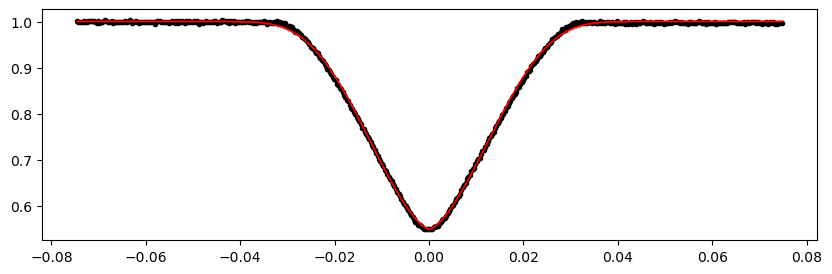

2996.5179479999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1352.29it/s]


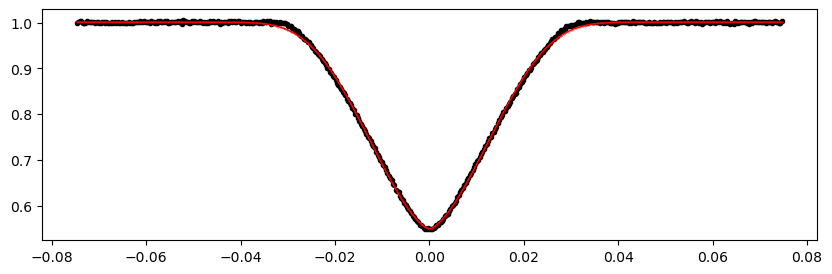

3001.2071939999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1348.35it/s]


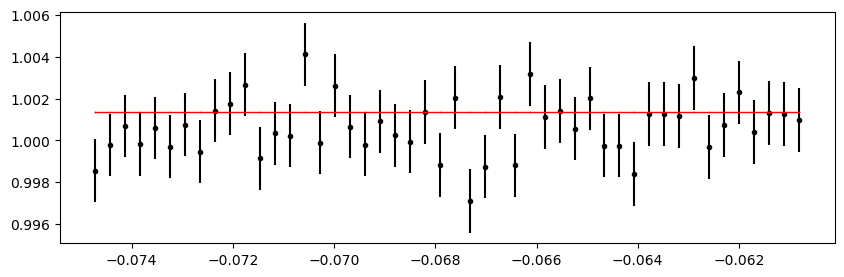

3005.8964399999995 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1306.26it/s]


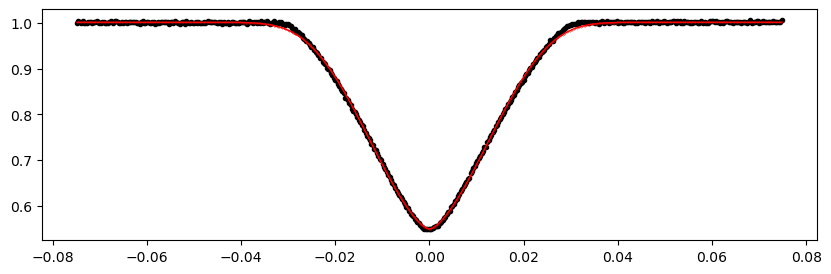

3010.585686 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1242.25it/s]


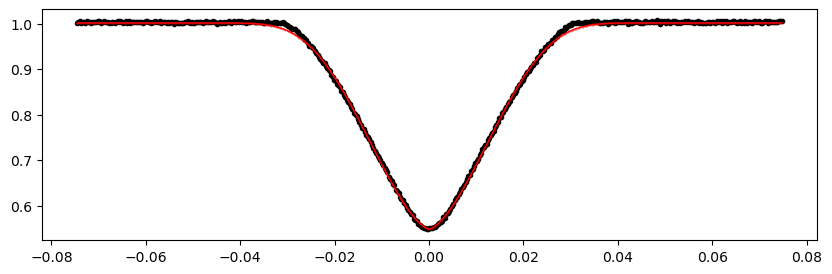

3019.964178 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1293.40it/s]


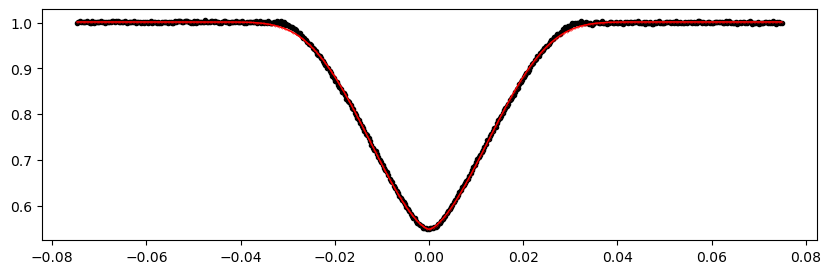

3024.653424 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1360.57it/s]


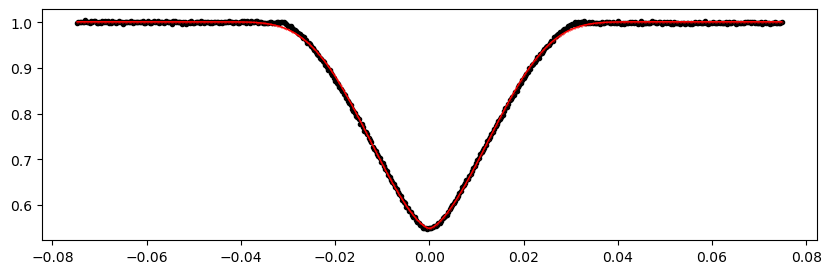

3029.34267 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.86it/s]


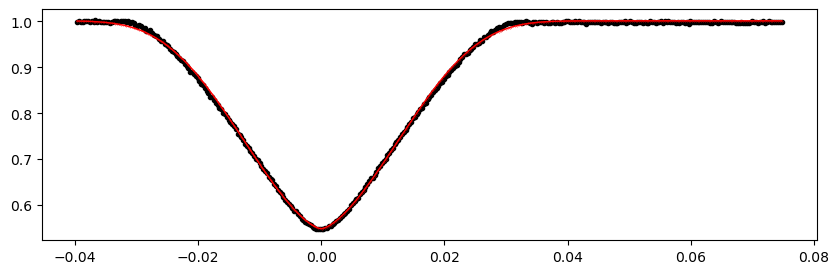

3034.031916 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1361.20it/s]


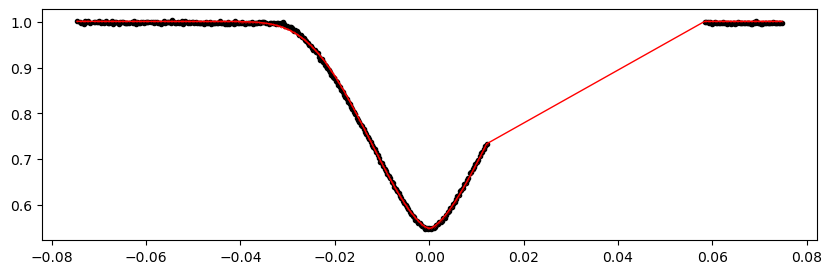

3038.721162 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1358.49it/s]


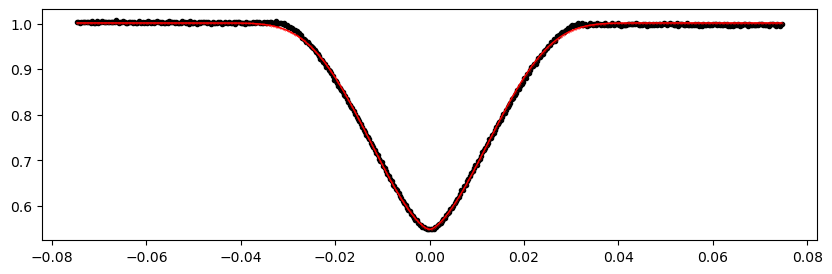

3043.4104079999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1376.19it/s]


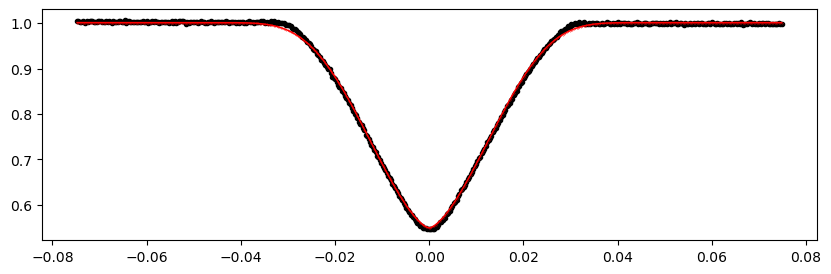

3048.0996539999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1362.25it/s]


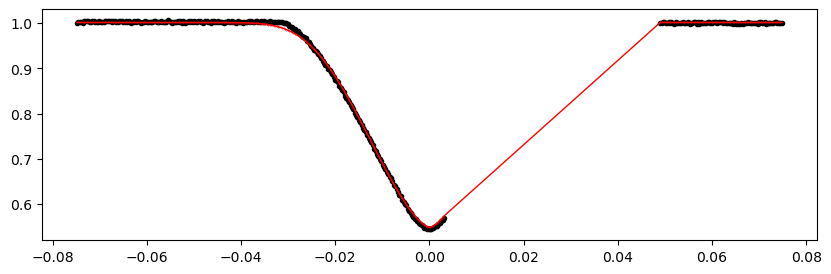

3052.7888999999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1366.67it/s]


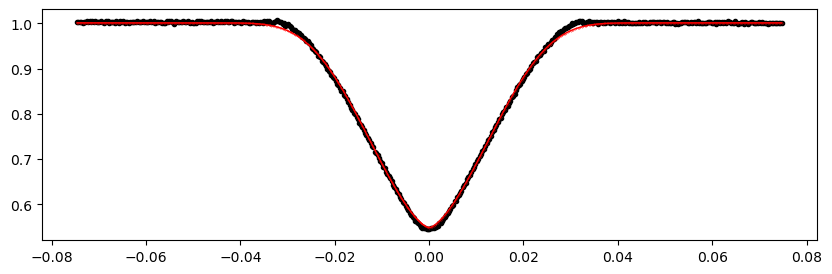

3057.478146 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1368.04it/s]


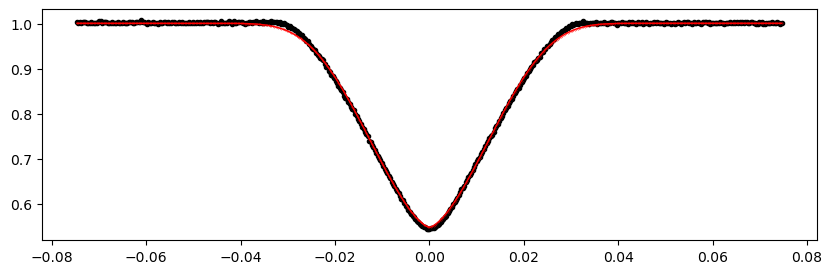

3062.167392 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1060.25it/s]


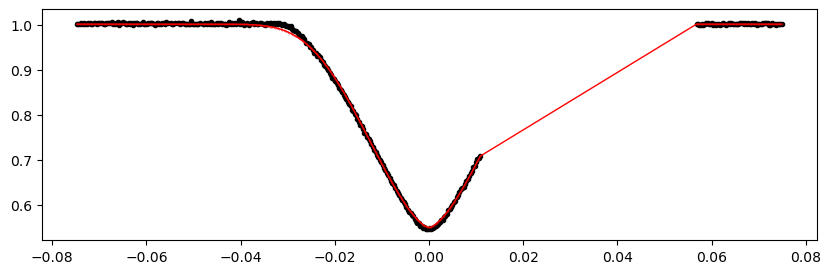

3066.856638 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1070.30it/s]


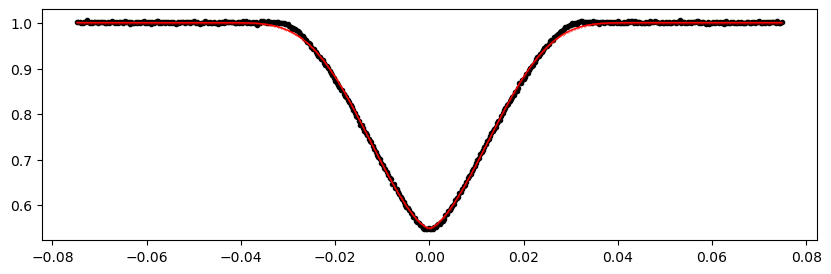

3071.545884 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.22it/s]


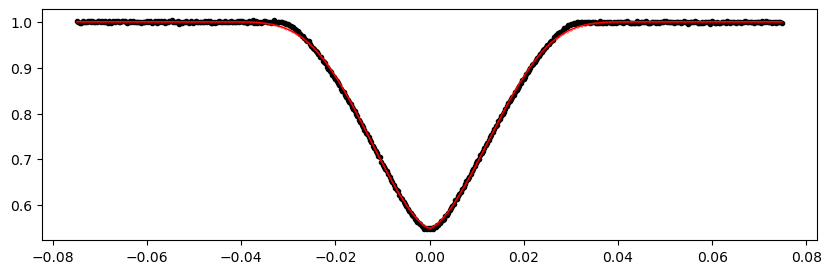

3076.23513 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1324.28it/s]


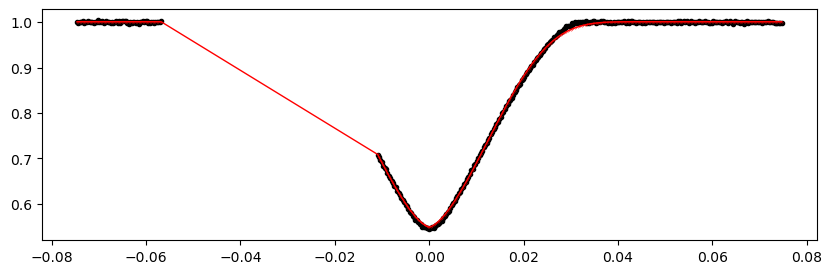

3080.924376 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1344.70it/s]


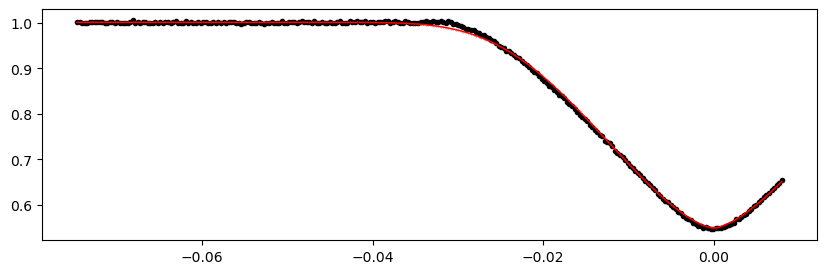

3085.613622 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.23it/s]


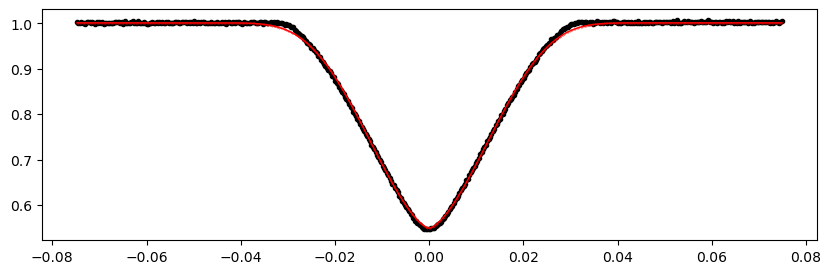

3090.3028679999998 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.67it/s]


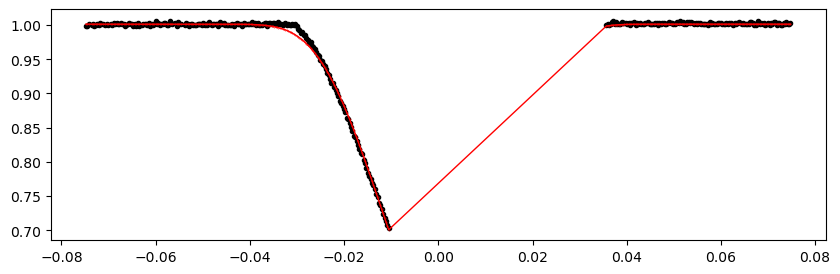

3094.9921139999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1349.01it/s]


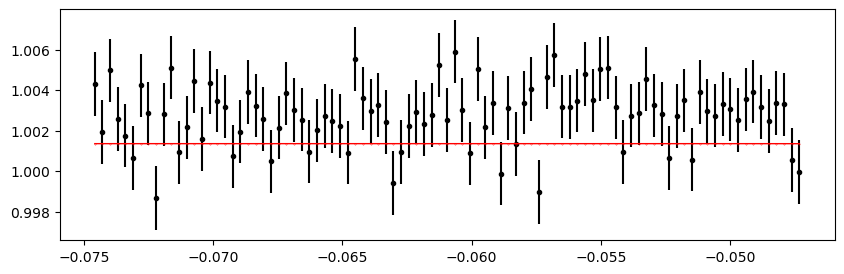

3099.6813599999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.26it/s]


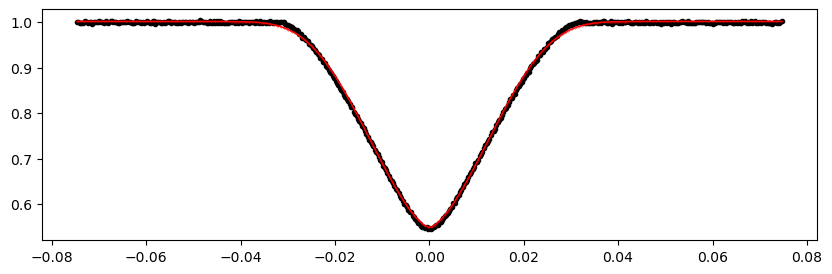

3104.370606 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.04it/s]


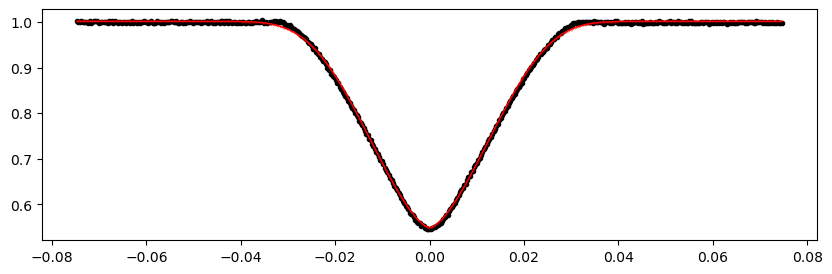

3113.749098 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1337.86it/s]


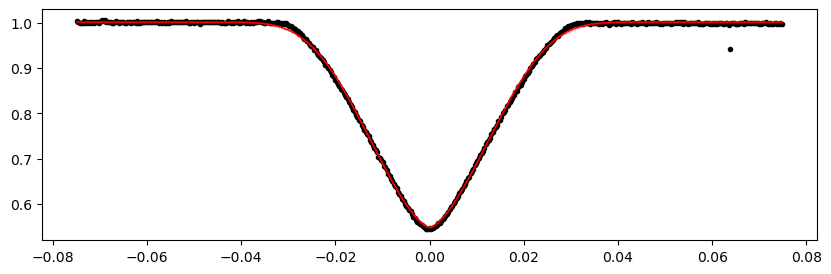

3118.438344 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1335.63it/s]


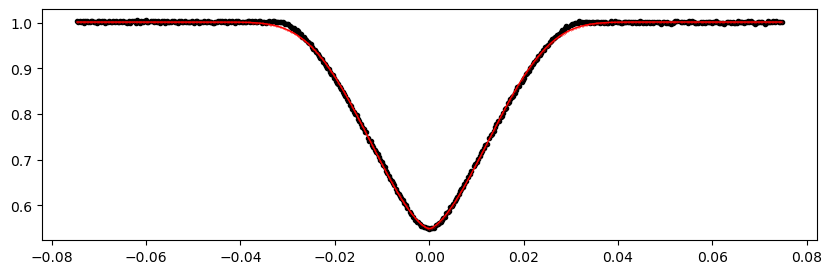

3127.816836 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1334.33it/s]


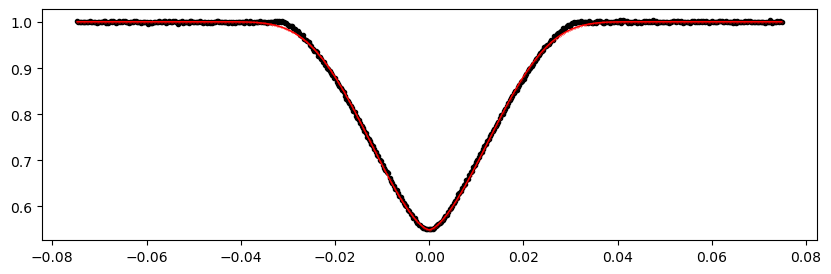

3132.506082 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1324.96it/s]


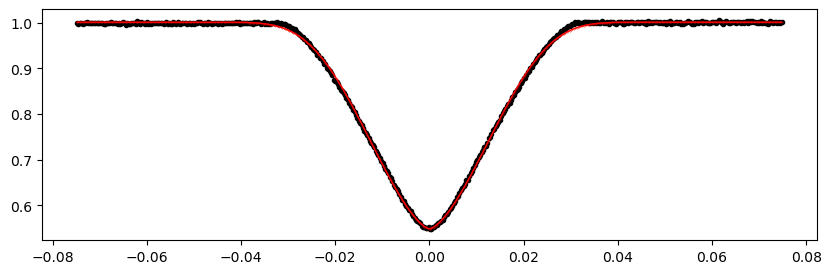

3141.8845739999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1336.73it/s]


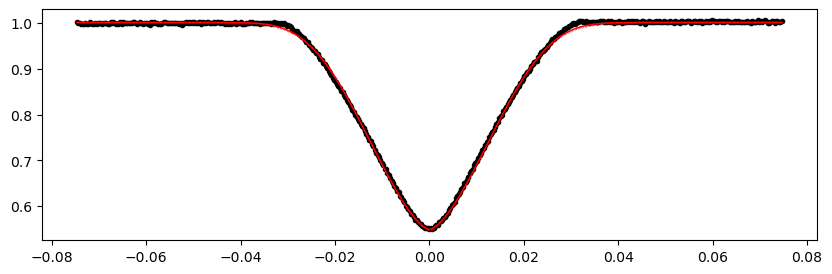

3146.5738199999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1325.09it/s]


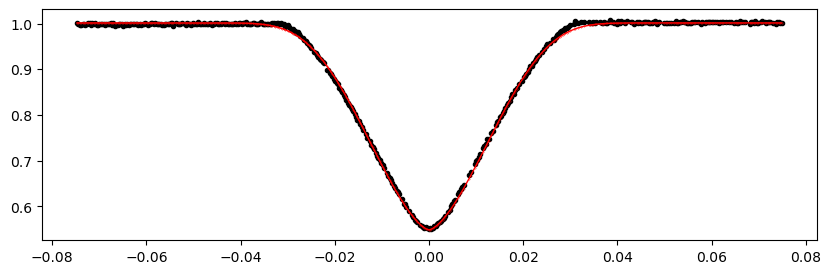

3151.2630659999995 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.77it/s]


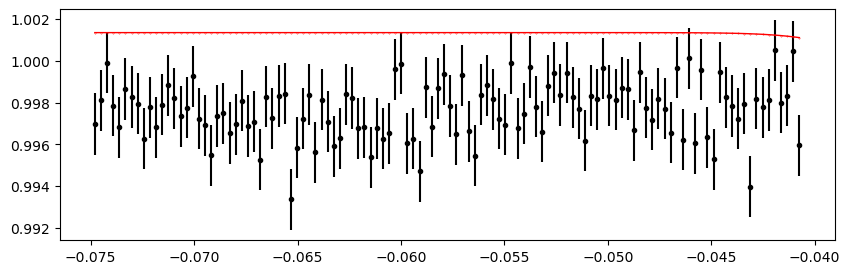

3155.952312 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.00it/s]


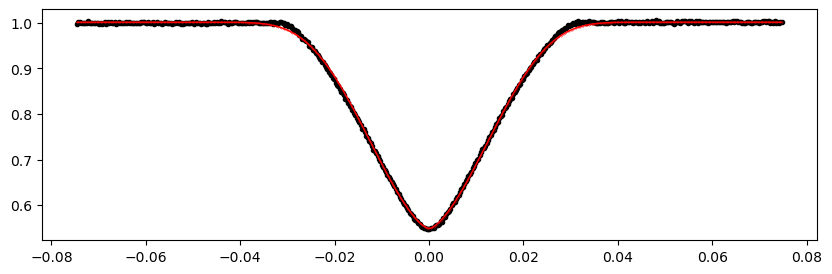

3160.641558 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.07it/s]


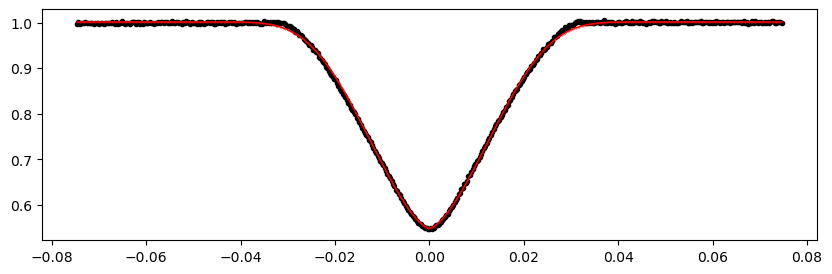

3165.330804 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1340.70it/s]


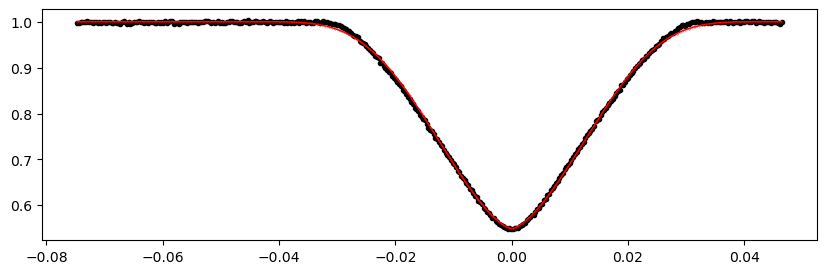

3170.02005 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1341.06it/s]


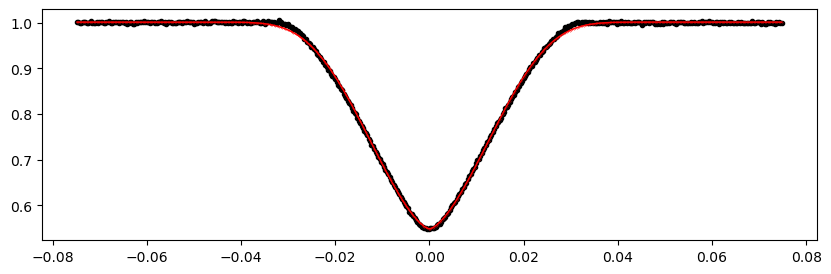

3174.709296 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1345.30it/s]


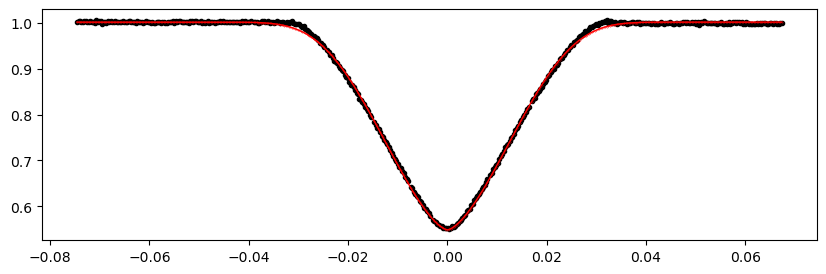

3179.398542 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1355.10it/s]


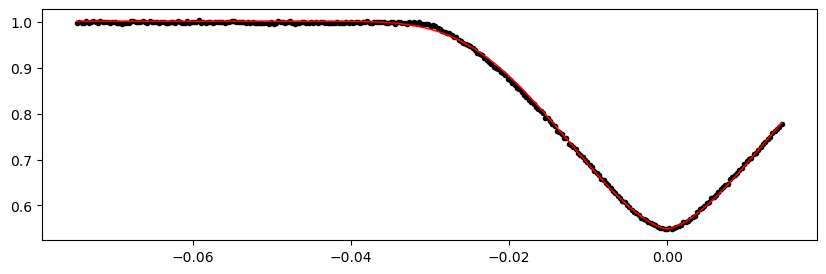

3184.087788 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1342.49it/s]


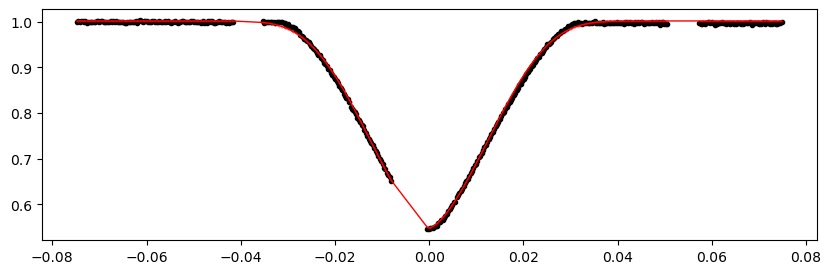

3188.7770339999997 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1346.60it/s]


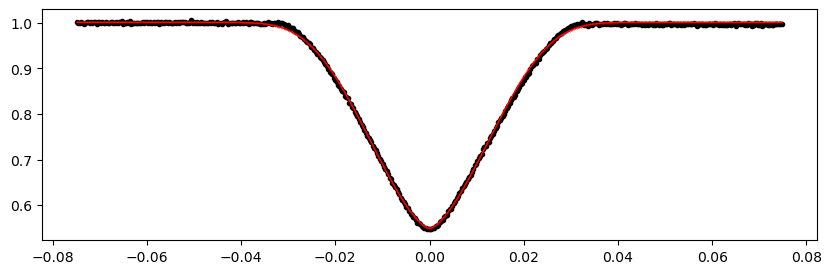

3198.1555259999996 1.0013589390322668 -0.452358403656157 -0.37500037502926503


100%|██████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1338.51it/s]


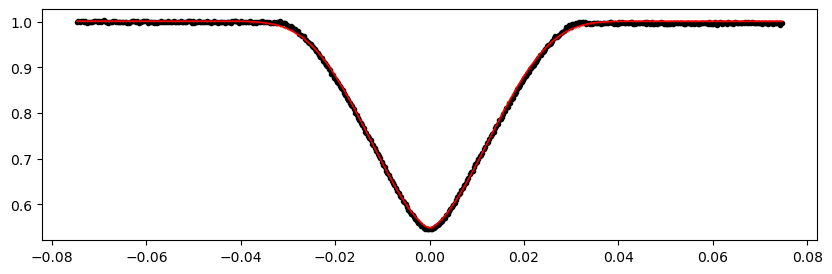

In [48]:
%matplotlib inline

print("Fitting individual secondary eclipses...")
etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s)
!$NOTIFY_CMD "Individual secondary eclipses fit done"

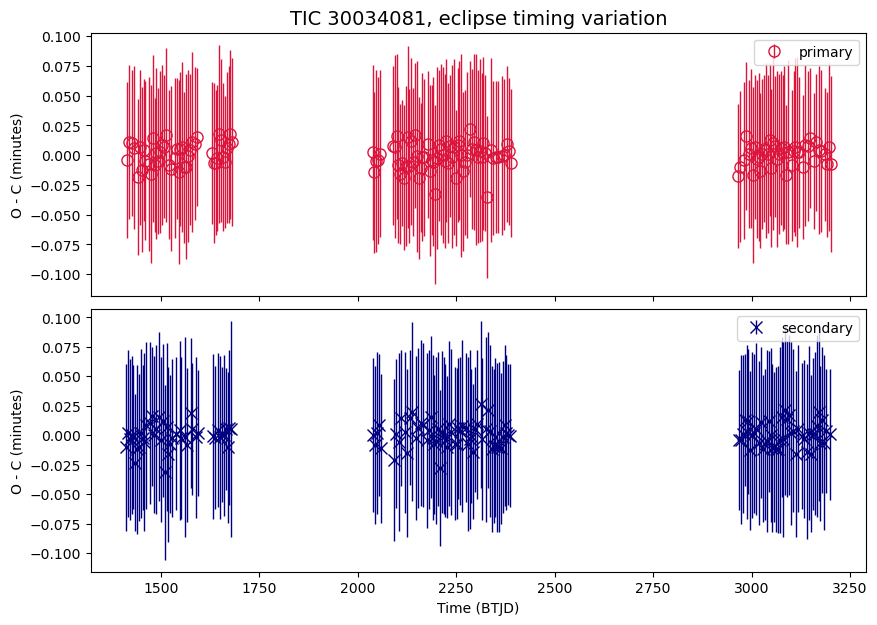

In [8]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

fig, axs = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

in_df_primary = pd.read_csv(outfile_path)
in_df_secondary = pd.read_csv(outfile_path_s)


in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60

axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
             lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()

## make a periodogram 

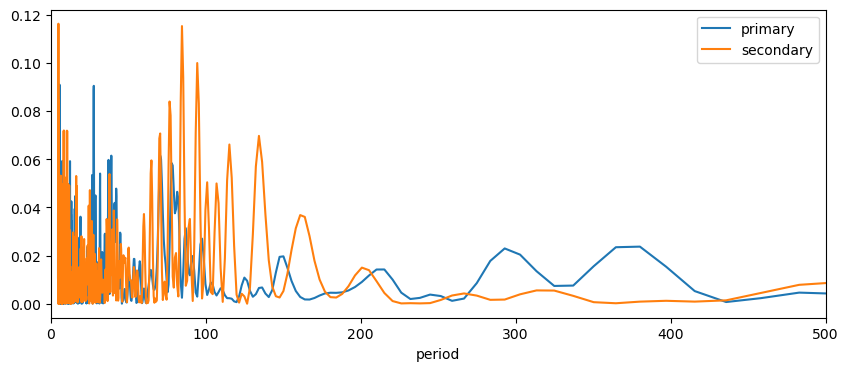

In [13]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()
frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(10, 4))

plt.plot(1/frequency, power, label = 'primary')    
plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")
plt.xlim(0, 500);
plt.legend()
plt.show()

In [79]:
# FILL-IN the ETV results / comments
has_etv = "N"
comments = "VSX Period to SB Period ~ 7:5 . Period used is ~2X of the VSX period"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                   30034081
has_etv                                                      N
comments     VSX Period to SB Period ~ 7:5 . Period used is...
period                                                4.689246
epoch_p                                            1413.897423
epoch_s                                              1411.5528
num_sectors                                                 30
time_span                                              1797.24
time_start                                              1410.9
time_end                                               3208.14


tic,has_etv,comments,period,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
30034081,N,VSX Period to SB Period ~ 7:5 . Period used is ~2X of the VSX period,4.689246,1413.897423,1411.5528,30,1797.24,1410.9,3208.14

